# Analysis of the ultrabroad source in field aa

The coordinates are roughly (ironically) 17:45:57.7530532310 -28:57:10.7694483833 ICRS.

## Detections

There are three confident (SNR > 10) lines detected (see [Fit lines](#Fit_lines)).

These are CS 2-1, SO 2(3)-1(2), SO 2(2)-1(1), and SO2 2(2,0)-3(1,3), in rough order of brightness (SO 32 may be brighter than CS 2-1).

No other lines are detected, and the H-bearing species appear to have restrictive upper limits (see [Overplot](# Overplot all the lines (to show nondetections)).

The pair of SO lines gives a temperature of roughly 15K.

The SO lines are optically thin, but at $\tau\sim0.1-0.2$, so it is not likely that the filling factor is small.  That puts the gas size at the source size, which is roughly 1".  The beam size is 1.5", but the source may be slightly resolved, giving a deconvolved size ~0.8".


In [605]:
%matplotlib inline
import pylab as pl
pl.rcParams['font.size'] = 14

In [606]:
from spectral_cube import SpectralCube
from astropy import units as u, constants
from astropy.coordinates import SkyCoord
import pyspeckit
import glob
import radio_beam

In [607]:
from astropy import stats

In [608]:
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter
import numpy as np
from astropy.table import Table

In [609]:
import latex_info

In [610]:
path = '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working//'

In [611]:
cd $path

/orange/adamginsburg/ACES/rawdata/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working


In [612]:
ls -d *image

uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw25.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw27.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw29.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw31.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw33.cube.I.iter1.reclean.image@
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw35.cube.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw25.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw27.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw29.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw31.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw33.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw35.mfs.I.iter1.image/


In [613]:
coord = SkyCoord("17:45:57.7530532310 -28:57:10.7694483833", unit=(u.h, u.deg), frame='icrs')
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [614]:
import regions

In [615]:
region = regions.RectangleSkyRegion(center=coord, width=15*u.arcsec, height=15*u.arcsec)
cutregion = regions.CircleSkyRegion(center=coord, radius=15*u.arcsec) # circumscribe the above region so we can match RA/Dec to Galactic

In [616]:
bigregion = regions.RectangleSkyRegion(center=coord, width=35*u.arcsec, height=35*u.arcsec)
bigcircregion = regions.CircleSkyRegion(center=coord, radius=35*u.arcsec)

In [617]:
biggerregion = regions.RectangleSkyRegion(center=coord, width=65*u.arcsec, height=65*u.arcsec)

In [618]:
# measure the surrounding ISM in an annulus
annulus = regions.CircleAnnulusSkyRegion(center=coord, inner_radius=3*u.arcsec, outer_radius=6*u.arcsec)

In [619]:
circle = regions.CircleSkyRegion(center=coord, radius=3*u.arcsec)

In [620]:
imgs = sorted(glob.glob(f"{path}/sizemitigated/*.cube.*.image"))
imgs.insert(-1, '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw33.cube.I.iter1.reclean.image',)
imgs

['/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working///sizemitigated/uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw25.sizemitigated.cube.I.iter1.image',
 '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working///sizemitigated/uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw27.sizemitigated.cube.I.iter1.image',
 '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working///sizemitigated/uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw29.sizemitigated.cube.I.iter1.image',
 '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working///sizemitigated/uid___A001_X15a0_X13c.s38_0.Sgr_A_star_s

In [621]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cubes = [SpectralCube.read(fn) for fn in imgs]

In [622]:
scubes = [cube.subcube_from_regions([region]) for cube in cubes]

In [623]:
pxcrd = [cube.wcs.celestial.world_to_pixel(coord) for cube in cubes]
spectra = [cube[:, int(y), int(x)].to(u.K) for cube, (x,y) in zip(cubes, pxcrd)]

In [624]:
pspectra = pyspeckit.Spectra([pyspeckit.Spectrum.from_hdu(sp.hdu) for sp in spectra])

INFO: Creating spectra [pyspeckit.spectrum.classes]
INFO: Concatenating data [pyspeckit.spectrum.classes]


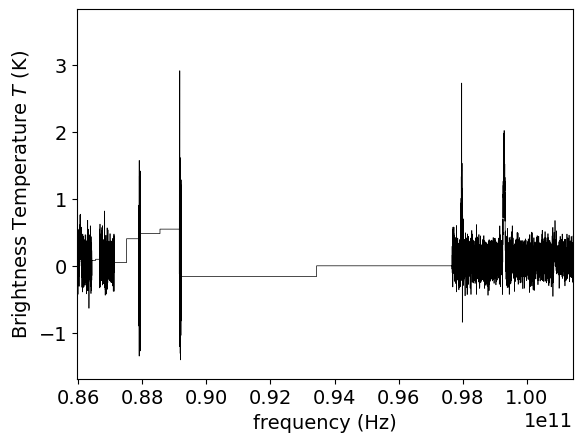

In [625]:
pspectra.plotter()

# Fit lines

In [626]:
from astroquery.splatalogue import Splatalogue
from astroquery.splatalogue.utils import minimize_table

In [627]:
#Splatalogue.query_lines(97.98095 * (1-30/3e5) *u.GHz, 97.98095 * (1+30/3e5)*u.GHz, energy_max=100, energy_type='eu_k')

In [628]:
nurest_so32 = 99.29987e9*u.Hz	
nurest_34so32 = 97.715317e9*u.Hz
nurest_so21 = 86.09395e9*u.Hz
nurest_cs21 = 97.98095e9*u.Hz
nurest_so45 = 100.02956e9*u.Hz
nurest_h13cop = 86.7543*u.GHz
nurest_c34s21 = 96.412951*u.GHz

### Table

In [629]:
measurement_table = []

### spw33 

In [630]:
# rough Jy to Kelvin estimate to change my guesses, that were in Jy, to K
JtoK = cubes[0].beam.jtok(cubes[0].spectral_axis).mean().value
JtoK

54.2808632681691

In [631]:
b3beam = cubes[0].beam
b3beam

Beam: BMAJ=1.9257872153987963 arcsec BMIN=1.5734451566902963 arcsec BPA=-71.8496817278145 deg

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.916434 +/-       0.0275603 
Param #1       SHIFT0 =  9.79603e+10 +/-          668082 
Param #2       WIDTH0 =  1.92385e+07 +/-          668082   Range:   [0,inf)
Param #3   AMPLITUDE1 =      1.71866 +/-       0.0253826 
Param #4       SHIFT1 =  9.92861e+10 +/-          386802 
Param #5       WIDTH1 =  2.26814e+07 +/-          386802   Range:   [0,inf) 
 Velocity width sigma(CS) = 58.87640739582237 km / s  FWHM(CS) =  138.3595573801826 km / s  VLSR(CS) =  63.2888385598767 km / s  SNR :  33.25192979447065 
 Velocity width sigma(SO) = 68.48604440164407 km / s  FWHM(SO) =  160.94220434386355 km / s  VLSR(SO) =  41.471029421557795 km / s  SNR :  67.7101076099218


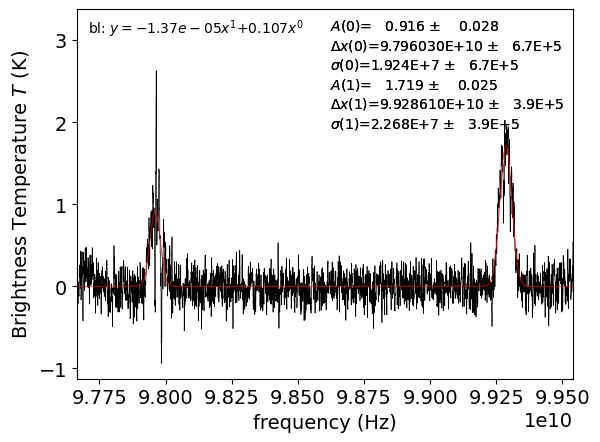

In [632]:
spw33 = pspectra[-2]
spw33.plotter()
spw33.specfit(guesses=[0.06*JtoK, 97.98e9, 97.8e9/3000, 0.06*JtoK, 99.3e9, 2e7])
spw33.baseline(excludefit=True)
spw33.specfit(guesses=[0.06*JtoK, 97.98e9, 97.8e9/3000, 0.06*JtoK, 99.3e9, 2e7])
#measurement_table.append(['CS 2-1', 97.98095e9] + list(zip(spw33.specfit.parinfo.values[:3], spw33.specfit.parinfo.errors[:3])))
#measurement_table.append(['SO 2(3)-1(2)', 99.2998e9] + list(zip(spw33.specfit.parinfo.values[3:6], spw33.specfit.parinfo.errors[3:6])))
                         
print(spw33.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS) = ",
      -(spw33.specfit.parinfo['SHIFT0'].value - 97.98095e9) / 97.98095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw33.specfit.parinfo['AMPLITUDE0'].value / spw33.specfit.parinfo['AMPLITUDE0'].error,
      "\n Velocity width sigma(SO) =",
      spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spw33.specfit.parinfo['SHIFT1'].value - 99.2998e9) / 99.29987e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw33.specfit.parinfo['AMPLITUDE1'].value / spw33.specfit.parinfo['AMPLITUDE1'].error
     )

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =        1.032 +/-       0.0439775   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.79656e+10 +/-     1.00287e+06   Range:[9.77e+10,9.83e+10]
Param #2       WIDTH0 =  2.28333e+07 +/-          923831   Range: [0,4e+07]
Param #3   AMPLITUDE1 =     -1.32644 +/-        0.105463   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.79842e+10 +/-          224555   Range:[9.77e+10,9.83e+10]
Param #5       WIDTH1 =  2.52236e+06 +/-          245671   Range: [0,4e+07]
Param #6   AMPLITUDE2 =     -1.36715 +/-        0.154886   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.79598e+10 +/-          144960   Range:[9.77e+10,9.83e+10]
Param #8       WIDTH2 =  1.13271e+06 +/-          152075   Range: [0,4e+07]
Param #9   AMPLITUDE3 =      1.56388 +/-        0.197749   Ra

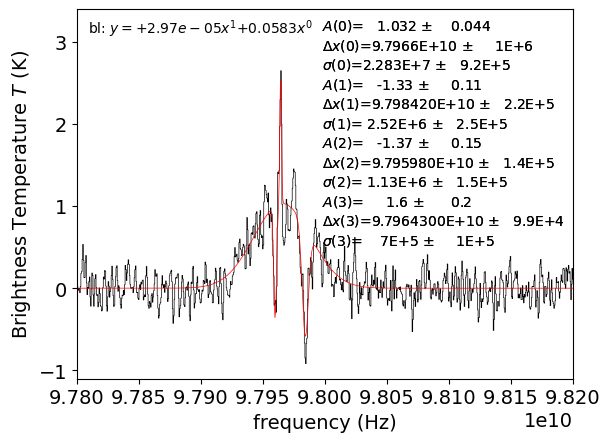

In [633]:
spw33 = pspectra[-2]
spcs = spw33.copy()
spcs.plotter(xmin=97.8e9, xmax=98.2e9)
spcs.specfit(guesses=[1, 97.98e9, 97.8e9/3000])
spcs.baseline(excludefit=True)
spcs.specfit(guesses=[1, nurest_cs21.to(u.Hz).value, 1e7, 
                      -0.5, 97.984e9, 1e6, # absorption feature
                      -0.5, 97.9594e9, 1e6, # absorption feature
                      0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['CS 2-1', nurest_cs21.to(u.Hz).value] + list(zip(spcs.specfit.parinfo.values[:3], spcs.specfit.parinfo.errors[:3])))

print(spcs.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS) = ",
      -(spcs.specfit.parinfo['SHIFT0'].value - 97.98095e9) / 97.98095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spcs.specfit.parinfo['AMPLITUDE0'].value / spcs.specfit.parinfo['AMPLITUDE0'].error,)

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =      1.74821 +/-       0.0250455   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.92866e+10 +/-          380560   Range:[9.91e+10,9.95e+10]
Param #2       WIDTH0 =  2.26732e+07 +/-          363669   Range: [0,4e+07]
Param #3   AMPLITUDE1 =    -0.634834 +/-        0.116157   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.93027e+10 +/-          211553   Range:[9.91e+10,9.95e+10]
Param #5       WIDTH1 =  1.01167e+06 +/-          218057   Range: [0,4e+07]
Param #6   AMPLITUDE2 =    -0.245241 +/-               0   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.92775e+10 +/-               0   Range:[9.91e+10,9.95e+10]
Param #8       WIDTH2 =  1.16415e-10 +/-               0   Range: [0,4e+07] 
 Velocity width sigma(SO) = 68.46088001600494 km / s  FWHM(S

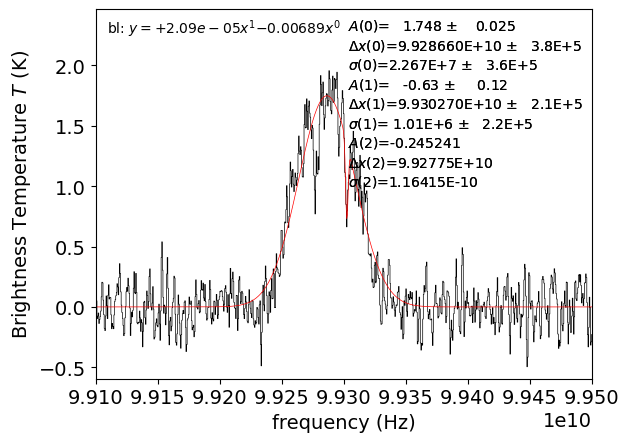

In [634]:
#SO

spw33 = pspectra[-2]
spso = spw33.copy()
spso.plotter(xmin=99.1e9, xmax=99.5e9)
spso.specfit(guesses=[1, 99.299e9, 97.8e9/3000])
spso.baseline(excludefit=True)
spso.specfit(guesses=[1, nurest_so32.to(u.Hz).value, 1e7, 
                      -0.5, 99.302e9, 1e6, # absorption feature
                      -0.5, 99.277e9, 1e6, # absorption feature
                      #-0.5, 97.9594e9, 1e6, # absorption feature
                      #0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (99.1e9, 99.5e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['SO 2(3)-1(2)', nurest_so32.to(u.Hz).value] + list(zip(spso.specfit.parinfo.values[:3], spso.specfit.parinfo.errors[:3])))

print(spso.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO) =",
      spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spso.specfit.parinfo['SHIFT0'].value - 99.299095e9) / 99.299095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spso.specfit.parinfo['AMPLITUDE0'].value / spso.specfit.parinfo['AMPLITUDE0'].error,)

In [635]:
nurest_34so32

<Quantity 9.7715317e+10 Hz>

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.216353 +/-       0.0239146   Range:[0,2.71404]
Param #1       SHIFT0 =  9.77039e+10 +/-     2.60308e+06   Range:[9.71e+10,9.7775e+10]
Param #2       WIDTH0 =  2.03257e+07 +/-     2.72229e+06   Range: [0,4e+07] 
 Velocity width sigma(34SO) = 62.36702943587609 km / s  FWHM(SO) =  146.56251917430882 km / s  VLSR(SO) =  34.90459508002756 km / s  SNR :  9.046864715282798


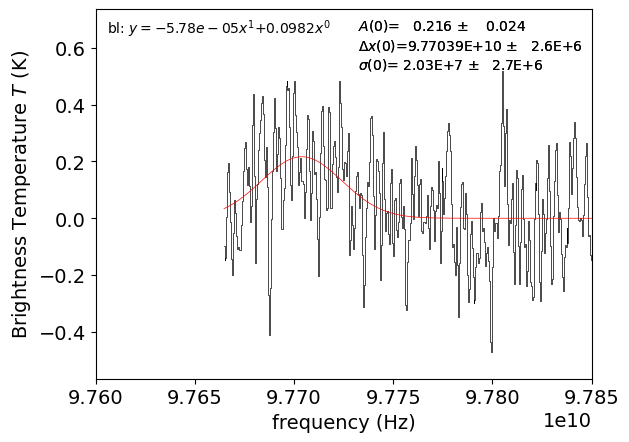

In [636]:
#34SO

spw33 = pspectra[-2]
spso = spw33.copy()
spso.plotter(xmin=97.6e9, xmax=97.85e9)
spso.specfit(guesses=[1, nurest_34so32.to(u.Hz).value, 97.8e9/3000])
spso.baseline(excludefit=True)
spso.specfit(guesses=[1, nurest_34so32.to(u.Hz).value, 1e7, 
                      #-0.5, 99.302e9, 1e6, # absorption feature
                      #-0.5, 99.277e9, 1e6, # absorption feature
                      #-0.5, 97.9594e9, 1e6, # absorption feature
                      #0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(0, 0.05*JtoK), (97.1e9, 97.775e9), (0, 4e7),
                     ],
              limited=[(True, True)]*3)
measurement_table.append(['34SO 2(3)-1(2)', nurest_34so32.to(u.Hz).value] + list(zip(spso.specfit.parinfo.values[:3], spso.specfit.parinfo.errors[:3])))

print(spso.specfit.fitter.parinfo,
      "\n Velocity width sigma(34SO) =",
      spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spso.specfit.parinfo['SHIFT0'].value - nurest_34so32.to(u.Hz).value) / nurest_34so32.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spso.specfit.parinfo['AMPLITUDE0'].value / spso.specfit.parinfo['AMPLITUDE0'].error,)

In [637]:
# SO2 7(3,5): 97.70234
# 34SO 2(3)- : 97.7154	

In [638]:
linetb[['SO2' in x for x in linetb['Line']]]

Band Name,TP SPW,7m SPW,12m SPW,Center,Bandwidth,F_Lower,F_Upper,F_Resolution,col9,Line,Rest (GHz),V_Lower,V_Upper,V_Res.,_1,References
str10,int64,int64,int64,float64,float64,float64,float64,float64,str3,str27,float64,float64,float64,float64,int64,str30
Cont 2,27,26,35,100.5,1.875,99.5625,101.4375,0.000976563,--,"SO2 2(2,0)-3(1,3)",100.878105,--,--,2.9,--,Jones et al. (2008)
Cont 1,25,24,33,98.6,1.875,97.6625,99.5375,0.000976563,--,"SO2 7(3,5)–8(2,6)",97.70234,--,122.2,3.0,--,Jones et al. (2008)


In [639]:
linetb[['SO ' in x for x in linetb['Line']]]

Band Name,TP SPW,7m SPW,12m SPW,Center,Bandwidth,F_Lower,F_Upper,F_Resolution,col9,Line,Rest (GHz),V_Lower,V_Upper,V_Res.,_1,References
str10,int64,int64,int64,float64,float64,float64,float64,float64,str3,str27,float64,float64,float64,float64,int64,str30
Cont 1,25,24,33,98.6,1.875,97.6625,99.5375,0.000976563,**,SO 3(2)-2(1),99.29987,-717.4,--,2.95,--,--
Cont 2,27,26,35,100.5,1.875,99.5625,101.4375,0.000976563,--,SO 4(5)-4(4),100.02956,--,--,2.93,--,Jones et al. (2008)
H13CN,17,16,25,86.2,0.46875,85.965625,86.434375,0.000488,--,SO 2(2)-1(1),86.09395,--,--,1.7,--,--
Cont 1,25,24,33,98.6,1.875,97.6625,99.5375,0.000976563,--,34SO 3(2)–2(1),97.7154,--,162.3,3.0,--,Jones et al. (2008)
Cont 1,25,24,33,98.6,1.875,97.6625,99.5375,0.000976563,--,33SO 3(2)-2(1),98.483155,--,--,--,--,--


### spw25

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.382843 +/-       0.0261676 
Param #1       SHIFT0 =  8.60829e+10 +/-     1.53617e+06 
Param #2       WIDTH0 =  1.94643e+07 +/-     1.53617e+06   Range:   [0,inf) 
 Velocity width sigma(SO21) = 67.78625364381341 km / s  FWHM(SO) =  159.2976960629615 km / s  VLSR(SO2(2)-1(1)):  38.46949335873756 km / s  SNR :  14.630446711437804


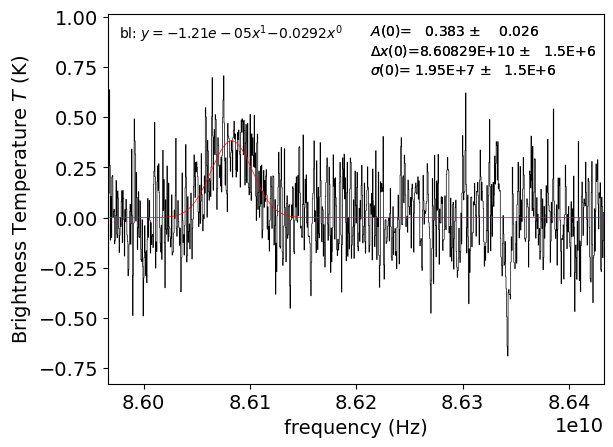

In [640]:
spw25 = pspectra[0]
spw25.data -= np.median(spw25.data) # contsub
spw25.plotter()
spw25.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
spw25.baseline(excludefit=True)
spw25.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
measurement_table.append(['SO 2(2)-1(1)', 86.09395e9] + list(zip(spw25.specfit.parinfo.values[:3], spw25.specfit.parinfo.errors[:3])))
print(spw25.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO21) =",
      spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO2(2)-1(1)): ",
      -(spw25.specfit.parinfo['SHIFT0'].value - 86.09395e9) / 86.09395e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw25.specfit.parinfo['AMPLITUDE0'].value / spw25.specfit.parinfo['AMPLITUDE0'].error
     )

### spw 27 (no detections)

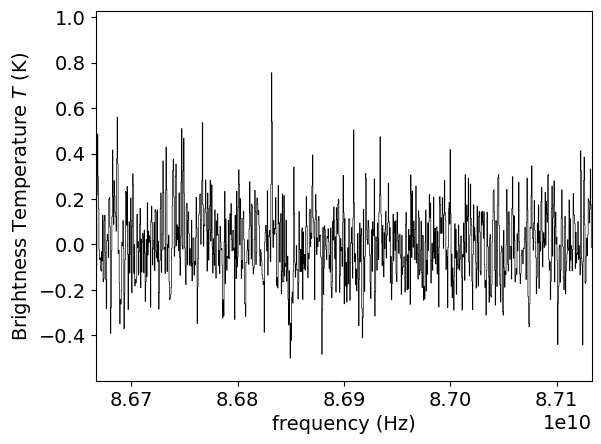

In [641]:
spw27 = pspectra[1]
spw27.data -= np.median(spw27.data) # contsub
spw27.plotter()
#spw27.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
#spw27.baseline(excludefit=True)
#spw27.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
#measurement_table.append(['SO 2(2)-1(1)', 86.09395e9] + list(zip(spw27.specfit.parinfo.values[:3], spw27.specfit.parinfo.errors[:3])))
#print(spw27.specfit.fitter.parinfo,
#      "\n Velocity width sigma(SO21) =",
#      spw27.specfit.parinfo['WIDTH0'].value/spw27.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
#      " FWHM(SO) = ",
#      2.35*spw27.specfit.parinfo['WIDTH0'].value/spw27.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
#      " VLSR(SO2(2)-1(1)): ",
#      -(spw27.specfit.parinfo['SHIFT0'].value - 86.09395e9) / 86.09395e9 * constants.c.to(u.km/u.s),
#      " SNR : ", spw27.specfit.parinfo['AMPLITUDE0'].value / spw27.specfit.parinfo['AMPLITUDE0'].error
#     )

### spw 35

In [642]:
nurest_so45

<Quantity 1.0002956e+11 Hz>

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.171514 +/-       0.0286755   Range:[0.05,2.71404]
Param #1       SHIFT0 =  1.00875e+11 +/-     4.79635e+06   Range:[1.008e+11,1.009e+11]
Param #2       WIDTH0 =  2.48427e+07 +/-     4.79635e+06   Range:[1.5e+07,4e+07]
Param #3   AMPLITUDE1 =    0.0583502 +/-       0.0301321   Range:[0.05,2.71404]
Param #4       SHIFT1 =  1.00017e+11 +/-     1.09545e+07   Range:[9.99962e+10,1.00063e+11]
Param #5       WIDTH1 =      1.5e+07 +/-               0   Range:[1.5e+07,4e+07] 
 Velocity width sigma(SO2 220) = 73.83054245480561 km / s  FWHM(SO2) =  173.50177476879318 km / s  VLSR(SO2):  9.873140266473737 km / s  SNR :  5.98120649752295


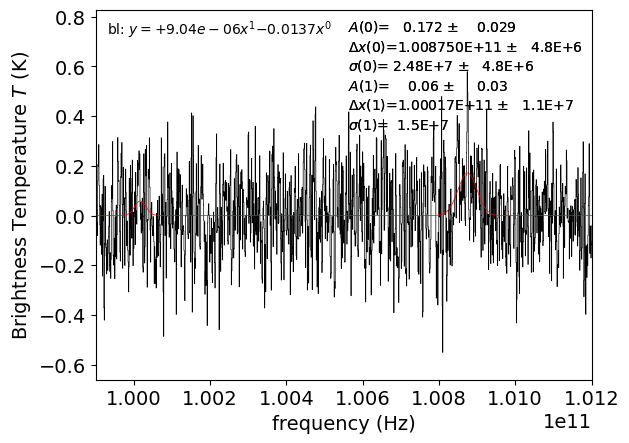

In [643]:
# Not a good fit

spw35 = pspectra[-1].copy()
spw35.data -= np.median(spw35.data) # contsub
spw35.plotter(xmin=99.9e9, xmax=101.2e9)
#spw35.plotter(xmin=100.55e9, xmax=101.2e9)
spw35.specfit(guesses=[0.006*JtoK, 100.878105e9, 1e7, 0.2, nurest_so45.to(u.Hz).value, 1e7],
              limits=[(0, 0.05*JtoK), (100.8e9, 100.9e9), (0, 4e7),
                      (0, 0.05*JtoK), (99.99e9, 100.2e9), (0, 4e7),
                     ], limited=[(True, True)]*6)
spw35.baseline(excludefit=True)
spw35.specfit(guesses=[0.006*JtoK, 100.878105e9, 2e7, 0.2, nurest_so45.to(u.Hz).value, 2e7],
              limits=[(0.05, 0.05*JtoK), (100.8e9, 100.9e9), (1.5e7, 4e7),
                      (0.05, 0.05*JtoK), (nurest_so45.value*(1-100/3e5), nurest_so45.value*(1+100/3e5)), (1.5e7, 4e7),
                     ], limited=[(True, True)]*6)
measurement_table.append(['SO2 2(2,0)-3(1,3)', 100.878105e9] + list(zip(spw35.specfit.parinfo.values[:3], spw35.specfit.parinfo.errors[:3])))
print(spw35.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO2 220) =",
      spw35.specfit.parinfo['WIDTH0'].value/spw35.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO2) = ",
      2.35*spw35.specfit.parinfo['WIDTH0'].value/spw35.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO2): ",
      -(spw35.specfit.parinfo['SHIFT0'].value - 100.878105e9) / 100.878105e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw35.specfit.parinfo['AMPLITUDE0'].value / spw35.specfit.parinfo['AMPLITUDE0'].error
     )
#spw35.specfit.parinfo

## Tsuboi C34S

In [644]:
fns_2012 = [fn for fn in sorted(glob.glob("/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/*.image.pbcor.fits"))
            if 'cont' not in fn]
scubes2012 = [SpectralCube.read(fn, format='fits').subcube_from_regions([region]) for fn in fns_2012 ]
fns_2012

['/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw0_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw1_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw2_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw3_cube.image.pbcor.fits']

In [645]:
c34scube_2012 = [scube for scube in scubes2012 if scube.spectral_axis.min() < nurest_c34s21 and scube.spectral_axis.max() > nurest_c34s21][0]
c34scube_2012

VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
 n_s:   3712  type_s: FREQ      unit_s: Hz     range: 96180400540.670 Hz:97086349711.145 Hz

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.138535 +/-       0.0213704   Range:[0,2.71404]
Param #1       SHIFT0 =  9.63966e+10 +/-     3.40094e+06   Range:[9.62e+10,9.7e+10]
Param #2       WIDTH0 =  1.90922e+07 +/-     3.40094e+06   Range: [0,4e+07] 
 Velocity width sigma(C34S) = 59.3765208196999 km / s  FWHM(C34S) =  139.5348239262948 km / s  VLSR(C34s):  50.770067984105346 km / s  SNR :  6.482567625172263


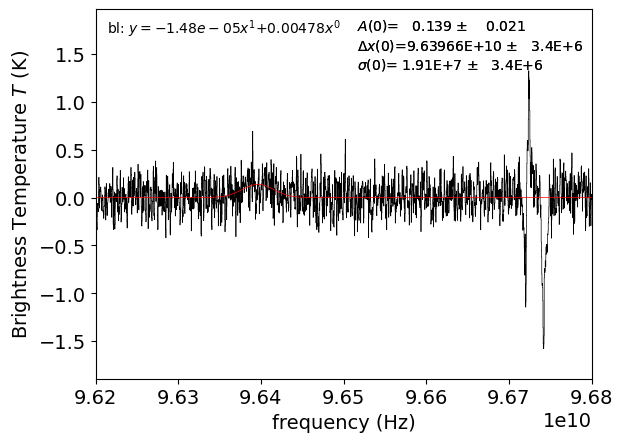

In [646]:
cube = c34scube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
spc34s = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

nurest_c34s21 = 96.412951*u.GHz

spc34s.data -= np.median(spc34s.data) # contsub
spc34s.plotter(xmin=96.2e9, xmax=96.8e9)
#spc34s.plotter(xmin=100.55e9, xmax=101.2e9)
spc34s.specfit(guesses=[0.006*JtoK, nurest_c34s21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (96.2e9, 97e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
spc34s.baseline(excludefit=True)
spc34s.specfit(guesses=[0.006*JtoK, nurest_c34s21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (96.2e9, 97e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
measurement_table.append(['C34S 2-1 (2012)', nurest_c34s21.to(u.Hz).value] + list(zip(spc34s.specfit.parinfo.values[:3], spc34s.specfit.parinfo.errors[:3])))
print(spc34s.specfit.fitter.parinfo,
      "\n Velocity width sigma(C34S) =",
      spc34s.specfit.parinfo['WIDTH0'].value/spc34s.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(C34S) = ",
      2.35*spc34s.specfit.parinfo['WIDTH0'].value/spc34s.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(C34s): ",
      -(spc34s.specfit.parinfo['SHIFT0'].value - nurest_c34s21.to(u.Hz).value) / nurest_c34s21.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spc34s.specfit.parinfo['AMPLITUDE0'].value / spc34s.specfit.parinfo['AMPLITUDE0'].error
     )

## Tsuboi CS

In [647]:
cscube_2012 = [scube for scube in scubes2012 if scube.spectral_axis.min() < nurest_cs21 and scube.spectral_axis.max() > nurest_cs21][0]
cscube_2012

VaryingResolutionSpectralCube with shape=(3840, 60, 60) and unit=Jy / beam:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 97512362524.760 Hz:98449559739.802 Hz

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.538484 +/-       0.0274834   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.79676e+10 +/-     1.14218e+06   Range:[9.77e+10,9.83e+10]
Param #2       WIDTH0 =  2.20131e+07 +/-     1.06991e+06   Range: [0,4e+07]
Param #3   AMPLITUDE1 =     -1.10444 +/-       0.0718508   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.79842e+10 +/-          152122   Range:[9.77e+10,9.83e+10]
Param #5       WIDTH1 =  2.07609e+06 +/-          163847   Range: [0,4e+07]
Param #6   AMPLITUDE2 =     -1.17159 +/-        0.105372   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.79604e+10 +/-          116987   Range:[9.77e+10,9.83e+10]
Param #8       WIDTH2 =       961798 +/-          123409   Range: [0,4e+07]
Param #9   AMPLITUDE3 =      1.41337 +/-        0.101357   Ra

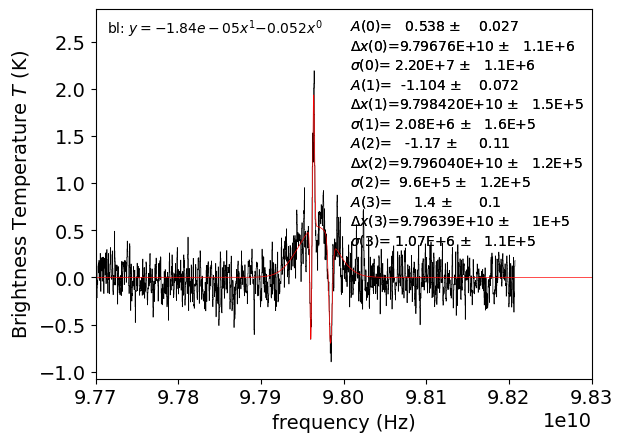

In [648]:
cube = cscube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
spcs = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

spcs.data -= np.median(spcs.data) # contsub
spcs.plotter(xmin=97.7e9, xmax=98.3e9)
#spcs.plotter(xmin=100.55e9, xmax=101.2e9)
spcs.specfit(guesses=[0.006*JtoK, nurest_cs21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
spcs.baseline(excludefit=True)
spcs.specfit(guesses=[0.006*JtoK, nurest_cs21.to(u.Hz).value, 1e7, 
                      -0.5, 97.985e9, 1e6, # absorption feature
                      -0.5, 97.96e9, 1e6, # absorption feature
                      0.5, 97.965e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['CS 2-1 (2012)', nurest_cs21.to(u.Hz).value] + list(zip(spcs.specfit.parinfo.values[:3], spcs.specfit.parinfo.errors[:3])))
print(spcs.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS): ",
      -(spcs.specfit.parinfo['SHIFT0'].value - nurest_cs21.to(u.Hz).value) / nurest_cs21.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spcs.specfit.parinfo['AMPLITUDE0'].value / spcs.specfit.parinfo['AMPLITUDE0'].error
     )

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.129268 +/-       0.0146529   Range:[0,2.71404]
Param #1       SHIFT0 =  9.76974e+10 +/-     3.05842e+06   Range:[9.75e+10,9.81e+10]
Param #2       WIDTH0 =  2.33691e+07 +/-     3.05842e+06   Range: [0,4e+07] 
 Velocity width sigma(34so) = 71.7099340916204 km / s  FWHM(34so) =  168.51834511530794 km / s  VLSR(34so):  54.81998002212866 km / s  SNR :  8.822008338457298


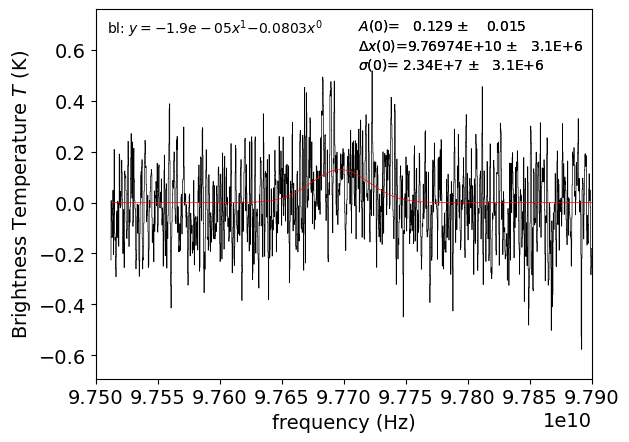

In [649]:
cube = cscube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
sp34so = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

sp34so.data -= np.median(sp34so.data) # contsub
sp34so.plotter(xmin=97.5e9, xmax=97.9e9)
#sp34so.plotter(xmin=100.55e9, xmax=101.2e9)
sp34so.specfit(guesses=[0.006*JtoK, nurest_34so32.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.5e9, 98.1e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
sp34so.baseline(excludefit=True)
sp34so.specfit(guesses=[0.006*JtoK, nurest_34so32.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.5e9, 98.1e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
measurement_table.append(['34SO 2(3)-1(2) (2012)', nurest_34so32.to(u.Hz).value] + list(zip(sp34so.specfit.parinfo.values[:3], sp34so.specfit.parinfo.errors[:3])))
print(sp34so.specfit.fitter.parinfo,
      "\n Velocity width sigma(34so) =",
      sp34so.specfit.parinfo['WIDTH0'].value/sp34so.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(34so) = ",
      2.35*sp34so.specfit.parinfo['WIDTH0'].value/sp34so.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(34so): ",
      -(sp34so.specfit.parinfo['SHIFT0'].value - nurest_34so32.to(u.Hz).value) / nurest_34so32.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", sp34so.specfit.parinfo['AMPLITUDE0'].value / sp34so.specfit.parinfo['AMPLITUDE0'].error
     )

## Spectral Measurement Table

In [650]:
latexdict = latex_info.latexdict.copy()
latexdict['header_start'] = r'\label{tab:spectral_measurements}'
latexdict['caption'] = 'Spectral Line Measurements'
latexdict['preamble'] = r'\centering'
latexdict['tablefoot'] = '''\par\nThe columns with $\sigma$ values give the uncertainty on their neighbors (e.g., $\sigma_A$ is the uncertainty on the amplitude).
All values are from Gaussian fits to the line profile, so the widths are the Gaussian width parameter, not the FWHM.
'''
formats = {'Amplitude': lambda x: "{0:0.3f}".format(x),
           'Amp': lambda x: "{0:0.3f}".format(x),
           'Center': lambda x: "{0:0.4f}".format(x),
           'Velocity Center': lambda x: "{0:0.3f}".format(x),
           '$v_{cen}$': lambda x: "{0:0.1f}".format(x),
           'Width [freq]': lambda x: "{0:0.3f}".format(x),
           'Width [vel]': lambda x: "{0:0.1f}".format(x),
           'FWHM [freq]': lambda x: "{0:0.3f}".format(x),
           'FWHM [vel]': lambda x: "{0:0.1f}".format(x),
           'FWHM': lambda x: "{0:0.1f}".format(x),
           'Rest Frequency': lambda x: "{0:0.6f}".format(x),
           'Rest Freq': lambda x: "{0:0.6f}".format(x),
           '$\sigma_{A}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{\nu,cen}$': lambda x: "{0:0.4f}".format(x),
           r'$\sigma_{\sigma_\nu}$': lambda x: "{0:0.1f}".format(x),
           r'$\sigma_{FWHM_\nu}$': lambda x: "{0:0.1f}".format(x),
           r'$\sigma_{v,cen}$': lambda x: "{0:0.1f}".format(x),
           r'$\sigma_{\sigma_v}$': lambda x: "{0:0.1f}".format(x),
           r'$\sigma_{FWHM_v}$': lambda x: "{0:0.1f}".format(x),
           r'$\sigma_{FWHM}$': lambda x: "{0:0.1f}".format(x),
          }

In [651]:
meastable = Table(list(zip(*measurement_table)),
      names=('Line', 'Rest Frequency', 'Amplitude / Error', 'Center / Error', 'Width / Error')
     )
vcen = (meastable['Rest Frequency'] - meastable['Center / Error'][:,0]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
evcen = (meastable['Center / Error'][:,1]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
width = (meastable['Width / Error'][:,0]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
ewidth = (meastable['Width / Error'][:,1]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
meastable.add_column(vcen, name="Velocity Center")
meastable.add_column(vcen, name="$v_{cen}$")
meastable.add_column(evcen, name="e_vcen")
meastable.add_column(width, name="Width (sigma)")
meastable.add_column(ewidth, name="e_width")

meastable['Rest Frequency'].unit = u.Hz
meastable['Rest Freq'] = meastable['Rest Frequency'].to(u.GHz)
meastable['Amplitude / Error'].unit = u.K
meastable['Center / Error'].unit = u.Hz
meastable['Width / Error'].unit = u.Hz

meastable['Amp'] = meastable['Amplitude / Error'][:,0]
meastable[r'$\sigma_{A}$'] = meastable['Amplitude / Error'][:,1]
#meastable['Width [freq]'] = meastable['Width / Error'][:,0].to(u.MHz)
#meastable[r'$\sigma_{\sigma_\nu}$'] = meastable['Width / Error'][:,1].to(u.MHz)
meastable['FWHM [freq]'] = meastable['Width / Error'][:,0].to(u.MHz) * np.sqrt(8*np.log(2))
meastable[r'$\sigma_{FWHM_\nu}$'] = meastable['Width / Error'][:,1].to(u.MHz) * np.sqrt(8*np.log(2))

meastable['Center'] = meastable['Center / Error'][:,0].to(u.GHz)
meastable[r'$\sigma_{\nu,cen}$'] = meastable['Center / Error'][:,1].to(u.GHz)

meastable[r'$\sigma_{v,cen}$'] = meastable['e_vcen']
#meastable[r'Width [vel]'] = meastable['Width (sigma)']
#meastable[r'$\sigma_{\sigma_v}$'] = meastable['e_width']
meastable[r'FWHM'] = meastable[r'FWHM [vel]'] = meastable['Width (sigma)'] * np.sqrt(8*np.log(2))
meastable[r'$\sigma_{FWHM}$'] = meastable[r'$\sigma_{FWHM_v}$'] = meastable['e_width'] * np.sqrt(8*np.log(2))

meastable['Species'] = [x.replace("34", "$^{34}$").replace("SO2", "SO$_2$") for x in meastable['Line']]

selcols = ['Species', 'Rest Freq', 'Amp', '$\sigma_{A}$', 'Center', r'$\sigma_{\nu,cen}$',
           #'FWHM [freq]', r'$\sigma_{FWHM_\nu}$',
           '$v_{cen}$', r'$\sigma_{v,cen}$',
           #'FWHM [vel]', r'$\sigma_{FWHM_v}$',
           'FWHM', r'$\sigma_{FWHM}$',
          ]

meastable.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.ecsv', overwrite=True)
textable2fn = '/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.tex'
meastable[selcols].write(textable2fn, latexdict=latexdict, formats=formats, overwrite=True)

with open(textable2fn, 'r') as fh:
    tt2 = fh.read()
tt2 = tt2.replace('C$^{34}$S 2-1',
'''\hline \\\\
2012\\\\
\hline
'''+
                  'C$^{34}$S 2-1')
tt2 = tt2.replace('(2012)', '')
with open(textable2fn, 'w') as fh:
    fh.write(tt2)

meastable.add_index('Line')
meastable

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


Line,Rest Frequency,Amplitude / Error,Center / Error,Width / Error,Velocity Center,$v_{cen}$,e_vcen,Width (sigma),e_width,Rest Freq,Amp,$\sigma_{A}$,FWHM [freq],$\sigma_{FWHM_\nu}$,Center,"$\sigma_{\nu,cen}$","$\sigma_{v,cen}$",FWHM,FWHM [vel],$\sigma_{FWHM}$,$\sigma_{FWHM_v}$,Species
,Hz,K,Hz,Hz,km / s,km / s,km / s,km / s,km / s,GHz,K,K,MHz,MHz,GHz,GHz,km / s,km / s,km / s,km / s,km / s,
str21,float64,float64[2],float64[2],float64[2],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str26
CS 2-1,97980950000.0,1.0319974833517782 .. 0.043977500080947036,97965562285.56984 .. 1002871.3776631355,22833270.726318173 .. 923831.4061794706,47.081812658684086,47.081812658684086,3.068487041281777,69.86299229822093,2.826648323333667,97.98095,1.0319974833517782,0.043977500080947036,53.76824359995241,2.1754567135005463,97.96556228556985,0.0010028713776631356,3.068487041281777,164.51477466969348,164.51477466969348,6.656248132039243,6.656248132039243,CS 2-1
SO 2(3)-1(2),99299870000.0,1.748210227589565 .. 0.0250455114616628,99286584904.1418 .. 380559.86072609556,22673175.374950025 .. 363669.47098892083,40.10852725280928,40.10852725280928,1.1489337907815373,68.45172079602258,1.0979406580021531,99.29987000000001,1.748210227589565,0.0250455114616628,53.39124785743443,0.8563761600505121,99.2865849041418,0.0003805598607260956,1.1489337907815373,161.19148424733586,161.19148424733586,2.5854526697179403,2.5854526697179403,SO 2(3)-1(2)
34SO 2(3)-1(2),97715317000.0,0.21635256022327293 .. 0.023914645242543556,97703940084.13042 .. 2603077.114157526,20325743.175393812 .. 2722290.6956177014,34.90459508002756,34.90459508002756,7.986290280538427,62.359768092734484,8.352039824317005,97.71531700000001,0.21635256022327293,0.023914645242543556,47.86346745956836,6.41050469844181,97.70394008413042,0.002603077114157526,7.986290280538427,146.84603190825257,146.84603190825257,19.66755079519845,19.66755079519845,$^{34}$SO 2(3)-1(2)
SO 2(2)-1(1),86093950000.0,0.3828433591333181 .. 0.02616757824858611,86082902388.39613 .. 1536167.510134721,19464257.0217542 .. 1536167.4996166155,38.46949335873756,38.46949335873756,5.349173011146868,67.7775552834485,5.3491729745211964,86.09395,0.3828433591333181,0.02616757824858611,45.834822596461194,3.617398020622279,86.08290238839614,0.001536167510134721,5.349173011146868,159.60394578465787,159.60394578465787,12.596339744740341,12.596339744740341,SO 2(2)-1(1)
"SO2 2(2,0)-3(1,3)",100878105000.0,0.1715140035002676 .. 0.028675486053072772,100874782756.04788 .. 4796354.934347436,24842652.749088455 .. 4796354.913773259,9.873140266473737,9.873140266473737,14.253945741828183,73.82811097501965,14.253945680685254,100.878105,0.1715140035002676,0.028675486053072772,58.499976665296714,11.29455269403596,100.87478275604789,0.004796354934347436,14.253945741828183,173.85191561074572,173.85191561074572,33.56547700965996,33.56547700965996,"SO$_2$ 2(2,0)-3(1,3)"
C34S 2-1 (2012),96412951000.0,0.138535275049382 .. 0.021370432683407707,96396623397.53304 .. 3400937.9504353357,19092195.16160207 .. 3400937.9435881875,50.770067984105346,50.770067984105346,10.575089104642087,59.366465363272525,10.575089083351138,96.412951,0.138535275049382,0.021370432683407707,44.95868387018345,8.0085968414678,96.39662339753305,0.003400937950435336,10.575089104642087,139.7973426400697,139.7973426400697,24.902431751463226,24.902431751463226,C$^{34}$S 2-1 (2012)
CS 2-1 (2012),97980950000.0,0.5384838239451588 .. 0.027483372488065073,97967649265.22128 .. 1142176.9770166348,22013123.54149655 .. 1069911.2259513387,40.69627792461358,40.69627792461358,3.494720590184382,67.3535867407176,3.27360896449509,97.98095,0.5384838239451588,0.027483372488065073,51.83694456925875,2.5194484012738494,97.96764926522128,0.0011421769770166349,3.494720590184382,158.60557616177258,158.60557616177258,7.708760009186047,7.708760009186047,CS 2-1 (2012)
34SO 2(3)-1(2) (2012),97715317000.0,0.12926820043555054 .. 0.0146529220418

In [652]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.tex

\begin{table*}[htp]
\centering
\caption{Spectral Line Measurements}
\begin{tabular}{cccccccccc}
\label{tab:spectral_measurements}
Species & Rest Freq & Amp & $\sigma_{A}$ & Center & $\sigma_{\nu,cen}$ & $v_{cen}$ & $\sigma_{v,cen}$ & FWHM & $\sigma_{FWHM}$ \\
 & $\mathrm{GHz}$ & $\mathrm{K}$ & $\mathrm{K}$ & $\mathrm{GHz}$ & $\mathrm{GHz}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ \\
\hline
CS 2-1 & 97.980950 & 1.032 & 0.044 & 97.9656 & 0.0010 & 47.1 & 3.1 & 164.5 & 6.7 \\
SO 2(3)-1(2) & 99.299870 & 1.748 & 0.025 & 99.2866 & 0.0004 & 40.1 & 1.1 & 161.2 & 2.6 \\
$^{34}$SO 2(3)-1(2) & 97.715317 & 0.216 & 0.024 & 97.7039 & 0.0026 & 34.9 & 8.0 & 146.8 & 19.7 \\
SO 2(2)-1(1) & 86.093950 & 0.383 & 0.026 & 86.0829 & 0.0015 & 38.5 & 5.3 & 159.6 & 12.6 \\
SO$_2$ 2(2,0)-3(1,3) & 100.878105 & 0.172 & 0.029 & 100.8748 & 0.0048 & 9.9 & 14.3 & 173.9 & 33.6 \\
\hline \\
2012\\
\hline
C$^{34}$S 2-1  & 96.412951 & 0.139 & 0.021 & 96.3966 & 0.0034 & 

In [653]:
cstoc34s = meastable.loc['CS 2-1']['Amplitude / Error'][0] / meastable.loc['C34S 2-1 (2012)']['Amplitude / Error'][0]
soto34so = meastable.loc['SO 2(3)-1(2)']['Amplitude / Error'][0] / meastable.loc['34SO 2(3)-1(2)']['Amplitude / Error'][0]
cstoc34s, soto34so

(7.449348066648833, 8.080376889394957)

In [654]:
# from wikipedia, ratio of 32S/34S
94.93/4.29

22.12820512820513

# Search for spatial gradients

## Separate background

In [655]:
background_stddevs = [cube.subcube_from_regions([annulus]).std(axis=(1,2)) for cube in cubes]
background_means = [cube.subcube_from_regions([annulus]).mean(axis=(1,2)) for cube in cubes]

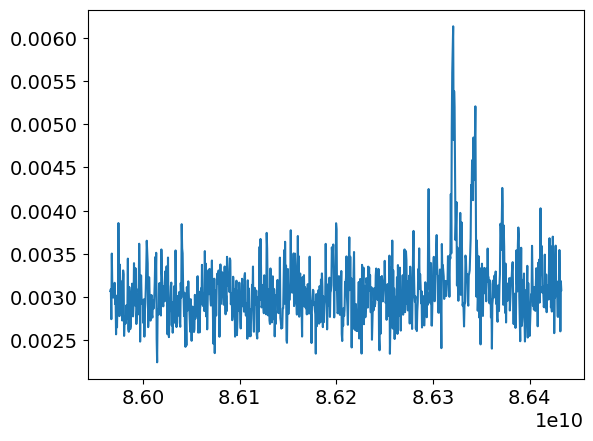

In [656]:
pl.plot(background_stddevs[0].spectral_axis, background_stddevs[0].value)

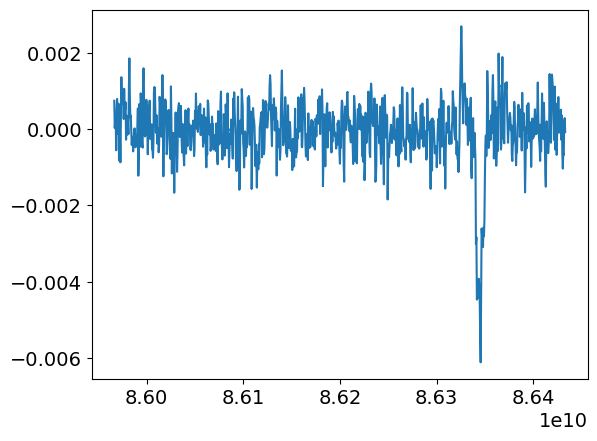

In [657]:
pl.plot(background_means[0].spectral_axis, background_means[0].value)

## Fitting channel-by-channel

In [658]:
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [659]:
so_scube = scubes[-2].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz).spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_scube

DaskSpectralCube with shape=(408, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    408  type_s: VRAD      unit_s: km / s  range:     -300.055 km / s:     299.963 km / s

In [660]:
rows = []
for chan in range(so_scube.shape[0]):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    g = fit_g(g_init, x, y, z=so_scube[chan, :, :].value, weights=1/stats.mad_std(so_scube[chan, :, :]))
    rows.append(list(g.parameters) +
                (list(fit_g.fit_info['param_cov'].diagonal()**0.5) if fit_g.fit_info['param_cov'] is not None else [np.nan]*len(g.parameters)) )
    #print(chan, g.parameters)
tb = Table(np.array(rows), names=list(g.param_names) + list(map(lambda x: f'e_{x}', g.param_names)))

invalid value encountered in sqrt
invalid value encountered in sqrt


In [661]:
tb = Table(np.array(rows), names=list(g.param_names) + list(map(lambda x: f'e_{x}', g.param_names)))

In [662]:
# empirical: 15-sigma needed to be reliable
(tb['amplitude']/tb['e_amplitude'] > 15).sum()

132

In [663]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
# I swear something is wrong with this math.  The area of a Gaussian is 2 pi sigma_a sigma_b, so the error should be 2 pi (sigma_a^2 * b^2 + sigma_b^2 * a^2)**0.5, but empirically the S/N is wrong if the 2 is on the outside...
fitarea = 2*np.pi*tb['x_stddev']*tb['y_stddev']*pixarea_soscube
e_fitarea = np.pi*(2*((tb['e_x_stddev']*tb['y_stddev'])**2 + (tb['e_y_stddev']*tb['x_stddev'])**2))**0.5 * pixarea_soscube
((np.abs(fitarea - so_scube.beam.sr) / e_fitarea > 2) & (tb['amplitude'] / tb['e_amplitude'] > 15)).sum()

113

In [664]:
# signal-to-noise in fitted area
fitarea/e_fitarea

<Quantity [9.55997941e+00, 8.77508166e+00,            nan,            nan,
           2.79998101e-38, 1.06012268e-38, 5.82422605e+00, 3.34607088e+00,
                      nan,            nan, 6.21770993e+00, 8.64904962e+00,
                      nan, 3.12067789e-38, 5.45679492e-39, 1.36100290e-38,
           6.42501216e+00, 1.13519926e+01, 6.80901691e+00, 6.59134382e+00,
           9.82395335e+00,            nan, 5.85002822e+00, 8.45765685e+00,
           1.29465783e-38, 2.41587265e-38, 1.24871123e-39, 2.07482139e-39,
                      nan,            nan, 7.35236380e+00, 6.86215348e+00,
           8.20395205e+00, 6.72625309e+00, 1.75126224e-38, 1.27095948e+01,
           7.67535087e+00, 7.49020545e+00, 6.15575091e+00, 4.48956019e+00,
           1.98021195e-37, 2.62943375e-38, 3.15717418e-38, 1.26147459e+01,
           8.31091384e+00, 1.17734314e-38, 2.09130786e-38, 1.33057394e+01,
           1.07272506e+01, 1.05554311e+01, 7.94660243e-42, 1.27738626e-38,
           6.78656351e+00

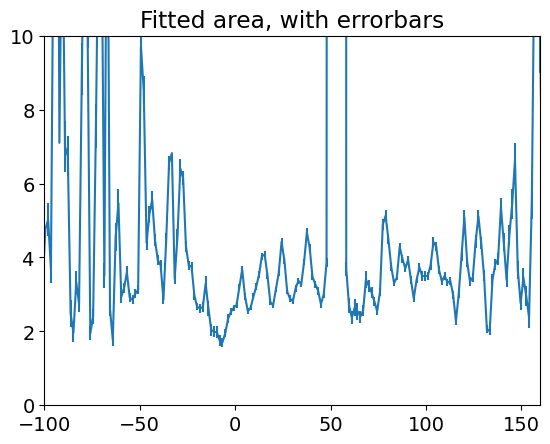

In [665]:
pl.title("Fitted area, with errorbars")
pl.errorbar(so_scube.spectral_axis.value, fitarea.to(u.arcsec**2), yerr=e_fitarea.to(u.arcsec**2))
pl.ylim(0, 10)
pl.xlim(-100, 160);

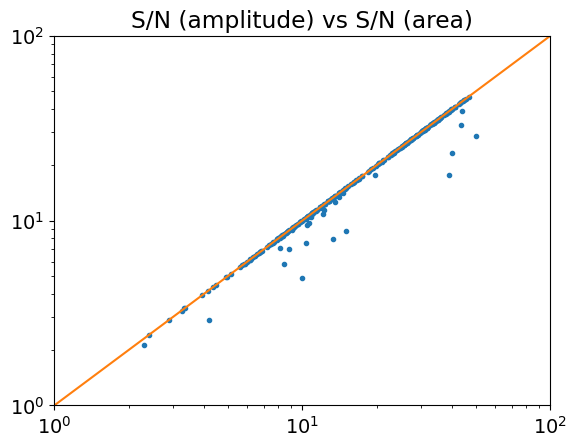

In [666]:
#DIAGNOSTIC
pl.title("S/N (amplitude) vs S/N (area)")
pl.loglog(tb['amplitude'] / tb['e_amplitude'], fitarea / e_fitarea , '.')
pl.plot([1,100], [1,100])
pl.ylim(1, 100);
pl.xlim(1, 100);

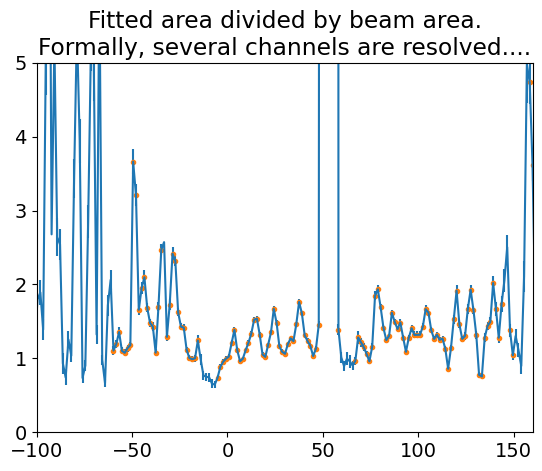

In [667]:
detected = (tb['amplitude']/tb['e_amplitude'] > 15)
# err = (sigma / fit) * (fit/reference) ; fit cancels out
pl.errorbar(so_scube.spectral_axis.value, fitarea.to(u.sr) / so_scube.beam.sr, yerr=(e_fitarea.to(u.sr) / so_scube.beam.sr))
pl.plot(so_scube.spectral_axis.value[detected], (fitarea.to(u.sr) / so_scube.beam.sr)[detected], marker='.', linestyle='none')
pl.xlim(-100, 160);
pl.ylim(0, 5);
pl.title("Fitted area divided by beam area.\nFormally, several channels are resolved....");

In [668]:
# try again averaging 10 channels
# I did this twice (oops): ### Try again downsampled (higher S/N)
rows = []
for chan in range(0, so_scube.shape[0], 10):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    data = so_scube[chan:chan+10, :, :].moment0(axis=0).value
    g = fit_g(g_init, x, y, z=data, weights=1/stats.mad_std(data))
    rows.append(np.array([so_scube.spectral_axis[chan:chan+10].mean().value] + list(g.parameters) + (list(fit_g.fit_info['param_cov'].diagonal()**0.5) if fit_g.fit_info['param_cov'] is not None else [np.nan]*len(g.parameters)) ))
    #print(chan, g.parameters)
tb_avg = Table(np.array(rows), names=['Velocity'] + list(g.param_names) + list(map(lambda x: f'e_{x}', g.param_names)))

In [669]:
(tb_avg['amplitude']/tb_avg['e_amplitude'] > 5).sum()

34

In [670]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
fitarea_avg = 2*np.pi*tb_avg['x_stddev']*tb_avg['y_stddev']*pixarea_soscube
e_fitarea_avg = (2*np.pi*((tb_avg['e_x_stddev']*tb_avg['y_stddev'])**2 + (tb_avg['e_y_stddev']*tb_avg['x_stddev'])**2))**0.5 * pixarea_soscube
((np.abs(fitarea_avg - so_scube.beam.sr) / e_fitarea_avg > 2) & (tb_avg['amplitude'] / tb_avg['e_amplitude'] > 15)).sum()

16

In [671]:
%matplotlib inline
import pylab as pl

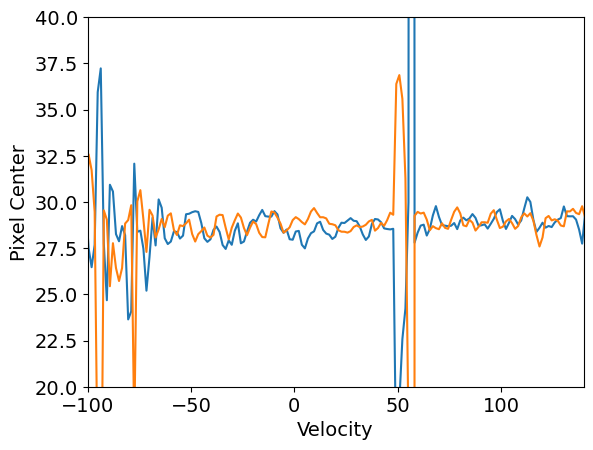

In [672]:
pl.plot(so_scube.spectral_axis.value, tb['x_mean'], label='X center (pixels)')
pl.plot(so_scube.spectral_axis.value, tb['y_mean'], label='Y center (pixels)')
pl.ylim(20, 40);
pl.xlim(-100, 140);
pl.xlabel("Velocity");
pl.ylabel("Pixel Center");

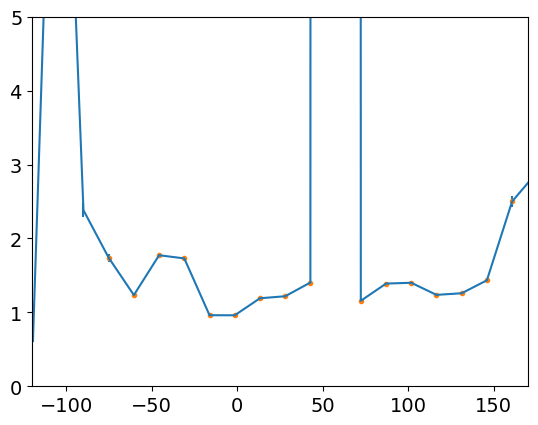

In [673]:
detected = (tb_avg['amplitude']/tb_avg['e_amplitude'] > 15)
# err = (sigma / fit) * (fit/reference) ; fit cancels out
pl.errorbar(tb_avg['Velocity'], fitarea_avg.to(u.sr) / so_scube.beam.sr, yerr=(e_fitarea_avg.to(u.sr) / so_scube.beam.sr))
pl.plot(tb_avg['Velocity'][detected], (fitarea_avg.to(u.sr) / so_scube.beam.sr)[detected], marker='.', linestyle='none')
pl.xlim(-120, 170);
pl.ylim(0, 5);

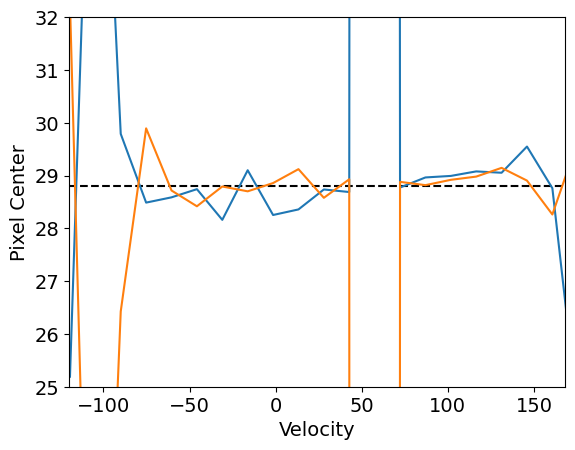

In [674]:
pl.plot(tb_avg['Velocity'], tb_avg['x_mean'], label='X center (pixels)')
pl.plot(tb_avg['Velocity'], tb_avg['y_mean'], label='Y center (pixels)')
pl.ylim(25, 32);
pl.xlim(-120, 168);
pl.axhline(28.8, linestyle='--', color='k', zorder=-10)
pl.xlabel("Velocity");
pl.ylabel("Pixel Center");

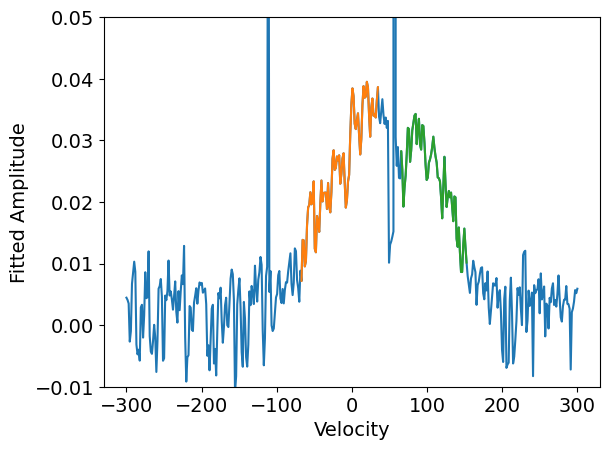

In [675]:
pl.plot(so_scube.spectral_axis.value, tb['amplitude'])
pl.plot(so_scube.spectral_axis.value[180:250], tb['amplitude'][180:250])
pl.plot(so_scube.spectral_axis.value[100:160], tb['amplitude'][100:160])
pl.ylim([-0.01, 0.05]);
pl.ylabel("Fitted Amplitude")
pl.xlabel("Velocity");

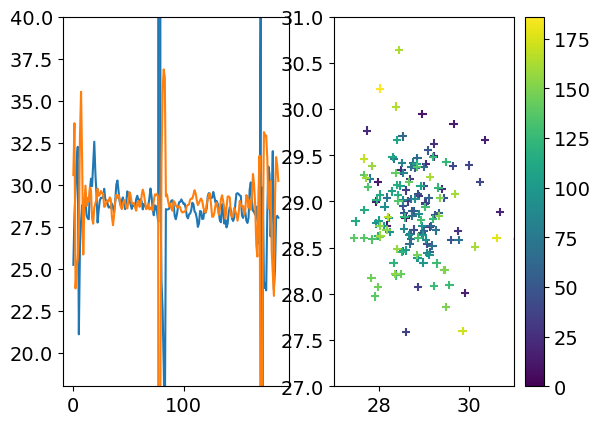

In [676]:
sel = tb['amplitude'] > 0.008
pl.subplot(1,2,1)
pl.plot(tb['x_mean'][sel])
pl.plot(tb['y_mean'][sel])
pl.ylim(18, 40);
pl.subplot(1,2,2)
pl.scatter(tb['x_mean'][sel], tb['y_mean'][sel], c=np.arange(len(tb[sel])), marker='+')
pl.colorbar()
pl.axis([27,31,27,31]);

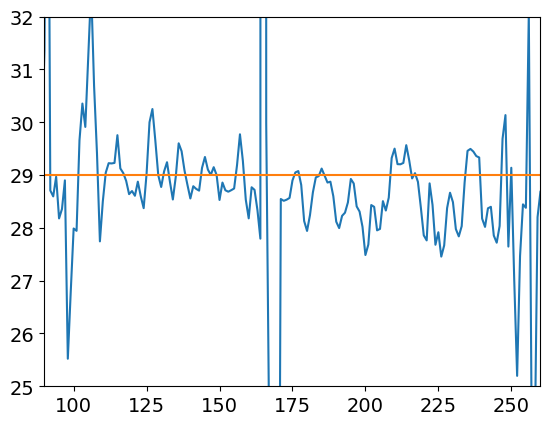

In [677]:
pl.plot(tb['x_mean'])
pl.plot([0,400], [29, 29])
pl.ylim(25, 32);
pl.xlim(90,260);

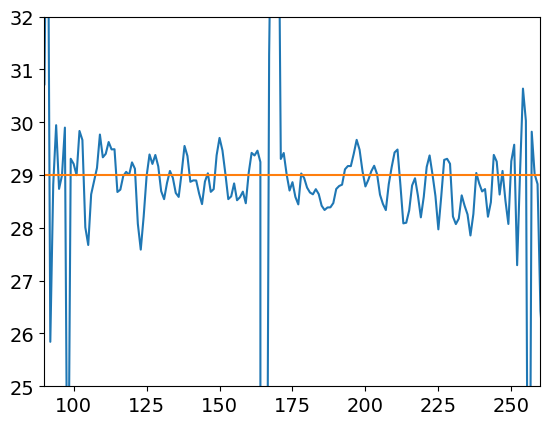

In [678]:
pl.plot(tb['y_mean'])
pl.plot([0,400], [29, 29])
pl.ylim(25, 32);
pl.xlim(90,260);

In [679]:
pixscale = so_scube.wcs.celestial.proj_plane_pixel_scales()[0].to(u.arcsec)
pixscale

<Quantity 0.26 arcsec>

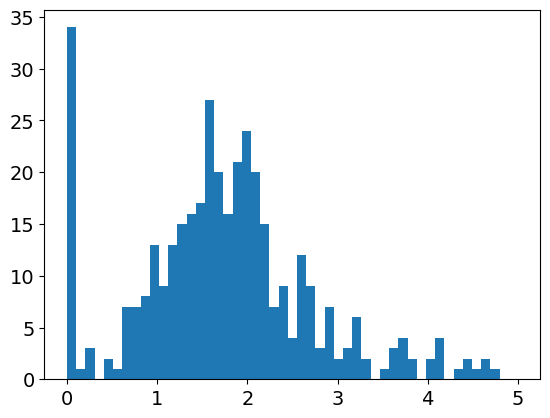

In [680]:
pl.hist(tb['x_stddev']*pixscale.value*2.35, bins=np.linspace(0,5));

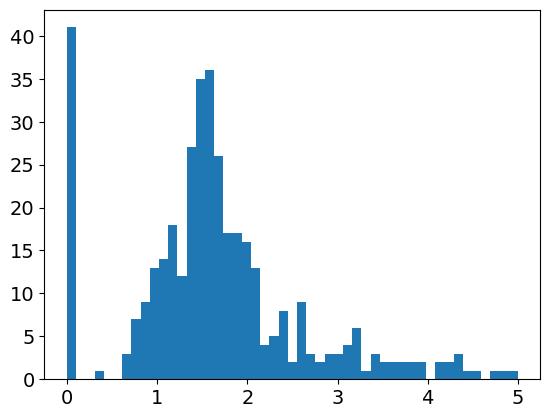

In [681]:
pl.hist(tb['y_stddev']*pixscale.value*2.35, bins=np.linspace(0,5));

### Fit red and blue sides

In [682]:
pixscale_so = so_scube.wcs.celestial.proj_plane_pixel_area()**0.5
sig2fwhm = np.sqrt(8*np.log(2))

(<Quantity 1.75846813 arcsec>,
 <Quantity 1.58360147 arcsec>,
 <Gaussian2D(amplitude=0.02563195, x_mean=28.54175745, y_mean=28.78748886, x_stddev=2.87801657, y_stddev=2.5918191, theta=0.17038562)>,
 <Quantity 34.59907725 km / s>,
 <Quantity -68.59815164 km / s>,
 <Quantity -7.67024943 km / s>)

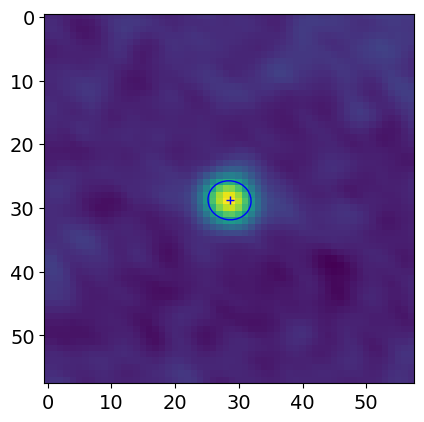

In [683]:
avgim_blue = so_scube[180:250].mean(axis=0)
avgim_blue.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
blue_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
blue_gfit = g = blue_fit_g(g_init, x, y, z=avgim_blue.value, weights=1/stats.mad_std(avgim_blue.value))
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')

src_blue = radio_beam.Beam(major=blue_gfit.x_stddev*pixscale_so*sig2fwhm,
                           minor=blue_gfit.y_stddev*pixscale_so*sig2fwhm,
                           pa=90*u.deg+blue_gfit.theta*u.rad)
ell = src_blue.ellipse_to_plot(blue_gfit.x_mean, blue_gfit.y_mean, pixscale_so)
ell.set_facecolor('none')
ell.set_edgecolor('blue')
pl.gca().add_artist(ell)

(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 so_scube.spectral_axis[180], so_scube.spectral_axis[250],
 so_scube[180:250].moment1(axis=0)[int(blue_gfit.y_mean.value), int(blue_gfit.x_mean.value)])

(<Quantity 1.87605015 arcsec>,
 <Quantity 1.61167424 arcsec>,
 <Gaussian2D(amplitude=0.0235422, x_mean=29.00403352, y_mean=28.92198709, x_stddev=3.07045852, y_stddev=2.63776472, theta=0.47884723)>,
 <Quantity 152.5387674 km / s>,
 <Quantity 64.08399979 km / s>,
 <Quantity 103.77683546 km / s>)

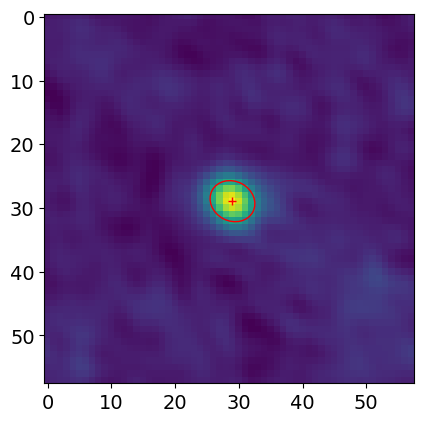

In [684]:
avgim_red = so_scube[100:160].mean(axis=0)
avgim_red.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
red_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
red_gfit = g = red_fit_g(g_init, x, y, z=avgim_red.value, weights=1/stats.mad_std(avgim_red.value))

src_red = radio_beam.Beam(major=red_gfit.x_stddev*pixscale_so*sig2fwhm,
                           minor=red_gfit.y_stddev*pixscale_so*sig2fwhm,
                           pa=90*u.deg+red_gfit.theta*u.rad)
ell = src_red.ellipse_to_plot(red_gfit.x_mean, red_gfit.y_mean, pixscale_so)
ell.set_facecolor('none')
ell.set_edgecolor('red')
pl.gca().add_artist(ell)

pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 so_scube.spectral_axis[100], so_scube.spectral_axis[160],
 so_scube[100:160].moment1(axis=0)[int(red_gfit.y_mean.value), int(red_gfit.x_mean.value)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


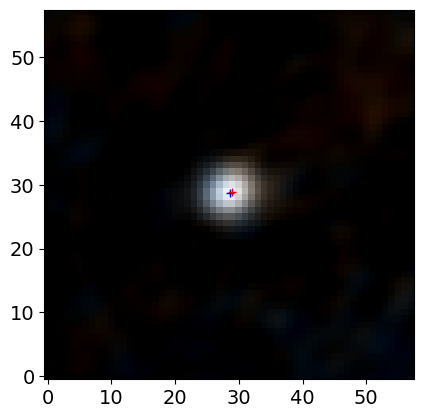

In [685]:
rgbim = np.array([avgim_red, (avgim_red+avgim_blue)/2., avgim_blue]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')

In [686]:
redbluesep = ((blue_gfit.x_mean - red_gfit.x_mean)**2 + (blue_gfit.y_mean - red_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(red_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(blue_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redbluesep, uncertainty, redbluesep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redbluesep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.48144464227550166,
 0.057005103356524166,
 <Quantity 0.12517561 arcsec>,
 <Quantity 0.01482133 arcsec>,
 <Quantity 1063.99265943 AU>,
 <Quantity 125.98127842 AU>)

In [687]:
# for estimating contour levels
avgim_blue.max()

<Projection 0.0252627 Jy / beam>

In [688]:
stats.mad_std(avgim_blue)

<Quantity 0.00087607 Jy / beam>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


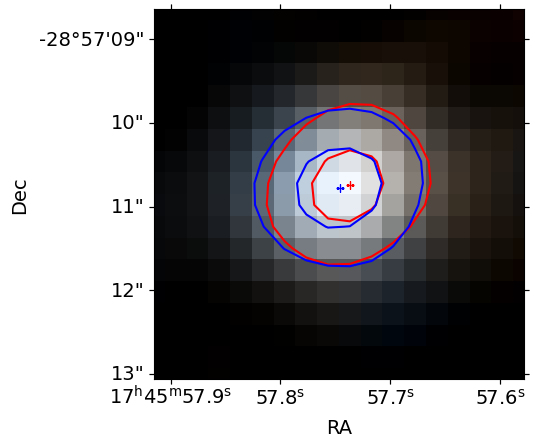

In [690]:
rgbim = np.array([avgim_red, (avgim_red+avgim_blue)/2., avgim_blue]).T.swapaxes(0,1)
rgbim /= rgbim.max()
ax = pl.subplot(projection=so_scube.wcs.celestial)
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')
pl.contour(avgim_red, colors=['r', 'r'], levels=[0.01,0.02])
pl.contour(avgim_blue, colors=['b', 'b'], levels=[0.01,0.02])
pl.axis([20,37,20,37]);
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SOmoment_red_and_blue.pdf', bbox_inches='tight')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SOmoment_red_and_blue.png', bbox_inches='tight')

In [691]:
coord_fit = so_scube.wcs.celestial.pixel_to_world(g.x_mean, g.y_mean)
coord_fit, coord_fit.to_string('hmsdms'), coord_fit.galactic

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.49056907, -28.95298356)>,
 '17h45m57.73657771s -28d57m10.74080944s',
 <SkyCoord (Galactic): (l, b) in deg
     (0.02464964, -0.07268737)>)

In [692]:
import radio_beam
# wouldn't deconvolve with theta as set; rotated 90 deg (probably not right?)

# this isn't a meaningful fit; the red/blue are meaningful.  Later on, the continuum fit should do the same...
#src = radio_beam.Beam(major=g.x_stddev*pixscale*2.35, minor=g.y_stddev*pixscale*2.35, pa=90*u.deg+g.theta*u.rad)
#src, so_scube.beam, src.deconvolve(so_scube.beam)

In [693]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
fitarea_blue = 2*np.pi*blue_gfit.x_stddev*blue_gfit.y_stddev*pixarea_soscube
e_blue_amplitude = blue_fit_g.fit_info['param_cov'].diagonal()[0]**0.5
e_x_stddev_blue = blue_fit_g.fit_info['param_cov'].diagonal()[3]**0.5
e_y_stddev_blue = blue_fit_g.fit_info['param_cov'].diagonal()[4]**0.5
e_fitarea_blue = (2*np.pi*((e_x_stddev_blue*blue_gfit.y_stddev)**2 + (e_y_stddev_blue*blue_gfit.x_stddev)**2))**0.5 * pixarea_soscube
(np.abs(fitarea_blue - so_scube.beam.sr) / e_fitarea_blue ), (blue_gfit.amplitude / e_blue_amplitude), (fitarea_blue / so_scube.beam.sr).decompose()

(<Quantity 28.93664309>, 100.14939988461762, <Quantity 1.19476156>)

In [694]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
fitarea_red = 2*np.pi*red_gfit.x_stddev*red_gfit.y_stddev*pixarea_soscube
e_red_amplitude = red_fit_g.fit_info['param_cov'].diagonal()[0]**0.5
e_x_stddev_red = red_fit_g.fit_info['param_cov'].diagonal()[3]**0.5
e_y_stddev_red = red_fit_g.fit_info['param_cov'].diagonal()[4]**0.5
e_fitarea_red = (2*np.pi*((e_x_stddev_red*red_gfit.y_stddev)**2 + (e_y_stddev_red*red_gfit.x_stddev)**2))**0.5 * pixarea_soscube
(np.abs(fitarea_red - so_scube.beam.sr) / e_fitarea_red ), (red_gfit.amplitude / e_red_amplitude), (fitarea_red / so_scube.beam.sr).decompose()

(<Quantity 39.25379824>, 96.65546540157992, <Quantity 1.29724665>)

In [695]:
pixscale_so = so_scube.wcs.celestial.proj_plane_pixel_area()**0.5

In [696]:
sig2fwhm = np.sqrt(8*np.log(2))

In [697]:
src_blue, so_scube.beam, src_blue.deconvolve(so_scube.beam)

(Beam: BMAJ=1.7620748890720797 arcsec BMIN=1.586849568267717 arcsec BPA=99.76237710482134 deg,
 Beam: BMAJ=1.6255785371840412 arcsec BMIN=1.4396964064791222 arcsec BPA=-52.087786316534505 deg,
 Beam: BMAJ=0.8525352340807809 arcsec BMIN=0.42538431832918944 arcsec BPA=69.62574283926001 deg)

In [698]:
src_red, so_scube.beam, src_red.deconvolve(so_scube.beam)

(Beam: BMAJ=1.8798980889065815 arcsec BMIN=1.6149799214172502 arcsec BPA=117.43592555965988 deg,
 Beam: BMAJ=1.6255785371840412 arcsec BMIN=1.4396964064791222 arcsec BPA=-52.087786316534505 deg,
 Beam: BMAJ=0.9670292792695546 arcsec BMIN=0.7012845506007191 arcsec BPA=-76.24391199209754 deg)

### Source fit leads to 1.5" size scale (so, beam-sized) - but it can deconvolve to ~0.8"

### Try again downsampled (higher S/N)

In [699]:
so_scube_ds = so_scube.downsample_axis(factor=10, axis=0)
so_scube_ds

In some cases, the final shape of the output from downsample_axis is incorrect, so use the result with caution


DaskSpectralCube with shape=(41, 58, 58) and unit=Jy / beam and chunk size (6, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:     41  type_s: VRAD      unit_s: km / s  range:     -296.369 km / s:     293.329 km / s

In [700]:
rows = []
for chan in range(so_scube_ds.shape[0]):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    g = fit_g(g_init, x, y, z=so_scube[chan, :, :].value)
    rows.append(g.parameters)
    #print(chan, g.parameters)
tb2 = Table(np.array(rows), names=g.param_names)
tb2

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta
float64,float64,float64,float64,float64,float64
0.005905585860934528,26.328576906592797,34.62835040278195,2.223591493629204,6.143321726898192,1.4044253533118467
0.0051844463456161205,31.643804508650515,32.155286780698,8.430427514228322,1.617510322407969,-0.19444014117558736
0.005680080658306295,32.37743393773512,30.79586320983435,6.201328799229736,1.8372987093384185,0.01925491221517151
0.004466647678453937,34.49168760886746,28.42773038878257,6.863433086440286,1.6633525742944029,-0.41298774500885754
0.0026836125945029453,29.199514876698476,28.43392904383554,2.8346325397063814,1.1754943508222875e-38,-0.4846850113170254
0.0021286195737177833,29.669661772152843,24.388187229793648,1.4153751884510877,1.1754943508222875e-38,-0.02069692356870769
-0.0013055802129225426,28.703801048226392,22.764780298104306,3.589776841664849,1.1754943508222875e-38,-0.009950217987713233
0.0026761589337948545,23.191125618972922,30.54714951389411,6.259404232251199,1.4011830145973465,-0.1263525824965948
0.006269812709827055,34.92395995124469,31.176221997470012,4.516466183308611,1.454413298532732,0.36178613243530244


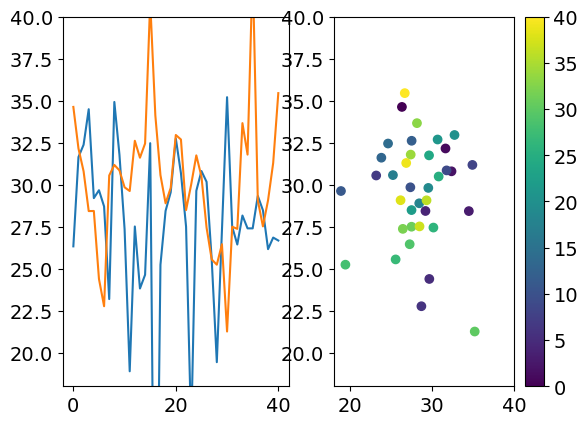

In [701]:
pl.subplot(1,2,1)
pl.plot(tb2['x_mean'])
pl.plot(tb2['y_mean'])
pl.ylim(18, 40);
pl.subplot(1,2,2)
pl.scatter(tb2['x_mean'], tb2['y_mean'], c=np.arange(len(tb2)))
pl.colorbar()
pl.axis([18,40,18,40]);

## Repeat fits for CS - see if consistent

In [702]:
cs_scube = (scubes[-2]
            .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
            .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
cs_scube

DaskSpectralCube with shape=(402, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s

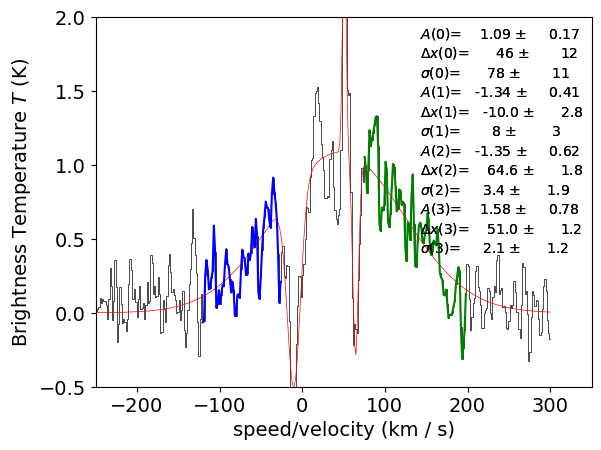

In [703]:
xx, yy = cs_scube.wcs.celestial.world_to_pixel(coord)
csspec = pyspeckit.Spectrum.from_hdu(cs_scube[:, int(yy), int(xx)].to(u.K).hdu)
csspec.xarr.convert_to_unit(u.GHz)
csspec.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_cs21)
csspec.plotter(xmin=-250, xmax=350)
csspec.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, 1, 55, 4])
red = csspec.slice(75, 200, unit=u.km/u.s)
pl.plot(red.xarr.value, red.data, color='g')
blue = csspec.slice(-120, -25, unit=u.km/u.s)
pl.plot(blue.xarr.value, blue.data, color='b')
pl.ylim(-0.5,2);

In [704]:
g_init.x_stddev.bounds

(1.1754943508222875e-38, None)

(<Quantity 1.81051129 arcsec>,
 <Quantity 2.10127098 arcsec>,
 <Gaussian2D(amplitude=0.00628209, x_mean=27.67804703, y_mean=28.645654, x_stddev=2.96319359, y_stddev=3.43906871, theta=5.89771595)>,
 <Quantity -60.72401402 km / s>)

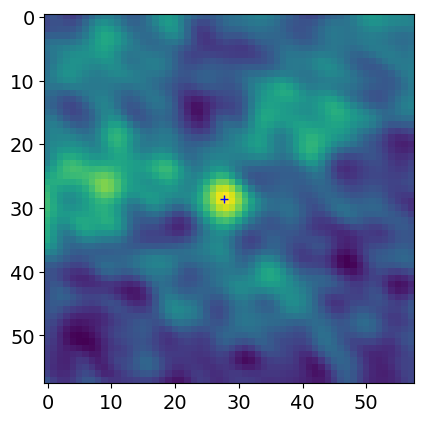

In [705]:
blue_cs_scube = cs_scube.subcube_from_regions([region]).spectral_slab(-120*u.km/u.s, -25*u.km/u.s)
avgim_bluecs = blue_cs_scube.mean(axis=0)
avgim_bluecs.quicklook()
g_init = Gaussian2D(amplitude=0.02, x_mean=29.1, y_mean=29.1, x_stddev=3., y_stddev=3)
g_init.x_mean.bounds = (27, 31)
g_init.y_mean.bounds = (27, 31)
bluecs_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:blue_cs_scube.shape[1], :blue_cs_scube.shape[2]]
fitdata = avgim_bluecs.value

# crop out background
weights = np.ones_like(fitdata) * 1/stats.mad_std(avgim_bluecs.value)
weights[:,:24] = 0
weights[:23,:] = 0
weights[35:,:] = 0
weights[:,34:] = 0

bluecs_gfit = g = bluecs_fit_g(g_init, x, y, z=fitdata, weights=weights)
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 blue_cs_scube.moment1(axis=0)[int(bluecs_gfit.y_mean.value), int(bluecs_gfit.x_mean.value)])

(<Quantity 2.19709247 arcsec>,
 <Quantity 1.79375536 arcsec>,
 <Gaussian2D(amplitude=0.00976611, x_mean=28.57189919, y_mean=28.94914199, x_stddev=3.59589602, y_stddev=2.93576982, theta=-0.23338994)>,
 <Quantity 115.73128373 km / s>)

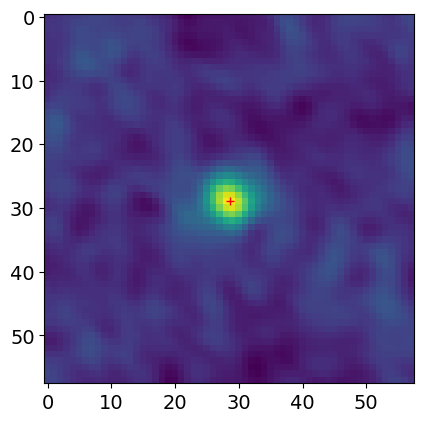

In [706]:
red_cs_scube = cs_scube.subcube_from_regions([region]).spectral_slab(75*u.km/u.s, 200*u.km/u.s)
avgim_redcs = red_cs_scube.mean(axis=0)
avgim_redcs.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
redcs_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:red_cs_scube.shape[1], :red_cs_scube.shape[2]]
redcs_gfit = g = redcs_fit_g(g_init, x, y, z=avgim_redcs.value, weights=1/stats.mad_std(avgim_redcs.value))
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 red_cs_scube.moment1(axis=0)[int(redcs_gfit.y_mean.value), int(redcs_gfit.x_mean.value)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


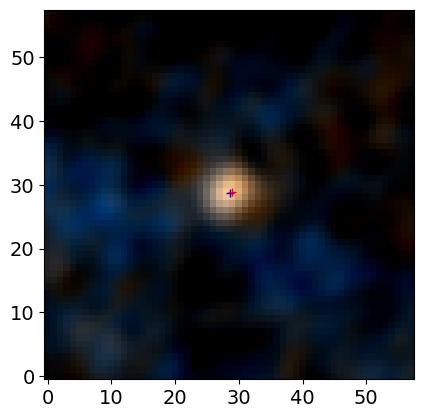

In [707]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')

In [708]:
redcsbluecssep = ((bluecs_gfit.x_mean - redcs_gfit.x_mean)**2 + (bluecs_gfit.y_mean - redcs_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(redcs_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(bluecs_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redcsbluecssep, uncertainty, redcsbluecssep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redcsbluecssep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.9439685631447268,
 0.25117328234270475,
 <Quantity 0.24543183 arcsec>,
 <Quantity 0.06530505 arcsec>,
 <Quantity 2086.17052455 AU>,
 <Quantity 555.09295398 AU>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


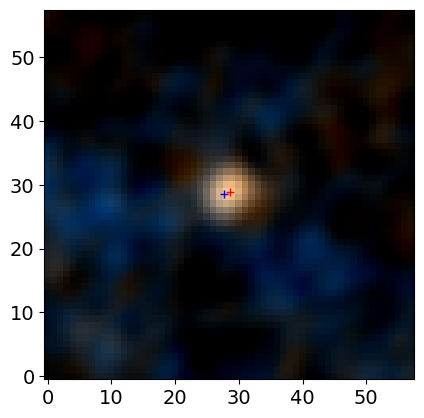

In [709]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')

In [710]:
redcsbluecssep = ((bluecs_gfit.x_mean - redcs_gfit.x_mean)**2 + (bluecs_gfit.y_mean - redcs_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(redcs_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(bluecs_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redcsbluecssep, uncertainty, redcsbluecssep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redcsbluecssep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.9439685631447268,
 0.25117328234270475,
 <Quantity 0.24543183 arcsec>,
 <Quantity 0.06530505 arcsec>,
 <Quantity 2086.17052455 AU>,
 <Quantity 555.09295398 AU>)

In [711]:
# for estimating contour levels
avgim_bluecs.max()

<Projection 0.00630689 Jy / beam>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


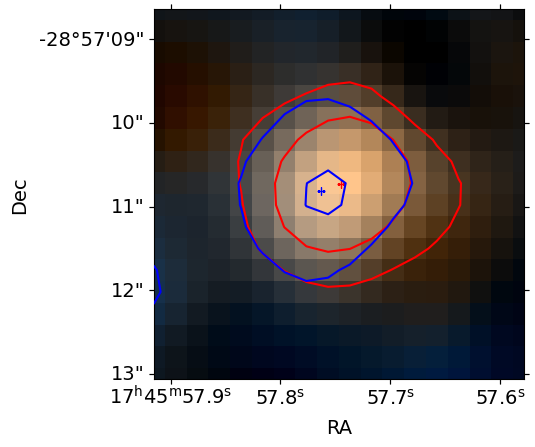

In [712]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
ax = pl.subplot(projection=so_scube.wcs.celestial)
pl.imshow(rgbim, origin='lower');
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')
pl.contour(avgim_redcs, colors=['r', 'r'], levels=[0.003,0.006])
pl.contour(avgim_bluecs, colors=['b', 'b'], levels=[0.003,0.006])
pl.axis([20,37,20,37]);
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSmoment_redcs_and_bluecs.pdf', bbox_inches='tight')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSmoment_redcs_and_bluecs.png', bbox_inches='tight')

# Fit positions of moment maps

In [713]:
sig2fwhm = np.sqrt(8*np.log(2))

In [714]:
centroid_measurements = []

## SO first

In [715]:
so_scube = scubes[-2].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz).spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_scube

DaskSpectralCube with shape=(408, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    408  type_s: VRAD      unit_s: km / s  range:     -300.055 km / s:     299.963 km / s

### Moment images

In [716]:
background_stddev_so = so_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_so = so_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_so_spec = so_scube.subcube_from_regions([circle]).mean(axis=(1,2))

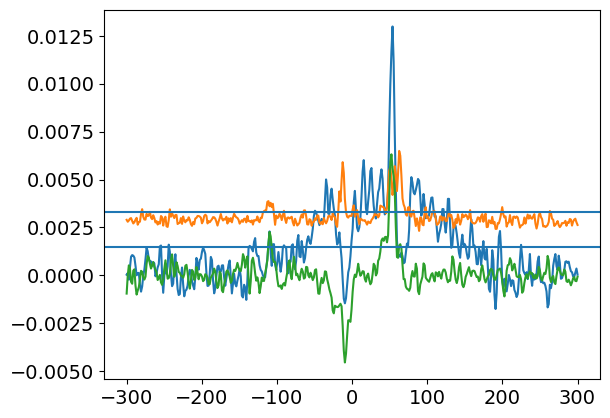

In [717]:
pl.plot(mean_so_spec.spectral_axis, mean_so_spec.value)
pl.plot(mean_so_spec.spectral_axis, background_stddev_so.value)
pl.plot(mean_so_spec.spectral_axis, background_mean_so.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

In [718]:
sig2fwhm = np.sqrt(8*np.log(2))
def convert_uncertainties(unc, jtok):
    return [unc[0],
            unc[0] / jtok,
            unc[1] * pixscale,
            unc[2] * pixscale,
            unc[3] * pixscale * sig2fwhm,
            unc[4] * pixscale * sig2fwhm,
            unc[5]*180/np.pi]

In [719]:
from astropy.io import fits

In [720]:
def galactic_cutout(hdu, reg):
    import reproject.mosaicking, reproject
    csys, sz = reproject.mosaicking.find_optimal_celestial_wcs(hdu, frame='galactic')
    newdata, _ = reproject.reproject_interp(input_data=hdu,
                                            output_projection=csys,
                                            shape_out=sz)
    preg = reg.to_pixel(csys)
    msk = preg.to_mask()
    slcs,_ = msk.get_overlap_slices(newdata.shape)
    new_hdu = fits.PrimaryHDU(data=newdata[slcs], header=csys[slcs].to_header())
    return new_hdu, csys[slcs]

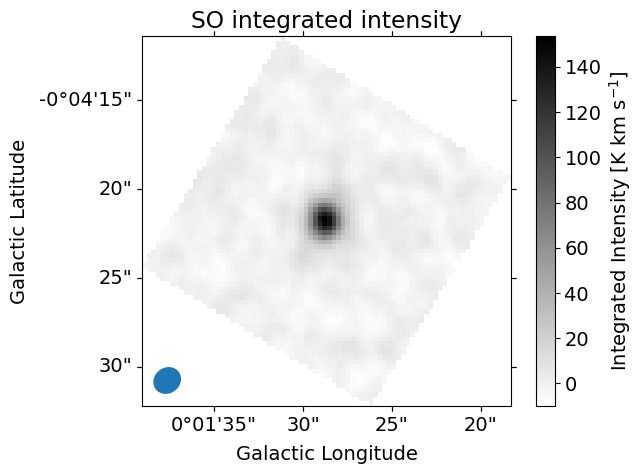

In [721]:
contest = so_scube.median(axis=0)
m0 = ((so_scube-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()
m0_so_ptsrc = m0
m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.fits', overwrite=True)

jtok = m0.beam.jtok(so_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

m0gal, m0galwcs = galactic_cutout(m0.hdu, region)

fig = pl.figure()
ax = pl.subplot(projection=m0galwcs)
im = ax.imshow(m0gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0galwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("SO integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0_small.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0_small.png', bbox_inches='tight')

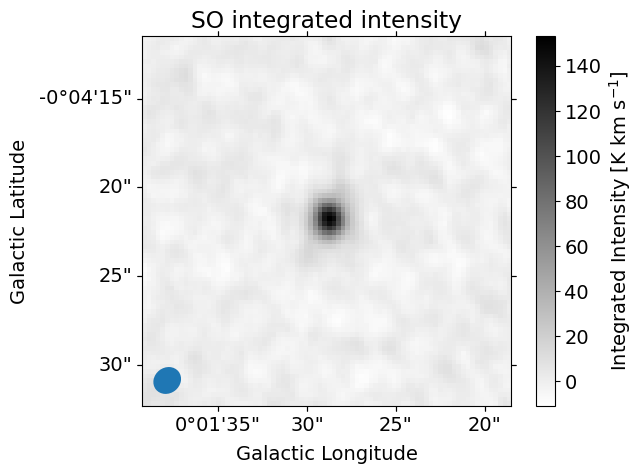

In [722]:
so_scube_toplot = (cubes[-2]
                   .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz)
                   .spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
                   .subcube_from_regions([cutregion]))
contest = so_scube_toplot.median(axis=0)
m0 = ((so_scube_toplot-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()
m0_so_ptsrc = m0
m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0_toplot.fits', overwrite=True)

jtok = m0.beam.jtok(so_scube_toplot.with_spectral_unit(u.GHz).spectral_axis[0]).value

m0gal, m0galwcs = galactic_cutout(m0.hdu, region)

fig = pl.figure()
ax = pl.subplot(projection=m0galwcs)
im = ax.imshow(m0gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0galwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("SO integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.png', bbox_inches='tight')

In [723]:
# do the gaussian fitting in Celestial frame
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()

# redefine m0 so it's not the plot version
contest = so_scube.median(axis=0)
m0 = ((so_scube-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()

y, x = np.mgrid[:m0.shape[0], :m0.shape[1]]
stddev = stats.mad_std(m0.value, ignore_nan=True)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X & Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)

ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)
    
try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['SO 2(3)-1(2)', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa,
                                 ] + convert_uncertainties(uncertainties, jtok))
except radio_beam.utils.BeamError:
    centroid_measurements.append(['SO 2(3)-1(2)', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.deg
                                 ] + convert_uncertainties(uncertainties, jtok))
print(centroid_measurements[-1])

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean           x_stddev           y_stddev            theta       
    ------------------ ------------------ ----------------- ------------------ ------------------ ------------------
    148.32008973612423 28.675184605802404 28.82932587561258 2.5294143922434666 2.9667869508805436 2.0085460104975636 [1.12337197 0.02191275 0.01979418 0.01915809 0.022471   0.03343582]
Swapped X & Y
['SO 2(3)-1(2)', 'm0', 148.32008973612423, 2.795070225002834, <Longitude 266.49059622 deg>, <Latitude -28.95299025 deg>, <Quantity 0.00043018 deg>, <Quantity 0.00050456 deg>, <Quantity 205.08120936 deg>, <Quantity 0.00023586 deg>, <Quantity 0.00014205 deg>, <Quantity -1.41654092 rad>, 1.12337196911429, 0.02116977914495836, <Quantity 1.58258758e-06 deg>, <Quantity 1.42957969e-06 deg>, <Quantity 3.25822283e-06 deg>, <Quantity 3.82165046e-06 deg>, 1.9157313900457786]


#### SO fullcloud background

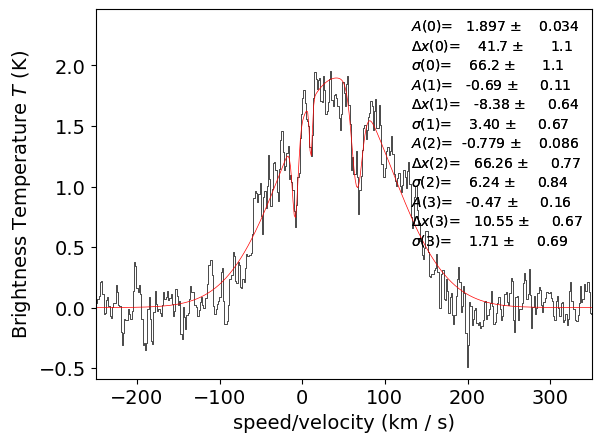

In [724]:
spw33.xarr.convert_to_unit(u.GHz)
spw33.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_so32)
spw33.plotter(xmin=-250, xmax=350)
spw33.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, -0.3, 10, 5])

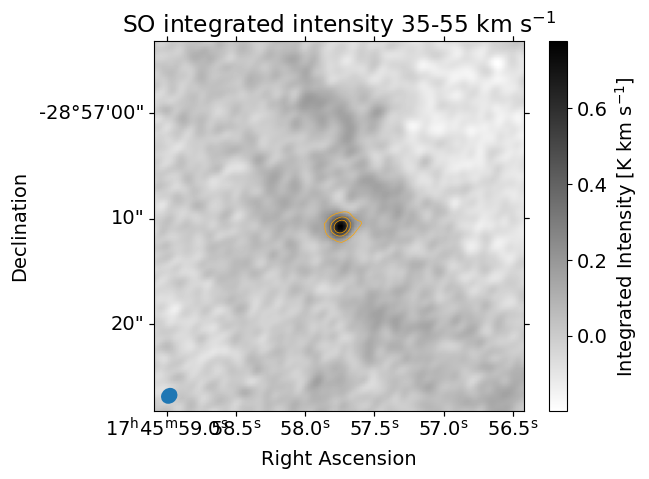

In [725]:
m0_bigcloud_3555_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(35*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_3555_so.wcs)
im = ax.imshow(m0_bigcloud_3555_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 35-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_35to55kms_with_comsrc.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_35to55kms_with_comsrc.png', bbox_inches='tight')

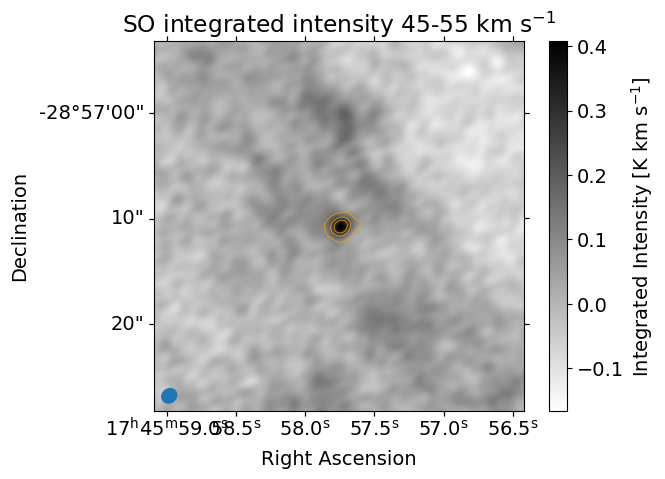

In [726]:
m0_bigcloud_4555_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_4555_so.wcs)
im = ax.imshow(m0_bigcloud_4555_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc_celestial.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc_celestial.png', bbox_inches='tight')

DaskSpectralCube with shape=(8, 269, 269) and unit=Jy / beam and chunk size (8, 54, 269):
 n_x:    269  type_x: RA---SIN  unit_x: deg    range:   266.479591 deg:  266.501714 deg
 n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -28.962656 deg:  -28.943299 deg
 n_s:      8  type_s: VRAD      unit_s: km / s  range:       44.919 km / s:      55.239 km / s


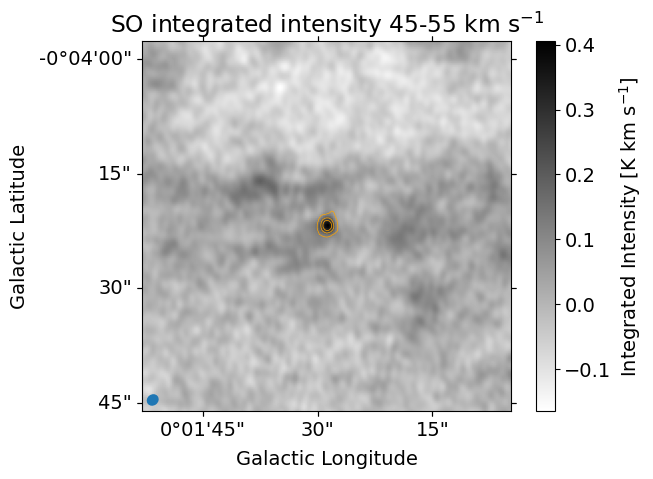

In [727]:
big_so_scube = (cubes[-2]
                    .subcube_from_regions([bigcircregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   )
print(big_so_scube)
m0_bigcloud_4555_so = big_so_scube.moment0()
m0_bigcloud_4555_so_gal, ww = galactic_cutout(m0_bigcloud_4555_so.hdu, bigregion)

fig = pl.figure()
ax = pl.subplot(projection=ww)
im = ax.imshow(m0_bigcloud_4555_so_gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("SO integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc.png', bbox_inches='tight')

#### SO2

In [728]:
nurest_so2_220 = 100.878105*u.GHz

In [729]:
so2scube = scubes[-1]
# ['SO2 2(2,0)-3(1,3)', 100.878105e9]
so2scube

DaskSpectralCube with shape=(1916, 58, 58) and unit=Jy / beam and chunk size (32, 58, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:   1916  type_s: FREQ      unit_s: Hz     range: 99561858955.100 Hz:101432097362.135 Hz

In [730]:
so2_220_scube = scubes[-1].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so2_220).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_so2_220 = scubes[-1].median(axis=0)

background_stddev_so2_220 = so2_220_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_so2_220 = so2_220_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_so2_220_spec = so2_220_scube.subcube_from_regions([circle]).mean(axis=(1,2))

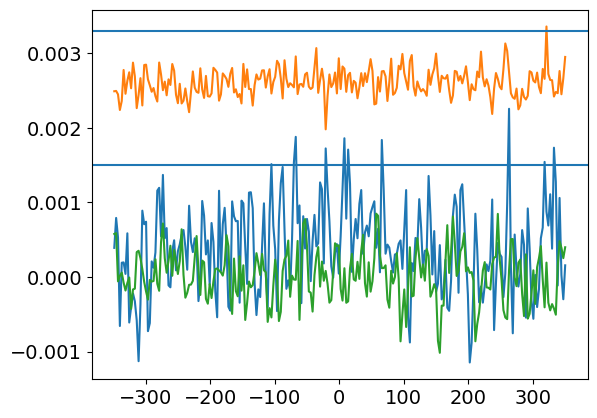

In [731]:
pl.plot(mean_so2_220_spec.spectral_axis, mean_so2_220_spec.value)
pl.plot(mean_so2_220_spec.spectral_axis, background_stddev_so2_220.value)
pl.plot(mean_so2_220_spec.spectral_axis, background_mean_so2_220.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev          y_stddev           theta       
    ------------------ ------------------ ------------------ ----------------- ----------------- ------------------
    3.7555974291588297 25.796834151480667 26.265819536435675 5.769628017133859 7.246243902269401 1.1407465130094883 [0.17499435 0.3266569  0.28198078 0.26883404 0.33756203 0.14348491]
Swapped X and Y


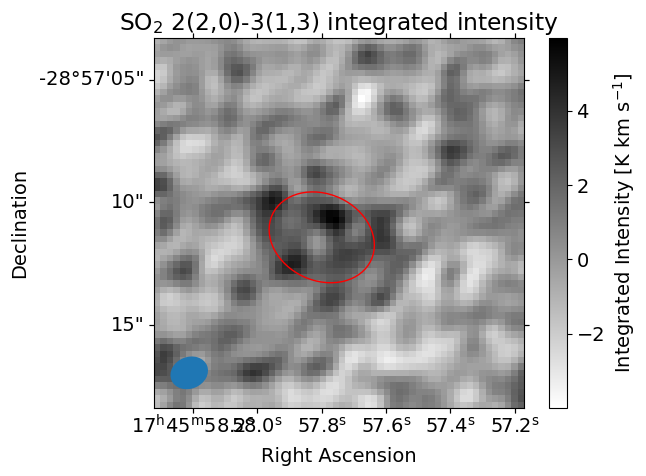

In [732]:
m0 = ((so2_220_scube-contest_so2_220)
      .with_mask((background_stddev_so2_220 < 0.0033*background_stddev_so2_220.unit)[:,None,None])
      .with_mask((mean_so2_220_spec > 0.0015*mean_so2_220_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(so2_220_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO$_2$ 2(2,0)-3(1,3) integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO2_220_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO2_220_m0.png', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so2_220_scube.shape[1], :so2_220_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

#try:
#    deconv_size = src.deconvolve(m0.beam)
#    
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  deconv_size.major, deconv_size.minor, deconv_size.pa
#                                 ])
#except radio_beam.utils.BeamError:
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                 ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO2_220_m0.fits', overwrite=True)

#### H13COP

Not a clear detection

In [733]:
scubes[1], nurest_h13cop

(DaskSpectralCube with shape=(956, 58, 58) and unit=Jy / beam and chunk size (22, 58, 58):
  n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
  n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
  n_s:    956  type_s: FREQ      unit_s: Hz     range: 86666488077.200 Hz:87132826992.200 Hz,
 <Quantity 86.7543 GHz>)

In [734]:
h13cop_scube = scubes[1].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_h13cop).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_h13cop = scubes[1].median(axis=0)

background_stddev_h13cop = h13cop_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_h13cop = h13cop_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_h13cop_spec = h13cop_scube.subcube_from_regions([circle]).mean(axis=(1,2))

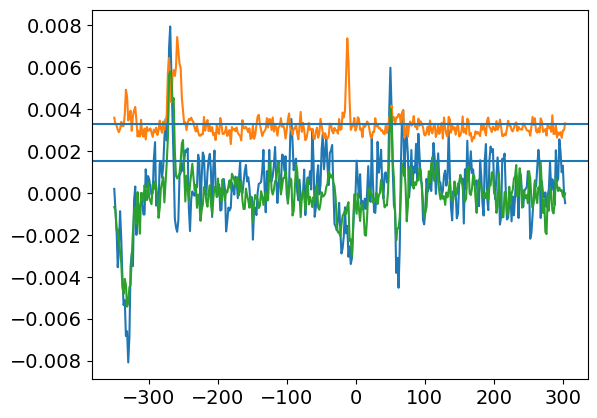

In [735]:
pl.plot(mean_h13cop_spec.spectral_axis, mean_h13cop_spec.value)
pl.plot(mean_h13cop_spec.spectral_axis, background_stddev_h13cop.value)
pl.plot(mean_h13cop_spec.spectral_axis, background_mean_h13cop.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean             y_mean            x_stddev          y_stddev           theta       
    ----------------- ------------------ ------------------ ----------------- ----------------- ------------------
    12.23002159398392 27.609989523601126 29.847964504491703 7.206119014930517 8.129650590986492 0.9895282199076768 [0.28418466 0.18269116 0.17417562 0.1674283  0.18890067 0.13585309]
Swapped X and Y


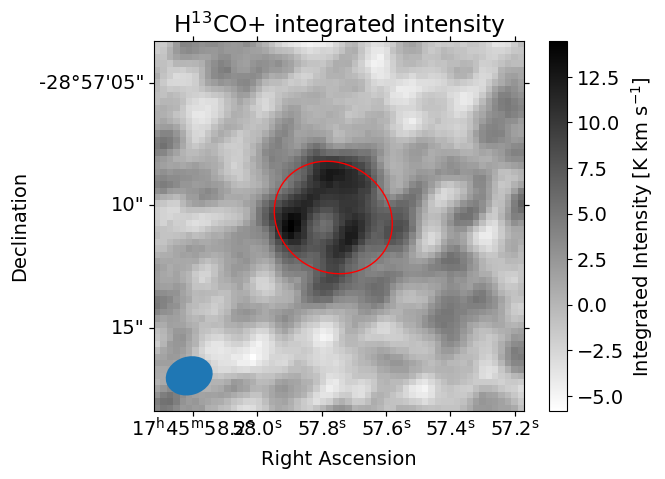

In [736]:
m0 = ((h13cop_scube-contest_h13cop)
      .with_mask((background_stddev_h13cop < 0.0033*background_stddev_h13cop.unit)[:,None,None])
      .with_mask((mean_h13cop_spec > 0.0015*mean_h13cop_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(h13cop_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("H$^{13}$CO+ integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.png', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:h13cop_scube.shape[1], :h13cop_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

#try:
#    deconv_size = src.deconvolve(m0.beam)
#    
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  deconv_size.major, deconv_size.minor, deconv_size.pa
#                                 ])
#except radio_beam.utils.BeamError:
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                 ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.fits', overwrite=True)

#### H13COP: Tsuboi's data

In [737]:
sc = [c for c in scubes2012 if nurest_h13cop < c.spectral_axis.max() and nurest_h13cop > c.spectral_axis.min()][0]
sc = sc.mask_out_bad_beams(threshold=0.1)
h13cop2012_scube = sc.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_h13cop).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_h13cop2012 = sc.median(axis=0)

background_stddev_h13cop2012 = h13cop2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_h13cop2012 = h13cop2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_h13cop2012_spec = h13cop2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


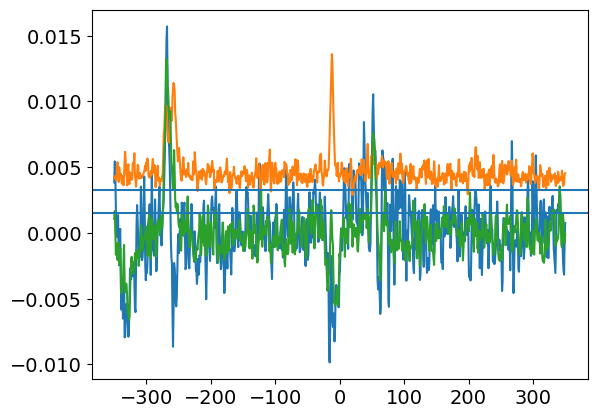

In [738]:
pl.plot(mean_h13cop2012_spec.spectral_axis, mean_h13cop2012_spec.value)
pl.plot(mean_h13cop2012_spec.spectral_axis, background_stddev_h13cop2012.value)
pl.plot(mean_h13cop2012_spec.spectral_axis, background_mean_h13cop2012.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude            x_mean             y_mean            x_stddev          y_stddev             theta       
    ------------------- ------------------ ------------------ ----------------- ------------------ -------------------
    0.36419285250456024 30.134332798921932 24.546232580170038 3.435195127930547 12.184678210133958 -0.5077098837579497 [0.02191978 0.39940337 0.64883995 0.20620773 0.74413222 0.02608826]
Swapped X and Y


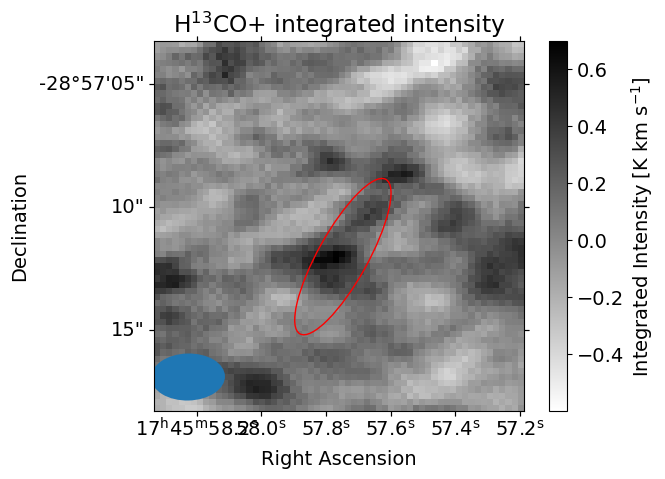

In [739]:
m0 = ((h13cop2012_scube-contest_h13cop2012)
      .with_mask((background_stddev_h13cop2012 < 0.0033*background_stddev_h13cop2012.unit)[:,None,None])
      .with_mask((mean_h13cop2012_spec > 0.0015*mean_h13cop2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(h13cop2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("H$^{13}$CO+ integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.png', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:h13cop2012_scube.shape[1], :h13cop2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

# try:
#     deconv_size = src.deconvolve(m0.beam)
#     
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   deconv_size.major, deconv_size.minor, deconv_size.pa
#                                  ])
# except radio_beam.utils.BeamError:
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                  ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.fits', overwrite=True)

## Now CS moments

In [740]:
cs_scube = (scubes[-2]
            .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
            .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
big_cs_scube = (cubes[-2]
                .subcube_from_regions([bigcircregion])
                .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
                .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
cs_scube, big_cs_scube

(DaskSpectralCube with shape=(402, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
  n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
  n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
  n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s,
 DaskSpectralCube with shape=(402, 269, 269) and unit=Jy / beam and chunk size (60, 54, 269):
  n_x:    269  type_x: RA---SIN  unit_x: deg    range:   266.479591 deg:  266.501714 deg
  n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -28.962656 deg:  -28.943299 deg
  n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s)

In [741]:
background_stddev_cs = cs_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_cs = cs_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_cs_spec = cs_scube.subcube_from_regions([circle]).mean(axis=(1,2))

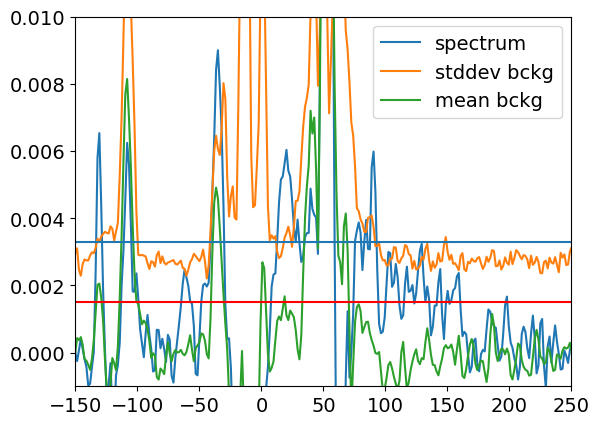

In [742]:
pl.plot(mean_cs_spec.spectral_axis, mean_cs_spec.value, label='spectrum')
pl.plot(mean_cs_spec.spectral_axis, background_stddev_cs.value, label='stddev bckg')
pl.plot(mean_cs_spec.spectral_axis, background_mean_cs.value, label='mean bckg')
pl.axhline(0.0033)
pl.axhline(0.0015, color='r')
pl.ylim(-0.001, 0.01)
pl.xlim(-150, 250)
pl.legend(loc='best');

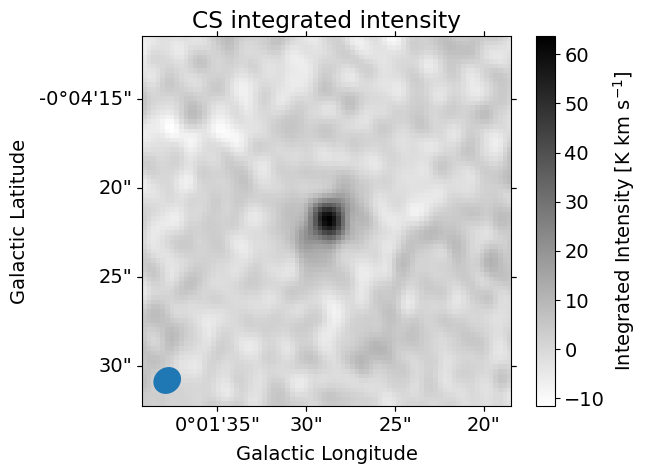

In [743]:
m0 = (big_cs_scube.with_mask((background_stddev_cs < 0.0033*background_stddev_cs.unit)[:,None,None])
              .with_mask((mean_cs_spec > 0.0010*mean_cs_spec.unit)[:,None,None])
              .spectral_slab(-150*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()
m0_cs_ptsrc = m0
jtok = m0.beam.jtok(cs_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

m0cs_gal, ww = galactic_cutout(m0.hdu, region)

fig = pl.figure()
ax = pl.subplot(projection=ww)
im = ax.imshow(m0cs_gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("CS integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.png', bbox_inches='tight')

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev         y_stddev            theta        
    ------------------ ------------------ ------------------ ----------------- ---------------- --------------------
    55.650578910083006 28.247627874657322 28.788487892112837 4.172805827895565 3.14902909536739 -0.06905730437108455 [0.76316068 0.05716715 0.04326269 0.05722582 0.04318505 0.03399555]


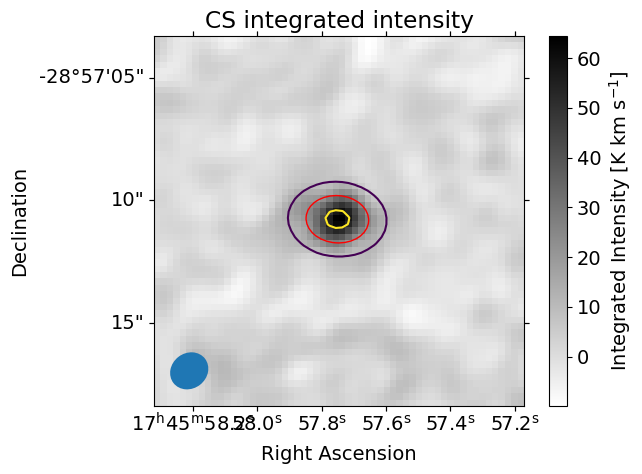

In [744]:
m0 = (cs_scube.with_mask((background_stddev_cs < 0.0033*background_stddev_cs.unit)[:,None,None])
              .with_mask((mean_cs_spec > 0.0010*mean_cs_spec.unit)[:,None,None])
              .spectral_slab(-150*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()
m0_cs_ptsrc = m0
jtok = m0.beam.jtok(cs_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_celestial.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_celestial.png', bbox_inches='tight')


g_init = Gaussian2D(amplitude=11, x_mean=m0.shape[1]/2., y_mean=m0.shape[0]/2., x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs_scube.shape[1], :cs_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
deconv_size = src.deconvolve(m0.beam)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

centroid_measurements.append(['CS 2-1', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ] + convert_uncertainties(uncertainties, jtok))


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.fits', overwrite=True)

ax.contour(g(x,y), levels=[10, 50])

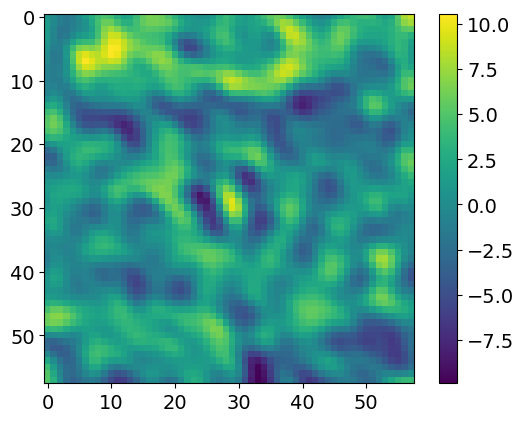

In [745]:
pl.imshow(m0.value - g(x,y))
pl.colorbar();

In [746]:
nurest_cs21

<Quantity 9.798095e+10 Hz>

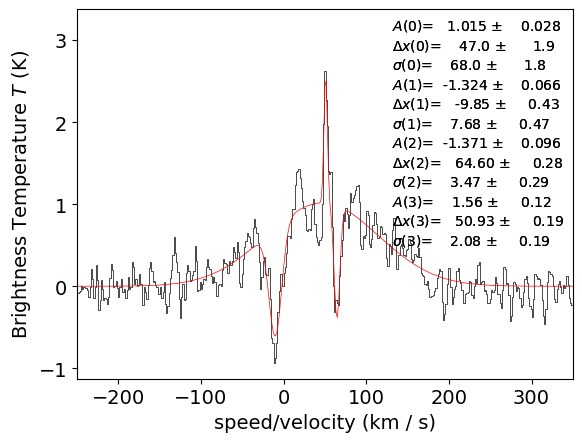

In [747]:
spw33.xarr.convert_to_unit(u.GHz)
spw33.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_cs21)
spw33.plotter(xmin=-250, xmax=350)
spw33.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, 1, 55, 4])

### C34S Tsuboi

Not a clear detection spatially (was kinda clear spectrally?)

In [748]:
c34s2012_scube = c34scube_2012.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_c34s21).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_c34s2012 = sc.median(axis=0)

background_stddev_c34s2012 = c34s2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_c34s2012 = c34s2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_c34s2012_spec = c34s2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


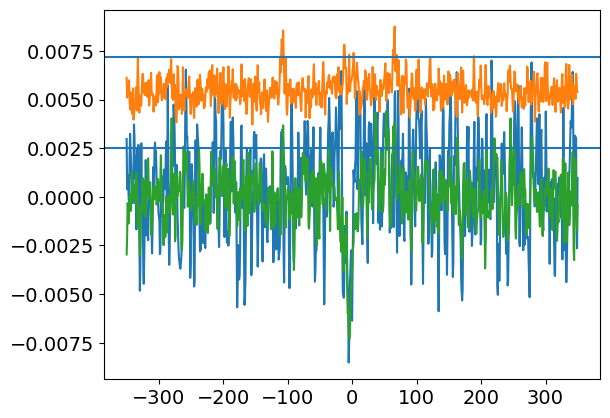

In [749]:
pl.plot(mean_c34s2012_spec.spectral_axis, mean_c34s2012_spec.value)
pl.plot(mean_c34s2012_spec.spectral_axis, background_stddev_c34s2012.value)
pl.plot(mean_c34s2012_spec.spectral_axis, background_mean_c34s2012.value)
pl.axhline(0.0072)
pl.axhline(0.0025)

#### C34S integrated intensity

Doesn't look very pointlike!  But this could be a low S/N issue?  and/or contamination issue?

Or does it maybe hint at there being some interaction between the source and surroundings?

I don't really trust the image quality of this data set enough to believe the latter.... but it mgiht be worth a deeper dive.

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev          y_stddev           theta       
    ------------------ ------------------ ------------------ ----------------- ----------------- ------------------
    17.359836393603224 29.775969638907664 31.109106845025654 8.283242158498897 9.898672930205665 1.8347554157856887 [0.2684331  0.15146828 0.1299     0.12806197 0.15321886 0.06104767]
Swapped X and Y


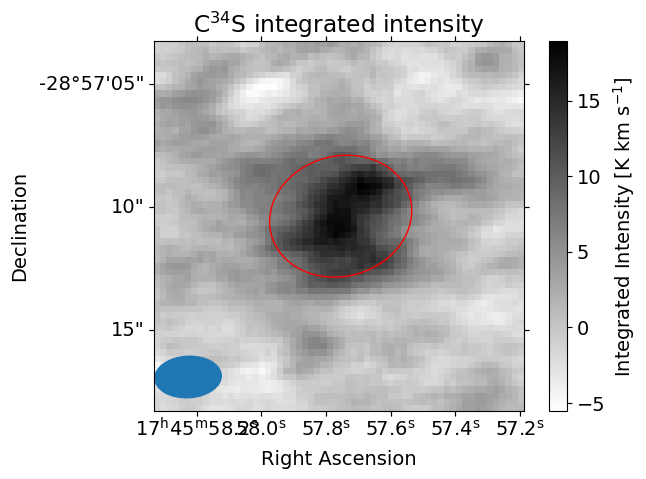

In [750]:
m0 = ((c34s2012_scube.mask_out_bad_beams(threshold=0.1)-contest_c34s2012)
      .with_mask((background_stddev_c34s2012 < 0.0072*background_stddev_c34s2012.unit)[:,None,None])
      .with_mask((mean_c34s2012_spec > 0.0025*mean_c34s2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(c34s2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("C$^{34}$S integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.png', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:c34s2012_scube.shape[1], :c34s2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

# try:
#     deconv_size = src.deconvolve(m0.beam)
#     
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   deconv_size.major, deconv_size.minor, deconv_size.pa
#                                  ])
# except radio_beam.utils.BeamError:
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                  ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.fits', overwrite=True)

#### CS Tsuboi

In [ ]:
cs2012_scube = cscube_2012.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_cs2012 = sc.median(axis=0)

background_stddev_cs2012 = cs2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_cs2012 = cs2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_cs2012_spec = cs2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


In [ ]:
pl.plot(mean_cs2012_spec.spectral_axis, mean_cs2012_spec.value)
pl.plot(mean_cs2012_spec.spectral_axis, background_stddev_cs2012.value)
pl.plot(mean_cs2012_spec.spectral_axis, background_mean_cs2012.value)
pl.axhline(0.0072)
pl.axhline(0.0025)

In [ ]:
m0 = ((cs2012_scube-contest_cs2012)
      .with_mask((background_stddev_cs2012 < 0.0072*background_stddev_cs2012.unit)[:,None,None])
      .with_mask((mean_cs2012_spec > 0.0025*mean_cs2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(cs2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity [2012]")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.png', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs2012_scube.shape[1], :cs2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['CS 2-1 2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ] + convert_uncertainties(uncertainties, jtok))
except radio_beam.utils.BeamError:
    centroid_measurements.append(['CS 2-1 2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
                                 ] + convert_uncertainties(uncertainties, jtok))


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.fits', overwrite=True)

## continuum

In [ ]:
ls /orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/*spw33_35*cont*fits -d 

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS

### ACES High

In [ ]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.v1high_spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
contcube = SpectralCube.read(fn)
fh = fits.open(fn)
contwcs = WCS(fh[0].header).celestial
preg = region.to_pixel(contwcs)
msk = preg.to_mask()
contim = msk.cutout(fh[0].data.squeeze());
beam = radio_beam.Beam.from_fits_header(fh[0].header)
jtok = beam.jtok(102*u.GHz).value
contim = contim * jtok

In [ ]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
contwcs_co = contwcs[slcs] 
ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(contim, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_celestial.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_celestial.png', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:contim.shape[0], :contim.shape[1]]
stddev = stats.mad_std(contim)
g = fit_g(g_init, x, y, z=contim, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = contwcs_co.pixel_to_world(g.x_mean, g.y_mean)


if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)


deconv_size = src.deconvolve(beam)

centroid_measurements.append(['Continuum', 'spw33+35', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ] + convert_uncertainties(uncertainties, jtok))


header = fh[0].header
header.update(contwcs_co.to_header())
fits.PrimaryHDU(data=contim, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

In [ ]:
ls -d /orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci*image.tt0

In [ ]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.v1high_spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
fh = fits.open(fn)
beam = radio_beam.Beam.from_fits_header(fh[0].header)
contim, contwcs = galactic_cutout((fh[0].data.squeeze(), WCS(fh[0].header).celestial), region)

fig = pl.figure()
ax = pl.subplot(projection=contwcs)
im = ax.imshow(contim.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum.png', bbox_inches='tight')


### ACES low

In [ ]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw25_27.cont.I.iter1.image.tt0.pbcor"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.v1.1_20240314_low_spw25_27.cont.I.iter1.image.tt0.pbcor"
contlowcube = SpectralCube.read(fn, format='casa_image')
contlowwcs = contlowcube.wcs.celestial
preg = region.to_pixel(contlowwcs)
msk = preg.to_mask()
contlowim = msk.cutout(contlowcube[0].value.squeeze());
beam = contlowcube.beam
jtok = beam.jtok(86*u.GHz).value
contlowim = contlowim * jtok

In [ ]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
contlowwcs_co = contlowwcs[slcs] 
ax = pl.subplot(projection=contlowwcs_co)
im = ax.imshow(contlowim, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contlowwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_low_celestial.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_low_celestial.png', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:contlowim.shape[0], :contlowim.shape[1]]
stddev = stats.mad_std(contlowim, ignore_nan=True)
print(f'stddev={stddev}')
g = fit_g(g_init, x, y, z=contlowim, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = contlowwcs_co.pixel_to_world(g.x_mean, g.y_mean)


if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)


deconv_size = src.deconvolve(beam)

centroid_measurements.append(['Continuum', 'spw25+27', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ] + convert_uncertainties(uncertainties, jtok))


header = fh[0].header
header.update(contlowwcs_co.to_header())
fits.PrimaryHDU(data=contlowim, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/contlow_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

### Tsuboi cont (B3 2012)

As of 2024/1/28, haven't done this b/c the B3 cont never finished imaging and it wasn't provided as a quicklook product.

In [ ]:
fn = "/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/Tsuboi2012_compactsource_continuum_r-2_bigger.image.pbcor.fits"
contcube2012 = SpectralCube.read(fn)
fh2012 = fits.open(fn)
cont2012wcs = WCS(fh2012[0].header).celestial
preg = region.to_pixel(cont2012wcs)
msk = preg.to_mask()
cont2012im = msk.cutout(fh2012[0].data.squeeze());
beam2012 = radio_beam.Beam.from_fits_header(fh2012[0].header)
jtok2012 = beam2012.jtok(fh2012[0].header['CRVAL3']*u.Hz).value
cont2012im = cont2012im * jtok2012

In [ ]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh2012[0].data.squeeze().shape)
cont2012wcs_co = cont2012wcs[slcs] 
ax = pl.subplot(projection=cont2012wcs_co)
im = ax.imshow(cont2012im, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = cont2012wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont2012inuum.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont2012inuum.png', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cont2012im.shape[0], :cont2012im.shape[1]]
stddev = stats.mad_std(cont2012im)
g = fit_g(g_init, x, y, z=cont2012im, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = cont2012wcs_co.pixel_to_world(g.x_mean, g.y_mean)


if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

try:
    deconv_size = src.deconvolve(beam2012)
    
    centroid_measurements.append(['Continuum 2012', 'cont', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ] + convert_uncertainties(uncertainties, jtok))
except radio_beam.utils.BeamError:
    print(src)
    print(beam2012)
    centroid_measurements.append(['Continuum 2012', 'cont', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
                                 ] + convert_uncertainties(uncertainties, jtok))


header = fh2012[0].header
header.update(cont2012wcs_co.to_header())
fits.PrimaryHDU(data=cont2012im, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont2012_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

### B7 cont

In [ ]:
b7cont = SpectralCube.read('/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15.mfs.I.manual.image.pbcor.fits')

In [ ]:
b7cont.spectral_axis

##### B7 Continuum

In [ ]:
m0 = b7cont.subcube_from_regions([region]).to(u.K)
m0 = m0[0]
jtok = b7cont.beam.jtok(b7cont.spectral_axis[0])

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs.celestial)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("B7 continuum")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.png', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=m0.shape[1]/2, y_mean=m0.shape[0]/2, x_stddev=2.5, y_stddev=2.5)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:m0.shape[0], :m0.shape[1]]
stddev = stats.mad_std(m0.value[np.isfinite(m0.value)])
g = fit_g(g_init, x, y, z=np.nan_to_num(m0.value), weights=np.nan_to_num(1/stddev))
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)




try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['Continuum', 'B7', g.amplitude.value, g.amplitude.value/jtok.value, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ] + convert_uncertainties(uncertainties, jtok.value))
except Exception as ex:
    print(f"Deconvolution failed: {ex}")
    centroid_measurements.append(['Continuum', 'B7', g.amplitude.value, g.amplitude.value/jtok.value, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.deg, np.nan*u.deg, np.nan*u.deg
                                 ] + convert_uncertainties(uncertainties, jtok.value))


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.fits', overwrite=True)
ax.contour(g(x,y), levels=[0.02, 0.05])

### Make table (spatial measurements)

In [ ]:
from latex_info import rounded

In [ ]:
coord.to_string('hmsdms', precision=3)

In [ ]:
latexdict2 = latex_info.latexdict.copy()
latexdict2['header_start'] = r'\label{tab:spatial_measurements}'
latexdict2['caption'] = 'Spatial Measurements'
latexdict2['tablefoot'] = f"""\par
The Amp and Amp[mJy] values are in K \kms and Jy/beam \kms for the spectral lines.
The RA off and Dec. off columns give offsets from the coordinate {coord.to_string('hmsdms', precision=3)}.
Under the Major, Minor, and PA columns, the alternating rows with no errorbars give the beam-deconvolved sizes.
"""
latexdict2['preamble'] = r'\centering \small'
latexdict2['col_align'] = 'ccccclll'
formats2 = {
           #'Amp[Jy]': lambda x: "{0:0.3f}".format(x),
           #'Amp': lambda x: "{0:0.3f}".format(x),
           #'RA': lambda x: "{0:0.5f}".format(x),
           #'Dec': lambda x: "{0:0.5f}".format(x),
           #'Major': lambda x: "{0:0.2f}".format(x),
           #'Minor': lambda x: "{0:0.2f}".format(x),
           #'PA': lambda x: "{0:0.1f}".format(x),
           #'D. Major': lambda x: "{0:0.2f}".format(x),
           #'D. Minor': lambda x: "{0:0.2f}".format(x),
           #'D. PA': lambda x: "{0:0.1f}".format(x),
           #'RA off': lambda x: "{0:0.3f}".format(x),
           #'Dec. off': lambda x: "{0:0.3f}".format(x),
           #'eAmp[Jy]': lambda x: "{0:0.3f}".format(x),
           #'eAmp': lambda x: "{0:0.3f}".format(x),
           #'eRA': lambda x: "{0:0.5f}".format(x),
           #'eDec': lambda x: "{0:0.5f}".format(x),
           #'eMajor': lambda x: "{0:0.3f}".format(x),
           #'eMinor': lambda x: "{0:0.3f}".format(x),
           #'ePA': lambda x: "{0:0.3f}".format(x),
          }

In [ ]:
centrfittbl = Table((list(zip(*centroid_measurements))),
                    names=['Image Data', 'Image Type', 'Amp', 'Amp[Jy]', 'RA', 'Dec', 'Major', 'Minor', 'PA',
                           'D. Major', 'D. Minor', 'D. PA',
                           'eAmp', 'eAmp[Jy]', 'eRA', 'eDec', 'eMajor', 'eMinor', 'ePA',
                          ])
centrfittbl['Amp'].unit = u.K
centrfittbl['Amp[Jy]'].unit = u.Jy/u.beam
centrfittbl['eAmp'].unit = u.K
centrfittbl['eAmp[Jy]'].unit = u.Jy/u.beam
centrfittbl['Amp[mJy]'] = centrfittbl['Amp[Jy]'].to(u.mJy/u.beam)
centrfittbl['eAmp[mJy]'] = centrfittbl['eAmp[Jy]'].to(u.mJy/u.beam)
centrfittbl['D. Major'] = centrfittbl['D. Major'].to(u.arcsec)
centrfittbl['D. Minor'] = centrfittbl['D. Minor'].to(u.arcsec)
centrfittbl['D. PA'] = centrfittbl['D. PA'].to(u.deg)
centrfittbl['Major'] = centrfittbl['Major'].to(u.arcsec)
centrfittbl['Minor'] = centrfittbl['Minor'].to(u.arcsec)
centrfittbl['eMajor'] = centrfittbl['eMajor'].to(u.arcsec)
centrfittbl['eMinor'] = centrfittbl['eMinor'].to(u.arcsec)
centrfittbl.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.ecsv', overwrite=True)

centrfittbl_tex = centrfittbl.copy()
for colname, fmt in zip(('Amp', 'Amp[mJy]', 'RA', 'Dec', 'Major', 'Minor', 'PA',),
                        ("0.2f", "0.1f", "0.5f", "0.5f", "0.2f", "0.2f", "0.1f")):
    col = centrfittbl[colname]
    ecol = centrfittbl['e'+colname]
    #fstrings = [f'{{0:0.{fmt}}} ({{1:{fmt}}})'
    data = ["{0} ({1})".format(*rounded(x, y)) for x, y in zip(col, ecol)]
    centrfittbl_tex[colname] = data
centrfittbl_tex['Image'] = [f'{row["Image Data"]} {row["Image Type"]}' for row in centrfittbl_tex] 

centrfittbl_tex['RA off'] = ["{0:d} ({1:d})".format(int(x), int(y)) for x, y in zip((centrfittbl['RA'].quantity - coord.ra).to(u.marcsec).value,
                                                                               centrfittbl['eRA'].quantity.to(u.marcsec).value)
                                                                               ]

centrfittbl_tex['Dec. off'] = ["{0:d} ({1:d})".format(int(x), int(y)) for x, y in zip((centrfittbl['Dec'].quantity - coord.dec).to(u.marcsec).value,
                                                                                  centrfittbl['eDec'].quantity.to(u.marcsec).value)]

new_centrfittbl_tex = {}
for col in ['Image', 'Amp', 'Amp[mJy]', 'RA off', 'Dec. off']:
    new_centrfittbl_tex[col] = [x for y in centrfittbl_tex[col] for x in (y, '')]

for col in ('Major', 'Minor', 'PA'):
    centrfittbl_tex['D. '+col] = ["{0:0.2f}".format(x) for x in centrfittbl_tex['D. '+col]]
    new_centrfittbl_tex[col] = ['-' if x=='nan' else x for y in zip(centrfittbl_tex[col], centrfittbl_tex['D. '+col]) for x in y]

centrfittbl_tex = Table(new_centrfittbl_tex)

centrfittbl_tex = centrfittbl_tex[['Image', 'Amp', 'Amp[mJy]', 'RA off', 'Dec. off', 'Major', 'Minor', 'PA',]]
                           #'D. Major', 'D. Minor', 'D. PA']]
centrfittbl_tex['RA off'].unit = u.marcsec
centrfittbl_tex['Dec. off'].unit = u.marcsec
centrfittbl_tex['Major'].unit = u.arcsec
centrfittbl_tex['Minor'].unit = u.arcsec
#centrfittbl_tex['D. Major'].unit = u.arcsec
#centrfittbl_tex['D. Minor'].unit = u.arcsec
centrfittbl_tex['PA'].unit = u.degree
#centrfittbl_tex['D. PA'].unit = u.degree
centrfittbl_tex['Amp'].unit = u.K
centrfittbl_tex['Amp[mJy]'].unit = u.mJy

centrfittbl_tex.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.tex',
                      latexdict=latexdict2, formats=formats2, overwrite=True)

In [ ]:
#centrfittbl_tex['RA off'] = ["{0:0.2f}".format(x) for x in (centrfittbl['RA'].quantity - coord.ra).to(u.arcsec)]

In [ ]:
centrfittbl['eAmp', 'eAmp[mJy]', 'Amp', 'Amp[mJy]']

In [ ]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.tex

In [ ]:
centrfittbl

In [ ]:
centrfittbl_tex

#### Spectral Index

In [ ]:
# wrong
# np.log(centrfittbl['Amplitude'][3] / centrfittbl['Amplitude'][2]) / np.log((350*u.GHz/(102*u.GHz)).decompose().value) + 2

$$a = d \log(b/c)$$
$$da = d \left(\frac{d}{db}  \log (b/c) + \frac{d}{dc} \log(b/c) \right)$$
$$ = d \left(\frac{d}{db}  (\log b - \log c) + \frac{d}{dc} (\log b - \log c) \right)$$
$$ = d \left( \frac{1}{b} - \frac{1}{c} \right)$$
errors should add...
$$\sigma_a^2 = d^2 \left( \left[\frac{\sigma_b}{b}\right]^2 + \left[\frac{\sigma_c}{c}\right]^2 \right)$$

In [ ]:
centrfittbl.add_index('Image Data')
centrfittbl.add_index('Image Type')
b7r = centrfittbl.loc['Continuum'].loc['Image Type', 'B7']
b3r = centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']
spectral_index = (
    np.log(b7r['Amp[Jy]'] / b3r['Amp[Jy]']) /
    np.log((350*u.GHz/(102*u.GHz)).decompose().value))
spectral_index

In [ ]:
dd = np.log((350*u.GHz/(102*u.GHz)).decompose().value)
bb = b7r['Amp[Jy]']
cc = b3r['Amp[Jy]']
eb = b7r['eAmp[Jy]']
ec = b3r['eAmp[Jy]']
spectral_index_error = (dd**2 * ((eb/bb)**2 + (ec/cc)**2))**0.5
spectral_index_error

In [ ]:
dd = np.log((350*u.GHz/(102*u.GHz)).decompose().value)
bb = b7r['Amp[Jy]']
cc = b3r['Amp[Jy]']
eb = 0.1 * b7r['Amp[Jy]']
ec = 0.1 * b3r['Amp[Jy]']
spectral_index_systematic_error = (dd**2 * ((eb/bb)**2 + (ec/cc)**2))**0.5
spectral_index_systematic_error

#### Proper Motion check

In [ ]:
b32021 = centrfittbl.loc['Continuum 2012']
pos_2021 = SkyCoord(b3r['RA'], b3r['Dec'], frame='fk5', unit=(u.deg, u.deg))
pos_2012 = SkyCoord(b32021['RA'], b32021['Dec'], frame='fk5', unit=(u.deg, u.deg))
pos_2021.separation(pos_2012)

In [ ]:
pm_l, pm_b = (pos_2021.galactic.l - pos_2012.galactic.l).to(u.arcsec), (pos_2021.galactic.b - pos_2012.galactic.b).to(u.arcsec)
pm_l, pm_b, (np.arctan2(pm_l.value, pm_b.value)*u.rad).to(u.deg)

In [ ]:
pm_err = ((centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']['eRA']**2 +
           centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']['eDec']**2 + 
           centrfittbl.loc['Continuum 2012']['eRA']**2 + 
           centrfittbl.loc['Continuum 2012']['eDec']**2)**0.5 * u.deg).to(u.arcsec)
pm_err

In [ ]:
print("SNR: ", (pos_2021.separation(pos_2012) / pm_err).decompose())
# PA
pos_2021.position_angle(pos_2012).to(u.deg)

In [ ]:
(pos_2021.separation(pos_2012) * 8.0*u.kpc / (9*u.yr)).to(u.km/u.s, u.dimensionless_angles())

### plot deconvolved size

In [ ]:
src_red, pixscale_so

In [ ]:
centrfittbl

In [ ]:
pl.figure()
ax = pl.gca()
print(src_red.deconvolve(so_scube.beam))
ell_r = src_red.deconvolve(so_scube.beam).ellipse_to_plot(0, 0, pixscale_so.to(u.arcsec))
print(src_blue.deconvolve(so_scube.beam))
ell_b = src_blue.deconvolve(so_scube.beam).ellipse_to_plot(0, 0, pixscale_so.to(u.arcsec))


ell_r.set_facecolor('none')
ell_r.set_edgecolor('r')
ell_b.set_facecolor('none')
ell_b.set_edgecolor('b')
ax.add_artist(ell_r)
ax.add_artist(ell_b)
ell_b.set_label('SO blue')
ell_r.set_label('SO red')

for row, color in zip(centrfittbl, ('orange', 'magenta', 'black', 'darkgreen')):
    src = radio_beam.Beam(major=row['D. Major']*u.arcsec/sig2fwhm, minor=row['D. Minor']*u.arcsec/sig2fwhm, pa=row['D. PA'])
    print(src)
    ell = src.ellipse_to_plot(0, 0, pixscale_so.to(u.arcsec))
    ell.set_facecolor('none')
    ell.set_edgecolor(color)
    ell.set_label(row['Image Data'])
    ax.add_artist(ell)
ax.axis([-3,5,-4,4])
ax.set_aspect('equal')
labels = ['SO red', 'SO blue'] + list(centrfittbl['Image Data'])
pl.legend(handles=ax.artists, labels=labels, loc='best', fontsize=10);

# model SO

In [ ]:
from pyspeckit.spectrum.models import lte_molecule
from astroquery.linelists.cdms import CDMS
from astroquery.jplspec import JPLSpec
cdmstbl = CDMS.get_species_table()

In [ ]:
cdmstbl[np.core.defchararray.find(cdmstbl['molecule'], 'SO') != -1]

In [ ]:
freqs, aij, deg, EU, partfunc = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=48501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_SO, aij_SO, deg_SO, EU_SO, partfunc_SO = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=48501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_SO2, aij_SO2, deg_SO2, EU_SO2, partfunc_SO2 = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=64502,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_CS, aij_CS, deg_CS, EU_CS, partfunc_CS = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=44501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_34SO, aij_34SO, deg_34SO, EU_34SO, partfunc_34SO = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=50501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_CH3SH, aij_CH3SH, deg_CH3SH, EU_CH3SH, partfunc_CH3SH = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=48510,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_C34S, aij_C34S, deg_C34S, EU_C34S, partfunc_C34S = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=46501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_H13COp, aij_H13COp, deg_H13COp, EU_H13COp, partfunc_H13COp = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                         molecule_tag=30504,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_H13CN, aij_H13CN, deg_H13CN, EU_H13CN, partfunc_H13CN = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=28501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_HC15N, aij_HC15N, deg_HC15N, EU_HC15N, partfunc_HC15N = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=28506,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_SiO, aij_SiO, deg_SiO, EU_SiO, partfunc_SiO = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                          molecule_tag=44505,
                                                                      catalog='CDMS', parse_name_locally=False)

In [ ]:
freqs_HC3N, aij_HC3N, deg_HC3N, EU_HC3N, partfunc_HC3N = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                          molecule_tag=51501,
                                                                      catalog='CDMS', parse_name_locally=False)

## Simple rotational diagram

In [ ]:
meastable

In [ ]:
#integ_so32 = (spw33.specfit.parinfo['AMPLITUDE1'].value *
#              (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
# this is amplitude-only error, ignoring width error
# err_so32 = (spw33.specfit.parinfo['AMPLITUDE0'].error *
#               (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
#ind_SO3221 = np.argmin(np.abs(spw33.specfit.parinfo['SHIFT1'].value*u.Hz - freqs_SO))
row = meastable.loc['SO 2(3)-1(2)']
integ_so32 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_so32 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_SO3221 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_SO3221 = 10**aij_SO[ind_SO3221]
nup_so32 = lte_molecule.nupper_of_kkms(integ_so32, nurest_so32, Aul_SO3221)
enup_so32 = lte_molecule.nupper_of_kkms(err_so32, nurest_so32, Aul_SO3221)
nup_so32, err_so32, integ_so32

In [ ]:
#integ_cs21 = (spw33.specfit.parinfo['AMPLITUDE0'].value *
#              (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
#Aul_CS21 = 10**aij_CS[np.argmin(np.abs(spw33.specfit.parinfo['SHIFT0'].value*u.Hz - freqs_CS))]
row = meastable.loc['CS 2-1']
integ_cs21 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_cs21 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_cs21 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_CS21 = 10**aij_CS[ind_cs21]
nup_cs21 = lte_molecule.nupper_of_kkms(integ_cs21, nurest_cs21, Aul_CS21)
nup_cs21, integ_cs21

In [ ]:
#integ_so22 = (spw25.specfit.parinfo['AMPLITUDE0'].value *
#              (2 * np.pi)**0.5 * (spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
## approximate error as dominated by amplitude...
#err_so22 = (spw25.specfit.parinfo['AMPLITUDE0'].error *
#              (2 * np.pi)**0.5 * (spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
#ind_SO2211 = np.argmin(np.abs(spw25.specfit.parinfo['SHIFT0'].value*u.Hz - freqs_SO))
row = meastable.loc['SO 2(2)-1(1)']
integ_so22 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_so22 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_SO2211 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_SO2211 = 10**aij_SO[ind_SO2211]
nup_so22 = lte_molecule.nupper_of_kkms(integ_so22, nurest_so21, Aul_SO2211)
enup_so22 = lte_molecule.nupper_of_kkms(err_so22, nurest_so21, Aul_SO2211)
integ_so22, err_so22, nup_so22, enup_so22

In [ ]:
# SO is a nondetection
# integ_so45 = (spw35.specfit.parinfo['AMPLITUDE1'].value *
#               (2 * np.pi)**0.5 * (spw35.specfit.parinfo['WIDTH1'].value/spw35.specfit.parinfo['SHIFT1'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
# # approximate error as dominated by amplitude...
# err_so45 = (spw35.specfit.parinfo['AMPLITUDE1'].error *
#               (2 * np.pi)**0.5 * (spw35.specfit.parinfo['WIDTH1'].value/spw35.specfit.parinfo['SHIFT1'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
# ind_SO4544 = np.argmin(np.abs(spw35.specfit.parinfo['SHIFT1'].value*u.Hz - freqs_SO))

# approximate as 1-sigma
integ_so45 = err_so32
ind_SO4544 = np.argmin(np.abs(nurest_so45 - freqs_SO))
Aul_SO4544 = 10**aij_SO[ind_SO4544]
nup_so45 = lte_molecule.nupper_of_kkms(integ_so45, nurest_so45, Aul_SO4544)
integ_so45, nup_so45

In [ ]:
[ind_SO3221, ind_SO2211]
EU_SO[[ind_SO3221, ind_SO2211]]
deg_SO[[ind_SO3221, ind_SO2211]]

In [ ]:
pl.plot((EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose(),
        np.log10((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value),
        's')
pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");

In [ ]:
from astropy import modeling
from astropy.modeling.models import custom_model

@custom_model
def model(eupper, logcolumn=np.log(1e13), tem=20):
    """
    Calculate the quantity N_u/g_u as a function of E_u in Kelvin

    The 'logcolumn' quantity is N_tot / Q_tot

    Temperature is the excitation temperature
    """

    result = -1/tem * eupper + logcolumn

    return result
fitter = modeling.fitting.LevMarLSQFitter()

In [ ]:
xvals = (EU_SO[[ind_SO3221, ind_SO2211,]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
errors = np.log((u.Quantity([enup_so32, enup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
fracerrors = ((u.Quantity([enup_so32/nup_so32, enup_so22/nup_so22])).value)
rslt = fitter(model(), xvals, yvals, weights=1/(fracerrors))

pl.errorbar(xvals,
            yvals * np.log10(np.exp(1)),
            yerr=fracerrors,
            linestyle='none',
            marker='.')

# plot 4544 but don't include in fit
xvals = (EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value)
pl.plot(xvals[2:],
        yvals[2:] * np.log10(np.exp(1)),
        'v')
elogcol = fitter.fit_info["cov_x"][0,0]**0.5
ecol = np.log10(np.exp(elogcol))*partfunc_SO(rslt.tem) # not sure this is right...
pl.plot(np.linspace(5, 40), rslt(np.linspace(5, 40)) * np.log10(np.exp(1)),
        label=f'T={rslt.tem.value:0.1f}$\pm${fitter.fit_info["cov_x"][1,1]**0.5:0.1f} K\n'
              f'N$_{{tot}}$=$10^{{{np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem)):0.1f}\pm{ecol:0.1f}}} $ cm$^{{-2}}$',
        color='k',
        linestyle=':',
        zorder=-5,
        )
pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");
pl.legend(loc='best');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_rotationdiagram_fit.pdf", bbox_inches='tight')
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_rotationdiagram_fit.png", bbox_inches='tight')

In [ ]:
rslt.tem, rslt.logcolumn

In [ ]:
rslt.param_names

In [ ]:
rslt.cov_matrix

In [ ]:
fitter.fit_info['cov_x']**0.5

In [ ]:
fitter.fit_info

In [ ]:
log10col_SO = np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem))
log10col_SO

In [ ]:
f'{10**log10col_SO:0.3e}'

In [ ]:
f'{np.exp(rslt.logcolumn):0.3e}'

### Planned Observations

In [ ]:
xvals = (EU_SO[[ind_SO3221, ind_SO2211,]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
errors = np.log((u.Quantity([enup_so32, enup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
fracerrors = ((u.Quantity([enup_so32/nup_so32, enup_so22/nup_so22])).value)
rslt = fitter(model(), xvals, yvals, weights=1/(fracerrors))

pl.errorbar(xvals,
            yvals * np.log10(np.exp(1)),
            yerr=fracerrors,
            linestyle='none',
            marker='.')

# plot 4544 but don't include in fit
xvals = (EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value)
pl.plot(xvals[2:],
        yvals[2:] * np.log10(np.exp(1)),
        'v')
elogcol = fitter.fit_info["cov_x"][0,0]**0.5
ecol = np.log10(np.exp(elogcol))*partfunc_SO(rslt.tem) # not sure this is right...
pl.plot(np.linspace(5, 40), rslt(np.linspace(5, 40)) * np.log10(np.exp(1)),
        label=f'T={rslt.tem.value:0.1f}$\pm${fitter.fit_info["cov_x"][1,1]**0.5:0.1f} K\n'
              f'N$_{{tot}}$=$10^{{{np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem)):0.1f}\pm{ecol:0.1f}}} $ cm$^{{-2}}$',
        color='k',
        linestyle=':',
        zorder=-5,
        )

# selected lines calculated in radexgrid... easier to just c&p for now
axlims = pl.gca().axis()
eups = np.array([9.226, 15.857, 19.314, 21.051, 21.051, 21.051, 34.985, 38.576, 47.551, 50.661, 56.498, 87.482, 126.724])
nups = rslt(eups) * np.log10(np.exp(1))
pl.plot(eups, nups, 'ks', markerfacecolor='none', markersize=15,)
pl.axis(axlims)

pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");
pl.legend(loc='best');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_rotationdiagram_fit_plannedobs.pdf", bbox_inches='tight')
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_rotationdiagram_fit_plannedobs.png", bbox_inches='tight')

## Model SO and CS

In [ ]:
tex = rslt.tem * u.K
column_SO = (10**log10col_SO)*u.cm**-2
column_SO2 = 2e16*u.cm**-2
column_34SO = column_SO/8
column_CS = 1e15*u.cm**-2
column_H13CN = 2e13*u.cm**-2
column_H13COp = 2e13*u.cm**-2
column_SiO = 2e13*u.cm**-2
column_HC15N = 2e13*u.cm**-2
column_HC3N = 5e13*u.cm**-2

# SMOOTH VERSION BELOW IS PREFERRED (more model stuff)
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
mod_h13cn =  lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13CN,
                            freqs=freqs_H13CN, aij=aij_H13CN, deg=deg_H13CN, EU=EU_H13CN, partfunc=partfunc_H13CN)
mod_so22 = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
sospw25mod = (mod_so22 +  mod_h13cn)


spw33.xarr.convert_to_unit(u.Hz)

fig = pl.figure(figsize=(8, 10))
spw33.plotter(axis=pl.subplot(3,1,1))
spw33.plotter.axis.plot(spw33.xarr.value, sospw33mod, color='r')
pl.text(98.0e9, 2.5, f"CS 2-1\nN=$10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 2.5, f"SO 2(3)-1(2)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
spw25.plotter(axis=pl.subplot(3,1,2))
spw25.plotter.axis.plot(spw25.xarr.value, sospw25mod, zorder=5, color='r')
#L1, = spw25.plotter.axis.plot(spw25.xarr.value, mod_so22)
#L2, = spw25.plotter.axis.plot(spw25.xarr.value, mod_h13cn)
pl.text(86.07e9, 0.65, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.33e9, 0.65, f"H$^{{13}}$CN\nN=10$^{{{np.log10(column_H13CN.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
                            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N) +    
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             )
spw35.plotter(axis=pl.subplot(3,1,3))
spw35.plotter.axis.plot(spw35.xarr.value, sospw35mod, color='r')
pl.text(100.02e9, 0.55, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.55, f"SO2 2(2,0)-3(1,3)\nN=10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.tight_layout()
fig.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit.pdf", bbox_inches='tight')
fig.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit.png", bbox_inches='tight')

### Smooth version

In [ ]:
# smooth version, with contsub
spw33sm = spw33.copy()
spw33sm.smooth(5)
spw33sm.data -= np.median(spw33sm.data)
spw35sm = spw35.copy()
spw35sm.smooth(5)
spw35sm.data -= np.median(spw35sm.data)
spw25sm = spw25.copy()
spw25sm.smooth(5)
spw25sm.data -= np.median(spw25sm.data)
spw27sm = spw27.copy()
spw27sm.smooth(5)
spw27sm.data -= np.median(spw27sm.data)


# we're labeling lines, we don't want velocity units
spw33sm.xarr.convert_to_unit(u.Hz)
spw35sm.xarr.convert_to_unit(u.Hz)
spw25sm.xarr.convert_to_unit(u.Hz)
spw33.xarr.convert_to_unit(u.Hz)
spw35.xarr.convert_to_unit(u.Hz)
spw25.xarr.convert_to_unit(u.Hz)

sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
mod_h13cn =  lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13CN,
                            freqs=freqs_H13CN, aij=aij_H13CN, deg=deg_H13CN, EU=EU_H13CN, partfunc=partfunc_H13CN)
mod_so22 = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
sospw25mod = (mod_so22 + mod_h13cn + 
              lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO)
             )


sospw27mod = (lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SiO,
                            freqs=freqs_SiO, aij=aij_SiO, deg=deg_SiO, EU=EU_SiO, partfunc=partfunc_SiO) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC15N,
                            freqs=freqs_HC15N, aij=aij_HC15N, deg=deg_HC15N, EU=EU_HC15N, partfunc=partfunc_HC15N) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )

pl.figure(figsize=(8, 10))
spw33sm.plotter(axis=pl.subplot(4,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod, color='r')
pl.text(98.0e9, 1.8, f"CS 2-1\nN=$10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 1.8, f"SO 2(3)-1(2)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.3,2.6)

spw25sm.plotter(axis=pl.subplot(4,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod, color='r')
pl.text(86.08e9, 0.50, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.33e9, 0.45, f"H$^{{13}}$CN\nN=10$^{{{np.log10(column_H13CN.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter.axis.set_ylim(-0.22, 0.75)
pl.xlabel("Frequency [Hz]")

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
                            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             )
spw35sm.plotter(axis=pl.subplot(4,1,3))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod, color='r')
pl.text(100.02e9, 0.3, f"SO 4(5)-4(4) / HC$_3$N\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.text(100.10e9, 0.2, f"HC$_3$N 11-10\nN=4$\\times$10$^{{{np.log10(column_HC3N.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.2, 0.5)

spw27sm.plotter(axis=pl.subplot(4,1,4))
spw27sm.plotter.axis.plot(spw27.xarr.value, sospw27mod, color='r')
pl.text(86.84e9, 0.2, f"SiO 2-1\nN=10$^{{{np.log10(column_SiO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(86.754e9, 0.25, f"H$^{{13}}$CO+\nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
# HN13C pl.text(86.754, 0.2, f"H$^{{13}}$CO+\nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.15, 0.4)

pl.tight_layout()
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit_smoothed.pdf", bbox_inches='tight')
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit_smoothed.png", bbox_inches='tight')

### SO 3-2 / 2-1 line ratio vs. temperature

In [ ]:
meastable

In [ ]:
# fractional errors
meastable['Amplitude / Error'][:,1] / meastable['Amplitude / Error'][:,0]

In [ ]:
measured_so_line_ratio = (meastable.loc['SO 2(3)-1(2)']['Amplitude / Error'][0] / 
                          meastable.loc['SO 2(2)-1(1)']['Amplitude / Error'][0])
measured_so_line_ratio_error = (meastable.loc['SO 2(2)-1(1)']['Amplitude / Error'][1] /
                                meastable.loc['SO 2(2)-1(1)']['Amplitude / Error'][0]) * measured_so_line_ratio
measured_so_line_ratio, measured_so_line_ratio_error

In [ ]:
temperatures = np.linspace(5, 50)*u.K
for col_this in [5e15, 6e15, 8e15, 1e16, 2e16, 4e16]:
    so32ofT = [lte_molecule.generate_model(nurest_so32, 0*u.km/u.s, 71*u.km/u.s, tex=T,
                                column=col_this, freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) 
               for T in temperatures]
    so21ofT = [lte_molecule.generate_model(nurest_so21, 0*u.km/u.s, 71*u.km/u.s, tex=T,
                                column=col_this, freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) 
               for T in temperatures]
    so32ofT = np.array(so32ofT)
    #pl.plot(temperatures, so21ofT)
    #pl.plot(temperatures, so32ofT)
    #L, = pl.plot(temperatures, np.array(so32ofT)/np.array(so21ofT), linestyle='--')
    pl.plot(temperatures[so32ofT > 1.75], (np.array(so32ofT)/np.array(so21ofT))[so32ofT > 1.75], linestyle='-',
            label=f'{col_this:0.0e} cm$^{{-2}}$')#, color=L.get_color())
pl.axhline(measured_so_line_ratio, linestyle='--', color='k')
pl.legend()
pl.xlabel('Temperature [K]')
pl.xlim(0, 52);
pl.ylabel("Ratio SO 2(3)-1(2) / 2(2)-1(1)");

pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_modeling_allowedparams.pdf", bbox_inches='tight')
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_modeling_allowedparams.png", bbox_inches='tight')

### Check optical depth

In [ ]:
taus = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO, get_tau=True) + 
        lte_molecule.generate_model(spw33.xarr,
                      41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                      freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO, get_tau=True) + 
        lte_molecule.generate_model(spw33.xarr,
                      41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                      freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS, get_tau=True))
pl.plot(spw33.xarr, taus)
pl.title("optical depth of the models in spw33")

## Test filling factor limits

In [ ]:
tex = 14.4 * u.K
ff = 0.1
column_SO = 10**15.6*u.cm**-2 / ff
column_SO2 = 2e16*u.cm**-2 / ff
column_34SO = 5e15/16*u.cm**-2 / ff
column_CS = 1e15*u.cm**-2 / ff

sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             ) * ff
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) * ff
pl.figure(figsize=(8, 10))
spw33sm.plotter(axis=pl.subplot(3,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 1.9, f"CS 2-1\nN=2$\\times10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 1.9, f"SO 2(3)-1(2)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter(axis=pl.subplot(3,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.text(86.08e9, 0.55, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter.axis.set_ylim(-0.2, 0.7)

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
spw35sm.plotter(axis=pl.subplot(3,1,3))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.3, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.suptitle(y=0.9, t=f"ff={ff}");

## CH3SH search in spw35

In [ ]:
tex = 20 * u.K
column_CH3SH = 2e14*u.cm**-2
sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CH3SH,
                            freqs=freqs_CH3SH, aij=aij_CH3SH, deg=deg_CH3SH, EU=EU_CH3SH, partfunc=partfunc_CH3SH) 
             )
pl.figure(figsize=(8, 8))
spw35sm.plotter(axis=pl.subplot(1,1,1))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)

## Demonstrate temperature limits from SO

In [ ]:
tex = 60 * u.K
column_SO = 1.4e16*u.cm**-2
column_CS = 2.5e15*u.cm**-2
column_34SO = column_SO/16
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
pl.figure(figsize=(8, 8))
spw33sm.plotter(axis=pl.subplot(2,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
spw25sm.plotter(axis=pl.subplot(2,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.suptitle("T=60K is inconsistent with the SO line ratio")

In [ ]:
tex = 10 * u.K
column_SO = 50*8e13*u.cm**-2
column_CS = 50*1.5e13*u.cm**-2
column_34SO = column_SO/16
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
pl.figure(figsize=(8, 8))
spw33sm.plotter(axis=pl.subplot(2,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
spw25sm.plotter(axis=pl.subplot(2,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.suptitle("T=10K is somewhat consistent with the SO line ratio");

In [ ]:
taus = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc, get_tau=True) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO, get_tau=True) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS, get_tau=True))
pl.plot(spw33.xarr, taus);

# splatalogue: check for a line at th ebottom of spw33?

In [ ]:
Splatalogue.query_lines(97.7095 *u.GHz, 97.8 * u.GHz, energy_max=50, energy_type='eu_k',)[:2]

In [ ]:
Splatalogue.query_lines(97.7095 *u.GHz, 97.8 * u.GHz, energy_max=50, energy_type='eu_k',)['name',
  'chemical_name', 'orderedfreq', 'upper_state_energy_K', 'resolved_QNs', ].pprint(max_lines=500)

# Orbital velocity check
For a Keplerian orbit with width = 71 km/s, where could it be...?

In [ ]:
mass = np.geomspace(0.1, 1e5)*u.M_sun
#pl.title("Source size is roughly 1 arcsec ~ 8500 AU")
pl.loglog(mass, (constants.G * mass / (70*u.km/u.s)**2).to(u.au), label=r'$r = \frac{G M}{(70 \mathrm{~km~s}^{-1})^2}$')
pl.xlabel("Mass [M$_\odot$]")
pl.ylabel("Orbital Radius [AU]")
pl.axhline(2000, color='r')
#pl.axhline(8500);
#pl.axvline(1e4);
pl.grid(linestyle=':', color='k', zorder=-5, alpha=0.5)
xx = pl.xlim()
pl.fill_between(xx, 0.44*8000, 0.99*8000, alpha=0.5, color='g', label='Deconvolved Source Size\nat D=8 kpc');
pl.axis([10, 1e5, 1, 3e4])
pl.legend(loc='lower right');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/GMovervsquared.pdf", bbox_inches='tight')
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/GMovervsquared.png", bbox_inches='tight')

### Temperature Model

$$T_m = \left[\frac{27  \alpha k_B  \Sigma^2 \kappa \Omega}{64 m \sigma_{SB}}\right]^{1/3} $$

In [ ]:
alpha = 0.001
sigma = 2.8e24*u.Da/u.cm**2 # see 'how much mass?' below
kappa = 3*u.cm**2/u.g # this is the Planck mean opacity for a TTau disk, from Krumholz text
omega = (70*u.km/u.s / (2*np.pi*1e4*u.au))
midplane_temperature = (27*alpha*constants.k_B*sigma**2 * kappa * omega / (64 * 2.37*u.Da * constants.sigma_sb))**(1/3)
midplane_temperature.decompose()

In [ ]:
# What if we say it's 2000 AU?

In [ ]:
alpha = 0.001
radius = 2e3*u.au
# our total mass has to be concentrated into a smaller volume
sigma = 2.8e24*u.Da/u.cm**2 * (1e4*u.au/radius)**2 # see 'how much mass?' below
kappa = 3*u.cm**2/u.g # this is the Planck mean opacity for a TTau disk, from Krumholz text
omega = (70*u.km/u.s / (2*np.pi*radius))
midplane_temperature = (27*alpha*constants.k_B*sigma**2 * kappa * omega / (64 * 2.37*u.Da * constants.sigma_sb))**(1/3)
midplane_temperature.decompose(), sigma

$$T_m = \left[\frac{27  \alpha k_B  \Sigma^2 \kappa \Omega}{64 m \sigma_{SB}}\right]^{1/3} $$
$$T_m = 7.3 \mathrm{~K~}
        \left[\frac{M}{50 \mathrm{M}_\odot}\right]^{2/3}
        \left[\frac{\kappa}{3 \mathrm{cm^2~g^{-1}}}\right]^{1/3}
        \left[\frac{\alpha}{10^{-3}}\right]^{1/3}
        \left[\frac{r}{2000 \mathrm{AU}}\right]^{-4/3}
        $$

### velocity profile model (disk)

In [ ]:
# super simple model of edge-on disk with a single radius
import numpy as np
def vee(rad, theta, mass, incl=90*u.deg):
    return np.sqrt(constants.G*mass / rad).to(u.km/u.s) * np.sin(theta) * np.sin(incl)
theta = np.linspace(0, 360, 360)*u.deg
rmin = 10*u.au
# rmin=30 au for T=2000K
rmin = 30*u.au
vees = vee(rmin, theta, 1e4*u.M_sun)
xarr = np.linspace(vees.min()-2*u.km/u.s, vees.max()+2*u.km/u.s, 200)
bins = np.linspace(vees.min()-2*u.km/u.s, vees.max()+2*u.km/u.s, 201)
spec = np.zeros_like(xarr)
mass = 1e4*u.M_sun
incl = 55*u.deg
for rad in np.geomspace(rmin, 200*u.au, 500):
    vees = vee(rad, theta, mass, incl=incl)
    spec_, _ = np.histogram(vees, bins=bins)
    spec += u.Quantity(spec_, u.km/u.s)
#bincen = (xarr[1:] + xarr[:-1])/2
pl.plot(xarr, spec)

In [ ]:
# increase rmax
spec = np.zeros_like(xarr)
for rad in np.geomspace(rmin, 4000*u.au, 2500):
    vees = vee(rad, theta, mass, incl=incl)
    spec_, _ = np.histogram(vees, bins=bins)
    spec += u.Quantity(spec_, u.km/u.s)
pl.plot(xarr, spec)

# change incl
spec = np.zeros_like(xarr)
for rad in np.geomspace(rmin, 4000*u.au, 2500):
    vees = vee(rad, theta, mass, incl=20*u.deg)
    spec_, _ = np.histogram(vees, bins=bins)
    spec += u.Quantity(spec_, u.km/u.s)
pl.plot(xarr, spec)

# Overplot all the lines (to show nondetections)

In [ ]:
import aces
linetb = Table.read(f'{aces.conf.basepath}/reduction_ACES/aces/data/tables/linelist.csv')
linetb.sort('col9')
spw_inds = {25: 0, 27:1, 29:2, 31:3, 33:4, 35: 5}
linetb[:3]

In [ ]:
def format_linename(x):
    x = x.replace("34", "$^{34}$")
    x = x.replace("33", "$^{33}$")
    x = x.replace("13", "$^{13}$")
    x = x.replace("C3N", "C$_3$N")
    x = x.replace("SO2", "SO$_2$")
    x = x.replace("Alpha", r"$\alpha$")
    x = x.replace("3(2)-2(1)", "2(3)-1(2)")
    x = x.replace("3(2)–2(1)", "2(3)-1(2)")
    return x

In [ ]:
assert '3(2)-2(1)' not in format_linename('34SO 3(2)-2(1)')
format_linename('34SO 3(2)-2(1)')

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    all_spectra = {}
    for row in linetb:
        if row['col9'] in ('**', '***') or 'SO' in row['Line'] or 'CCS' in row['Line']:
            if '7(3,5)' in row['Line']:
                # skip SO2 7(3,5): it overlaps with 34SO 2(3)-1(2)
                continue
            scube = (scubes[spw_inds[row['12m SPW']]]
                     .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Rest (GHz)']*u.GHz)
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                    )
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            all_spectra[row['Line']] = sp
            print(row['Line'], row['Rest (GHz)'], end=', ')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if not('CS' in k or 'SO' in k)]
if 'CH3C3N' in order:
    order.remove('CH3C3N')
order = [
 'CCS 7(6)-6(5)',
 '33SO 3(2)-2(1)',
 'SO 4(5)-4(4)',
 'SiO 2-1 v=1 maser',
 'HN13C 1-0',
 'H40 Alpha',
 'HC3N 11-10',
 'H13CO+ 1-0',
 'H13CN 1-0',
 'SiO 2-1',
 'HNCO 4-3',
 'HCO+ 1-0']

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, format_linename(linename), color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays.png", bbox_inches='tight')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if 'CS' in k or 'SO' in k]
order = [
 #'CCS 7(6)-6(5)',
 #'33SO 3(2)-2(1)',
 #'SO 4(5)-4(4)',
 'SO2 2(2,0)-3(1,3)',
 '34SO 3(2)–2(1)',
 'SO 2(2)-1(1)',
 'SO 3(2)-2(1)',
 'CS 2-1']

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, format_linename(linename), color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays.png", bbox_inches='tight')

### CS cloud overlay

In [ ]:
m0_cloud_4060 = cs_scube.spectral_slab(40*u.km/u.s, 60*u.km/u.s).moment0()
m0_cloud_4555 = cs_scube.spectral_slab(45*u.km/u.s, 55*u.km/u.s).moment0()

In [ ]:
import reproject, reproject.mosaicking
reproject.mosaicking.find_optimal_celestial_wcs(m0_cloud_4060.hdu, frame='galactic')

In [ ]:

fig = pl.figure()
ax = pl.subplot(projection=m0_cloud_4555.wcs)
im = ax.imshow(m0_cloud_4555.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")
ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));

#overlay[1].set_ticklabel_position('l')


fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc.png', bbox_inches='tight')

In [ ]:
galwcs, outsz = reproject.mosaicking.find_optimal_celestial_wcs(m0_cloud_4555.hdu, frame='galactic')
repr, _ = reproject.reproject_interp(m0_cloud_4555.hdu, galwcs, shape_out=[100, 100])

fig = pl.figure()
ax = pl.subplot(projection=galwcs)
im = ax.imshow(repr, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
#ax.set_xlabel("Right Ascension")
#ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")
ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc_galactic.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc_galactic.png', bbox_inches='tight')

In [ ]:
m0_bigcloud_4555 = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_4555.wcs)
im = ax.imshow(m0_bigcloud_4555.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_big_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_big_m0_45to55kms_with_comsrc.png', bbox_inches='tight')

In [ ]:
m1_bigcloud_4060 = (cubes[-2]
.subcube_from_regions([bigregion])
.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
.spectral_slab(45*u.km/u.s, 55*u.km/u.s)
).moment1()
fig = pl.figure()
ax = pl.subplot(projection=m1_bigcloud_4060.wcs)
im = ax.imshow(m1_bigcloud_4060.value, cmap='RdBu', vmin=40, vmax=60)
cb = pl.colorbar(mappable=im)
cb.set_label("Velocity [km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS moment 1 in the range 45-55 km s$^{-1}$");

ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], cmap='gray', transform=ax.get_transform(m0_cs_ptsrc.wcs));

### TP Spectra


These are pretty much out of order in this notebook; this should get moved somewhere else

In [ ]:
tpcubefns = sorted(glob.glob('/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X140/product/*.cube.I.sd.fits'))
tpcubes = [SpectralCube.read(fn) for fn in tpcubefns]

In [ ]:
pl.figure(figsize=(10, 18))
for ii, cu in enumerate(tpcubes):
    xx, yy = cu.wcs.celestial.world_to_pixel(coord)
    sp_ = cu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.plotter(axis=pl.subplot(6, 1, ii+1))
    #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
    #sp.smooth(smfac, downsample=True)
    if ii != 3:
        ax.set_ylabel("")
pl.tight_layout()

In [ ]:
pl.figure(figsize=(10,18))
for ii, (tpcu, tmcu)  in enumerate(zip(tpcubes, cubes)):
    ax = pl.subplot(6, 1, ii+1)
    
    xx, yy = tpcu.wcs.celestial.world_to_pixel(coord)
    sp_ = tpcu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.plotter(axis=ax)
    
    xx, yy = tmcu.wcs.celestial.world_to_pixel(coord)
    sp_ = tmcu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.smooth(5)
    sp.plotter(axis=ax, clear=False, color='r')
    if ii != 3:
        ax.set_ylabel("")
    #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
    #sp.smooth(smfac, downsample=True)
pl.tight_layout()

#### with TP

In [ ]:
spw_inds_tp = {17: 0, 19: 1, 21: 2, 23: 3, 25: 4, 27: 5}

In [ ]:
all_spectra_tp = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in linetb:
        if row['col9'] in ('**', '***') or 'SO' in row['Line'] or 'CCS' in row['Line']:
            scube = (tpcubes[spw_inds_tp[row['TP SPW']]]
                     .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Rest (GHz)']*u.GHz)
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                    )
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            #sp.smooth(smfac, downsample=True)
            all_spectra_tp[row['Line']] = sp
            print(row['Line'], end=', ')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if 'CS' in k or 'SO' in k]
order = [
 #'CCS 7(6)-6(5)',
 #'33SO 3(2)-2(1)',
 #'SO 4(5)-4(4)',
 'SO2 2(2,0)-3(1,3)',
 '34SO 3(2)–2(1)',
 'SO 2(2)-1(1)',
 'SO 3(2)-2(1)',
 'CS 2-1']

scale = {
 'SO2 2(2,0)-3(1,3)': 20,
 '34SO 3(2)–2(1)': 20,
 'SO 2(2)-1(1)': 10,
 'SO 3(2)-2(1)': 3,
 'CS 2-1': 1}

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, format_linename(linename), color='r' if ii%2 == 1 else 'k')

    sp = all_spectra_tp[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data *= scale[linename]
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='b' if ii%2 == 1 else 'g')
    #sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='b' if ii%2 == 1 else 'g') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    sp.data /= scale[linename]
    #ax.text(-250, offset + 0.5, linename, color='b' if ii%2 == 1 else 'g')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays_withTP.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays_withTP.png", bbox_inches='tight')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if not('CS' in k or 'SO' in k or 'CH3' in k)]
order = [
 'CCS 7(6)-6(5)',
 '33SO 3(2)-2(1)',
 'SO 4(5)-4(4)',
 'SiO 2-1 v=1 maser',
 'HN13C 1-0',
 'H40 Alpha',
 'HC3N 11-10',
 'H13CO+ 1-0',
 'H13CN 1-0',
 'SiO 2-1',
 'HNCO 4-3',
 'HCO+ 1-0']

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii #+ 1*('CS' in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, format_linename(linename), color='r' if ii%2 == 1 else 'k')

    sp = all_spectra_tp[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='b' if ii%2 == 1 else 'g')
    #sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='b' if ii%2 == 1 else 'g') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays_withTP.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays_withTP.png", bbox_inches='tight')

## Do the same for Betsy's data

In [ ]:
ls /orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/*image.pbcor -d

In [ ]:
fns_2017 = glob.glob("/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/*cube*image.pbcor")
scubes2017 = [SpectralCube.read(fn, format='casa_image').subcube_from_regions([region]) for fn in fns_2017]

In [ ]:
import imp
import astroquery.splatalogue, astroquery.splatalogue.core
imp.reload(astroquery.splatalogue.core)
imp.reload(astroquery.splatalogue)
from astroquery.splatalogue.core import Splatalogue
import astroquery.splatalogue
from astroquery import splatalogue;

In [ ]:
scubes2017[1].find_lines(chemical_name=' SO ')

In [ ]:
b7beam = scubes2017[0].beam
b7beam

In [ ]:
from astropy import table

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tabs = [cu.find_lines(chemical_name=cn, line_lists=['CDMS'], energy_max=100, energy_type='eu_k')
            for cu in scubes2017 for cn in (' 34SO ', ' SO ', ' CO ', ' CS ', 'Carbon Monosulfide', ' SO2 ', ' SiO ', ' SiS ')]
    tabs = [minimize_table(t, columns=('name', 'chemical_name', 'resolved_QNs', 'orderedfreq', 'upper_state_energy_K'), merge=False)
            for t in tabs if len(t) > 0]
b7linetable = table.vstack(tabs)
b7linetable['Freq'] = (b7linetable['orderedfreq']*u.MHz).to(u.GHz)
b7linetable['Species'] = b7linetable['chemical_name']
b7linetable['QNs'] = b7linetable['resolved_QNs']
b7linetable = b7linetable[b7linetable['upper_state_energy_K'] < 100]

# fix QNs
b7linetable[(b7linetable['chemical_name'] == 'Sulfur Monoxide') & (b7linetable['resolved_QNs'] == '2( 3)- 2( 1)')]['resolved_QNs'] = '3(2)-1(2)'
b7linetable[(b7linetable['chemical_name'] == 'Sulfur Monoxide') & (b7linetable['resolved_QNs'] == '6( 7)- 7( 6)')]['resolved_QNs'] = '7(6)-6(7)'


b7linetable

In [ ]:
rename_map = {"Carbon Monosulfide": 'CS',
              'Sulfur Monoxide': 'SO',
              '34Sulfur Monoxide': '$^{34}$SO',
              '34Carbon Monosulfide': 'C$^{34}$S',
              'Silicon Monoxide': 'SiO',
              'Carbon Monoxide': 'CO',
              'Sulfur dioxide': 'SO$_2$',
             }

In [ ]:
all_spectra_b7 = {}

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in b7linetable:
        for cube in scubes2017:
            scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Freq']*u.GHz)
                         .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                         .to(u.K)
                         )
            if len(scube) <= 2:
                continue
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            try:
                sp.smooth(smfac, downsample=True)
            except TypeError:
                #edge of window / yspeckit bug
                continue
            line = f"{rename_map[row['Species']]} {row['QNs'].replace(' ','')}"
            all_spectra_b7[line] = sp
            print(line, end=', ')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra_b7, key=lambda x: all_spectra_b7[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra_b7[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_spectra_overlays.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_spectra_overlays.png", bbox_inches='tight')

## Do the same for Tsuboi's data

In [ ]:
ls /orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/

In [ ]:
# H13CO+
sch13cop = [c for c in scubes2012 if c.spectral_axis.min() < nurest_h13cop and c.spectral_axis.max() > nurest_h13cop][0]
pxcrd = sch13cop.wcs.celestial.world_to_pixel(coord)
x, y = pxcrd
sp = pyspeckit.Spectrum.from_hdu(sch13cop[:, int(y), int(x)].to(u.K).hdu)
sp.smooth(5)
sp.plotter()
sp.specfit(guesses=[0.2, 86.73e9, 7e7, ])
sp.specfit(guesses=[0.2, 86.73e9, 7e7, ])
(sp.specfit.parinfo['WIDTH0'].value / sp.specfit.parinfo['SHIFT0'].value * constants.c).to(u.km/u.s)

In [ ]:
# if this cell fails, check that the right cubes are loaded
for scube in scubes2012:
    pxcrd = scube.wcs.celestial.world_to_pixel(coord)
    x, y = pxcrd
    print(x,y)
    sp = pyspeckit.Spectrum.from_hdu(scube[:, int(y), int(x)].to(u.K).hdu)
    sp.smooth(5)
    sp.plotter(figure=pl.figure())

In [ ]:
from astropy import table

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tabs = [cu.find_lines(chemical_name=cn, line_lists=['CDMS'], energy_max=100, energy_type='eu_k')
            for cu in scubes2012 for cn in (' 34SO ', ' SO ', ' CO ', ' CS ', 'Carbon Monosulfide', ' SO2 ', ' SiO ', ' SiS ')]
    tabs = [minimize_table(t, columns=('name', 'chemical_name', 'resolved_QNs', 'orderedfreq', 'upper_state_energy_K'), merge=False)
            for t in tabs if len(t) > 0]
b3linetable = table.vstack(tabs)
b3linetable['Freq'] = (b3linetable['orderedfreq']*u.MHz).to(u.GHz)
b3linetable['Species'] = ['34'+x if '34' in nm else x for x,nm in zip(b3linetable['chemical_name'], b3linetable['name'])]
b3linetable['QNs'] = b3linetable['resolved_QNs']
b3linetable = b3linetable[b3linetable['upper_state_energy_K'] < 100]

# fix QNs
b3linetable[(b3linetable['chemical_name'] == 'Sulfur Monoxide') & (b3linetable['resolved_QNs'] == '3( 2)- 2( 1)')]['resolved_QNs'] = '2(3)-1(2)'
b3linetable[(b3linetable['chemical_name'] == 'Sulfur Monoxide') & (b3linetable['resolved_QNs'] == '4( 5)- 4( 4)')]['resolved_QNs'] = '5(4)-4(4)'

b3linetable

In [ ]:
all_spectra_b3 = {}
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in b3linetable:
        for cube in scubes2012:
            scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Freq']*u.GHz)
                         .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                         .to(u.K)
                         )
            if len(scube) <= 2:
                continue
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            line = f"{rename_map[row['Species']]} {row['QNs'].replace(' ','')}"
            all_spectra_b3[line] = sp
            print(line, end=', ')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra_b3, key=lambda x: all_spectra_b3[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]
order = [k for k in order if '7(3,5)' not in k]

for ii, linename in enumerate(order):
    
    sp = all_spectra_b3[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B3Tsuboi_spectra_overlays.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B3Tsuboi_spectra_overlays.png", bbox_inches='tight')

### Tsuboi's w/model

In [ ]:
scubes2012

In [ ]:
# debug

xx, yy = cube.wcs.celestial.world_to_pixel(coord)
scubes2012[0][:, int(yy), int(xx)]

In [ ]:
cube = scubes2012[0]
xx, yy = cube.wcs.celestial.world_to_pixel(coord)
spw98GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[0][:, int(yy), int(xx)].to(u.K).hdu)
spw96GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[1][:, int(yy), int(xx)].to(u.K).hdu)
spw86GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[2][:, int(yy), int(xx)].to(u.K).hdu)
spw85GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[3][:, int(yy), int(xx)].to(u.K).hdu)
spw98GHz_2012sm = spw98GHz_2012.copy()
spw96GHz_2012sm = spw96GHz_2012.copy()
spw86GHz_2012sm = spw86GHz_2012.copy()
spw85GHz_2012sm = spw85GHz_2012.copy()
spw98GHz_2012sm.smooth(5)
spw96GHz_2012sm.smooth(5)
spw86GHz_2012sm.smooth(5)
spw85GHz_2012sm.smooth(5)

In [ ]:
rslt.logcolumn, rslt.tem

In [ ]:
np.log10(np.exp(rslt.logcolumn))

In [ ]:
tex = 14.4 * u.K
tex = rslt.tem.value * u.K
ff = 0.1
column_SO = np.exp(rslt.logcolumn)*partfunc_SO(rslt.tem)*u.cm**-2 / ff
column_SO2 = 2e16*u.cm**-2 / ff
column_34SO = column_SO/8*u.cm**-2 
column_CS = 1e15*u.cm**-2 / ff
column_C34S = column_CS / 8
column_H13COp = 5e13*u.cm**-2 / ff

spw98GHz_2012.xarr.convert_to_unit(u.Hz)
spw96GHz_2012.xarr.convert_to_unit(u.Hz)
spw86GHz_2012.xarr.convert_to_unit(u.Hz)
spw98GHz_2012sm.xarr.convert_to_unit(u.Hz)
spw96GHz_2012sm.xarr.convert_to_unit(u.Hz)
spw86GHz_2012sm.xarr.convert_to_unit(u.Hz)

sospw98GHz_2012mod = (lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw96GHz_2012mod = (lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw86GHz_2012mod = (lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw85GHz_2012mod = (lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
pl.figure(figsize=(8, 12))
spw98GHz_2012sm.plotter(axis=pl.subplot(4,1,1))
spw98GHz_2012sm.plotter.axis.plot(spw98GHz_2012.xarr.value, sospw98GHz_2012mod, color='r')
pl.text(98.0e9, 1.5, f"CS 2-1\nN=2$\\times10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(97.715317e9*(1+40/3e5), 1.0, f"$^{{34}}$SO 2(3)-1(2)\nN=2$\\times10^{{{np.log10(column_34SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylim(-0.3, 2.2)
pl.xlim(97.55e9, 98.2e9)
pl.xlabel("Frequency [Hz]")
pl.ylabel("")

#pl.text(99.28e9, 1.9, f"SO 2(3)-1(2)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw96GHz_2012sm.plotter(axis=pl.subplot(4,1,2))
spw96GHz_2012sm.plotter.axis.plot(spw96GHz_2012.xarr.value, sospw96GHz_2012mod, color='r')
spw96GHz_2012sm.plotter.axis.set_ylim(-0.2, 0.7)
pl.text(nurest_c34s21.to(u.Hz).value*(1+40/3e5), 0.5, f"C$^{{34}}$S 2-1\nN=2$\\times10^{{{np.log10(column_C34S.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

spw86GHz_2012sm.plotter(axis=pl.subplot(4,1,3))
spw86GHz_2012sm.plotter.axis.plot(spw86GHz_2012.xarr.value, sospw86GHz_2012mod, color='r')
pl.text(86.6390877e9, 0.2, f"SO$_2$ 8(3,5)-9(2,8) \nN=10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.75e9, 0.35, f"H$^{{13}}$CO+ \nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
#pl.text(86.08e9, 0.55, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
#pl.text(100.02e9, 0.3, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.suptitle(y=0.9, t=f"ff={ff}");
pl.ylim(-0.2, 0.5)
pl.xlabel("Frequency [Hz]")
pl.ylabel("")

spw85GHz_2012sm.plotter(axis=pl.subplot(4,1,4))
spw85GHz_2012sm.plotter.axis.plot(spw85GHz_2012.xarr.value, sospw85GHz_2012mod, color='r')
pl.ylim(-0.2, 0.5)
pl.text(86.09395e9, 0.35, f"SO 2(2)-1(1) \nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

pl.tight_layout()
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectra_with_fitted_model_ff0pt1_2012.pdf', bbox_inches='tight')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectra_with_fitted_model_ff0pt1_2012.png', bbox_inches='tight')

## CARMA


CARMA's beam is really big, so it's showing the surroundings.  The line profiles somewhat resemble our compact source, but is clearly coming from a broader area. Hrm.

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fns_carma = [fn for fn in sorted(glob.glob("/orange/adamginsburg/cmz/carma/*fits")) 
                 if 'mom0' not in fn and 'continuum' not in fn]
    scubescarma = [SpectralCube.read(fn, format='fits').subcube_from_regions([region]) for fn in fns_carma]
fns_carma

In [ ]:
all_spectra_carma = {}
all_spectra_carma_combined = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for fn, cube in zip(fns_carma, scubescarma):
        scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                     )
        if len(scube) <= 2:
            continue
        xx, yy = scube.wcs.celestial.world_to_pixel(coord)
        sp_ = scube[:, int(yy), int(xx)]
        sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
        smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
        sp.smooth(smfac, downsample=True)
        line = fn.split("_")[-1].split(".")[0].replace("%2b", "+")
        if 'combined' in fn:
            all_spectra_carma_combined[line] = sp
        else:
            all_spectra_carma[line] = sp
        print(line, end=', ')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

#order = sorted(all_spectra_carma, key=lambda x: all_spectra_carma[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(all_spectra_carma):
    sp = all_spectra_carma[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_spectra_overlays.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_spectra_overlays.png", bbox_inches='tight')

In [ ]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

#order = sorted(all_spectra_carma, key=lambda x: all_spectra_carma[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(all_spectra_carma_combined):
    sp = all_spectra_carma_combined[linename]
    offset = 3 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-250, 250);
ax.set_xlabel("Line-of-Sight Velocity $V_{LSR}$ [km s$^{-1}$]")
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_combined_spectra_overlays.pdf", bbox_inches='tight')
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_combined_spectra_overlays.png", bbox_inches='tight')

# Data Properties table

In [ ]:
noiseest_cache = {}

In [ ]:
cubes_for_dataprops = {
    'Continuum\n(2012.1.00080.S)': contcube2012,
    'Continuum\n(2017.1.01185.S)': b7cont,
    'Continuum spw33+35\n(2021.1.00172.L)': contcube,
    'Continuum spw25+27\n(2021.1.00172.L)': contlowcube,
    #'CS/SO spw33\n(ACES)': cs_scube,
    #'SO spw33\n(ACES)': so_scube,
    #'CS\n(2012)': cs2012_scube,
}

for fn, cube in zip(imgs, cubes):
    spw = fn.split("spw")[-1][:2]
    if int(spw) in (25, 27, 33, 35):
        cubes_for_dataprops[f'spw{spw}'] = cube

In [ ]:
rows = []
for name,data in cubes_for_dataprops.items():
    try:
        beam = data.beam
    except AttributeError:
        beam = data.beams.common_beam()
    if name in noiseest_cache:
        noiseeset = noiseest_cache[name]
    else:
        noiseest = data[:10].mad_std()
        noiseest_cache[name] = noiseest
    rows.append([name, data.header['DATE-OBS'], beam.major.to(u.deg), beam.minor.to(u.deg), beam.pa.to(u.deg), noiseest,
                 beam.jtok(data.with_spectral_unit(u.GHz).spectral_axis.mean()),
                 data.with_spectral_unit(u.GHz).spectral_axis.min().to(u.GHz),
                 data.with_spectral_unit(u.GHz).spectral_axis.max().to(u.GHz)
                ])
dataprops = Table(rows)

In [ ]:
latexdict3 = latex_info.latexdict.copy()
latexdict3['header_start'] = r'\label{tab:data_props}'
latexdict3['caption'] = 'Data Properties'
latexdict3['preamble'] = r'\centering'
latexdict3['tablefoot'] = '''\par\n
The data types labeled spw\\texttt{nn} (spw is an abbreviation of spectral window) are from the ACES 2021.1.00172.L data.
The 2017.1.01185.S data are from the 7m array at ALMA, while the other data sets
are from the 12m array.
'''


formats3 = {'RMS': lambda x: "{0:0.1f}".format(x),
           'Major': lambda x: "{0:0.3f}".format(x),
           'Minor': lambda x: "{0:0.3f}".format(x),
           'PA': lambda x: "{0:0.3f}".format(x),
           'Jy/K': lambda x: "{0:0.1f}".format(x),
           r'$\nu_{min}$': lambda x: "{0:0.4f}".format(x),
           r'$\nu_{max}$': lambda x: "{0:0.4f}".format(x),
          }

In [ ]:
dataprops = Table(np.array(rows),
                  names=['Data Type', 'Observation Date', 'Major', 'Minor', 'PA', 'RMS', 'Jy/K', r'$\nu_{min}$', r'$\nu_{max}$'],
                  units=['', '', u.deg, u.deg, u.deg, u.Jy/u.beam, '', u.GHz, u.GHz],
                  dtype=['str', 'str', 'float', 'float', 'float', 'float', 'float', 'float', 'float'],
                 )
dataprops['RMS'] = dataprops['RMS'].quantity.to(u.mJy/u.beam)
dataprops['Major'] = dataprops['Major'].quantity.to(u.arcsec)
dataprops['Minor'] = dataprops['Minor'].quantity.to(u.arcsec)

# fix continuum min/max
dataprops.add_index('Data Type')
dataprops.loc['Continuum spw33+35\n(2021.1.00172.L)'][r'$\nu_{min}$'] =  dataprops.loc['spw33'][r'$\nu_{min}$']
dataprops.loc['Continuum spw33+35\n(2021.1.00172.L)'][r'$\nu_{max}$'] =  dataprops.loc['spw35'][r'$\nu_{max}$']
dataprops.loc['Continuum spw25+27\n(2021.1.00172.L)'][r'$\nu_{min}$'] =  dataprops.loc['spw25'][r'$\nu_{min}$']
dataprops.loc['Continuum spw25+27\n(2021.1.00172.L)'][r'$\nu_{max}$'] =  dataprops.loc['spw27'][r'$\nu_{max}$']
dataprops.loc['Continuum\n(2012.1.00080.S)'][r'$\nu_{min}$'] = np.min([x.spectral_axis.min().to(u.GHz).value for x in scubes2012])
dataprops.loc['Continuum\n(2012.1.00080.S)'][r'$\nu_{max}$'] = np.max([x.spectral_axis.max().to(u.GHz).value for x in scubes2012])
dataprops.loc['Continuum\n(2017.1.01185.S)'][r'$\nu_{min}$'] = np.min([x.spectral_axis.min().to(u.GHz).value for x in scubes2017])
dataprops.loc['Continuum\n(2017.1.01185.S)'][r'$\nu_{max}$'] = np.max([x.spectral_axis.max().to(u.GHz).value for x in scubes2017])

dataprops.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/data_properties.ecsv', overwrite=True)
dtype = [x.replace('\n', ('&' * (len(dataprops.colnames)-1)) + r'\\' + '\n') for x in dataprops['Data Type']]
dataprops['Data Type_'] = dtype
del dataprops['Data Type']
dataprops.rename_column('Data Type_', 'Data Type')
dataprops = dataprops[['Data Type', 'Observation Date', 'Major', 'Minor', 'PA', 'RMS', 'Jy/K', r'$\nu_{min}$', r'$\nu_{max}$']]

dataprops.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/data_properties.tex', latexdict=latexdict3, formats=formats3, overwrite=True)
dataprops

In [ ]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/data_properties.tex

# Search for other data

In [ ]:
from astroquery.alma import Alma
from astroquery.alma.utils import parse_frequency_support
alma = Alma()

In [ ]:
result = alma.query(payload=dict(project_code='2012.1.00080.S'), public=None)
frqsupp_201280 = parse_frequency_support(result['frequency_support'][0])
result['obs_id', 's_resolution', 'proposal_id', 'frequency', 'sensitivity_10kms']# 'frequency_support']

In [ ]:
result_ACES = alma.query_region(coord, radius=2*u.arcsec, payload=dict(project_code='2021.1.00172.L'), public=None)
frqsupp_ACES = parse_frequency_support(result_ACES['frequency_support'][0])
result_ACES['obs_id', 's_resolution', 'proposal_id', 'frequency', 'sensitivity_10kms']# 'frequency_support']

In [ ]:
result = alma.query(payload=dict(project_code='2017.1.01185.S'), public=None)
frqsupp_20171185 = parse_frequency_support(result['frequency_support'][0])
result['obs_id', 's_resolution', 'proposal_id', 'frequency',]# 'frequency_support']

In [ ]:
result = alma.query_region(coord, radius=5*u.arcsec, public=None)
result['obs_id', 's_resolution', 'proposal_id', 'frequency', 'frequency_support']

# Continuum Analysis

see [Spectral Index](#Spectral_Index)

Betsy's 2017.1.01185.S gives a flux of 86 mJy at 350.1 GHz

We measure 1.5 mJy at 95 GHz

In [ ]:
np.log(86/1.5)/np.log(350.1/95)

Spectral index is 3.1: this is a dust source.

## how much mass?

Assuming X_SO ~ 10^-8, N(SO) ~ 10^16, r=10^4 au (all of these are probably high):

In [ ]:
((1e4*u.au)**2 * (1e24*u.cm**-2 * 2.8*u.Da)).to(u.M_sun)

In [ ]:
import dust_emissivity

In [ ]:
dust_emissivity.dust.massofsnu(snu=1.5*u.mJy, nu=95*u.GHz, distance=8*u.kpc, temperature=20*u.K)

In [ ]:
dust_emissivity.dust.tauofsnu(snu_per_beam=1.5*u.mJy/b3beam.sr, nu=95*u.GHz, temperature=20*u.K)

In [ ]:
b3r['Amp[Jy]']

### Dust Mass Estimate from B3

In [ ]:
u.Quantity(b3r['Amp[Jy]'], u.Jy)

In [ ]:
dust_emissivity.dust.massofsnu(snu=u.Quantity(b3r['Amp[Jy]'], u.Jy), nu=102*u.GHz, distance=8*u.kpc, temperature=20*u.K)

In [ ]:
dust_emissivity.dust.tauofsnu(snu_per_beam=u.Quantity(b3r['Amp[Jy]'], u.Jy)/b3beam.sr, nu=102*u.GHz, temperature=20*u.K)

### Dust Mass from B7

In [ ]:
u.Quantity(b7r['Amp[Jy]'], u.Jy)

In [ ]:
# what exactly is nu...
dust_emissivity.dust.massofsnu(snu=u.Quantity(b7r['Amp[Jy]'], u.Jy), nu=350*u.GHz, distance=8*u.kpc, temperature=20*u.K)

In [ ]:
dust_emissivity.dust.massofsnu(snu=90*u.mJy, nu=350*u.GHz, distance=8*u.kpc, temperature=20*u.K)

In [ ]:
dust_emissivity.dust.tauofsnu(snu_per_beam=90*u.mJy/b7beam.sr, nu=350*u.GHz, temperature=20*u.K)

In [ ]:
f"{((50*u.M_sun / (4/3.*np.pi*(5000*u.au)**3) / (2.8*u.Da)).to(u.cm**-3)):0.3e}"

In [ ]:
dust_emissivity.dust.kappa(102*u.GHz)

In [ ]:
dust_emissivity.dust.kappa(350*u.GHz)

In [ ]:
colb7 = dust_emissivity.dust.colofsnu(snu_per_beam=90*u.mJy/b7beam.sr, nu=350*u.GHz, temperature=20*u.K, beta=1.25)
colb7

In [ ]:
b3beam

In [ ]:
colb3 = dust_emissivity.dust.colofsnu(snu_per_beam=u.Quantity(b3r['Amp[Jy]'], u.Jy)/b3beam.sr, nu=102*u.GHz, temperature=20*u.K, beta=1.25)
colb3

In [ ]:
av_to_ak = 0.1
A_K = colb7/(2e21*u.cm**-2) * av_to_ak
A_K

In [ ]:
av_to_ak = 0.1
A_K = colb3/(2e21*u.cm**-2) * av_to_ak
A_K

In [ ]:
column_SO / colb3

In [ ]:
column_CS / colb3

In [ ]:
column_H13COp / colb3

In [ ]:
column_H13CN / colb3

In [ ]:
column_HC3N / colb3

#### What's the spectral index as a function of beta, temperature?

$$\frac{S_1}{S_2} = \left(\frac{\nu_1}{\nu_2}\right)^{\alpha}$$
$$\log \left( \frac{S_1}{S_2} \right) = {\alpha}\log \left(\frac{\nu_1}{\nu_2}\right)$$
$$\frac{\log \left( S_1/ S_2 \right)}{\log \left({\nu_1}/ {\nu_2}\right)} = {\alpha}$$

In [ ]:
nus = [350, 102]*u.GHz
tems = np.linspace(10, 60)*u.K
column = 3e22*u.cm**-2

for beta in (1.3, 1.4, 1.5, 1.6, 1.7):
    mbbs = u.Quantity([dust_emissivity.blackbody.modified_blackbody(nus,
                                                       temperature=tem,
                                                       beta=beta,
                                                       nu0=271.1*u.GHz, 
                                                       kappa0=0.0114*u.cm**2*u.g**-1*100,
                                                       column=column,
                                                      )
            for tem in tems])
    alphas =  np.log10(mbbs[:,1] / mbbs[:,0]) / np.log10(nus[1]/nus[0])
    alphas
    
    pl.plot(tems.value, alphas.value, '-', label=beta);
pl.axhline(3.25)
pl.legend(loc='best')
pl.xlabel("Temperature")
pl.ylabel("$\\alpha(102, 350)$");

### Age limit from size?  Weak

In [ ]:
size = 1e4*u.au
vhwhm = 75*u.km/u.s
(size/vhwhm).to(u.yr)

# Multiwavelength cutout

moved to MUBLO_MultiwavelengthCutouts.ipynb

# Global CMZ chemistry
to check whether a galaxy might look like this

In [ ]:
cube = SpectralCube.read('/orange/adamginsburg/ACES/mosaics/cubes/ACES_TP_spw25_mosaic.fits')
cube.allow_huge_operations = True
cs_tp = cube.with_spectral_unit(u.km/u.s, rest_value=97.98095*u.GHz, velocity_convention='radio').spectral_slab(-100*u.km/u.s, 100*u.km/u.s)
so_tp = cube.with_spectral_unit(u.km/u.s, rest_value=99.29987*u.GHz, velocity_convention='radio').spectral_slab(-100*u.km/u.s, 100*u.km/u.s)
m0cs = cs_tp.to(u.K).moment0(axis=0)
m0so = so_tp.to(u.K).moment0(axis=0)

In [ ]:
cube = SpectralCube.read('/orange/adamginsburg/ACES/mosaics/cubes/ACES_TP_spw27_mosaic.fits')
cube.allow_huge_operations = True
h3cn_tp = cube.with_spectral_unit(u.km/u.s, rest_value=100.0763*u.GHz, velocity_convention='radio').spectral_slab(-100*u.km/u.s, 100*u.km/u.s)
m0hc3n = h3cn_tp.to(u.K).moment0(axis=0)

In [ ]:
cube = SpectralCube.read('/orange/adamginsburg/ACES/mosaics/cubes/ACES_TP_spw17_mosaic.fits')
cube.allow_huge_operations = True
so21_tp = cube.with_spectral_unit(u.km/u.s, rest_value=nurest_so21, velocity_convention='radio').spectral_slab(-100*u.km/u.s, 100*u.km/u.s)
m0so21 = so21_tp.to(u.K).moment0(axis=0)
so21_tp

In [ ]:
np.nanmean(m0so)

In [ ]:
np.nanmean(m0so21)

In [ ]:
np.nanmean(m0cs)

In [ ]:
np.nanmean(m0hc3n)

In [ ]:
np.nanmean(m0hc3n) /  np.nanmean(m0cs)

In [ ]:
 np.nanmean(m0so) /  np.nanmean(m0so21)

In [ ]:
temperatures = np.linspace(5, 150)*u.K
for col_this in [1e12, 1e13, 5e13, 1e14, 5e14,  1e15]:
    so32ofT = [lte_molecule.generate_model(nurest_so32, 0*u.km/u.s, 5*u.km/u.s, tex=T,
                                column=col_this, freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) 
               for T in temperatures]
    so21ofT = [lte_molecule.generate_model(nurest_so21, 0*u.km/u.s, 5*u.km/u.s, tex=T,
                                column=col_this, freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) 
               for T in temperatures]
    so32ofT = np.array(so32ofT)
    #pl.plot(temperatures, so21ofT)
    #pl.plot(temperatures, so32ofT)
    #L, = pl.plot(temperatures, np.array(so32ofT)/np.array(so21ofT), linestyle='--')
    pl.plot(temperatures[so32ofT > 0.1], (np.array(so32ofT)/np.array(so21ofT))[so32ofT > 0.1], linestyle='-',
            label=f'{col_this:0.0e} cm$^{{-2}}$')#, color=L.get_color())
pl.axhline(measured_so_line_ratio, linestyle='--', color='k')
pl.legend()
pl.xlabel('Temperature [K]')
pl.xlim(0, 152);
pl.ylabel("Ratio SO 2(3)-1(2) / 2(2)-1(1)");

pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_modeling_allowedparams_wholeCMZ.pdf", bbox_inches='tight')
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_modeling_allowedparams_wholeCMZ.png", bbox_inches='tight')

#### Intensity Limits from Models

In [ ]:
lte_molecule.generate_model(spw35.xarr,
            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N).max()

In [ ]:
(
lte_molecule.generate_model(spw35.xarr,
            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N).max() / 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS).max())

# Merger hypothesis: energy limits

In [ ]:
(constants.G*u.M_sun**2/u.R_sun).to(u.erg)

In [ ]:
print("TEST")